# **Thermal Waves Experiment**
This jupyter notebook contains the data analysis for the thermal waves section of the script.


In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from data_utils import load_dataset
from collections import defaultdict
import re
import os
from IPython.display import Math, display

## **Plane Slab Model of the Cylinder**

The flow of heat in a medium is described by the **heat equation**, which for a plane slab (1-D system) is:

$$
\frac{\partial T(x,t)}{\partial t} = D \frac{\partial^2 T(x,t)}{\partial x^2}
$$

where $T(x,t)$ is the temperature in the medium as a function of space and time, and $D$ is the **thermal diffusivity** of the medium.

Equation (1.1) is a **diffusion equation**, which is a *linear differential equation* like Schrödinger’s equation and the wave equation in the *Electrical Waves* experiment.

---

### Analytical Solution

In the high-frequency, heavily-damped limit, a solution for $T(x,t)$ that decays in space and oscillates in time with angular frequency $\omega$ is:

$$
T(x,t) = T_0 + C e^{-\sqrt{\frac{\omega}{2D}}\,x}
\sin\!\left(\sqrt{\frac{\omega}{2D}}\,x - \omega t + \phi_0 \right)
$$

where $T_0$, $C$, and $\phi_0$ are constants determined by initial and boundary conditions. Here we have assumed the amplitude decays to zero as $x \to L$ the length of the cylinder so that:
$$ 2L \gg \sqrt{\frac{2D}{\omega}}$$

---

### Geometry of the Experiment

In the plane slab model, the brass cylinder is treated as a **1-dimensional slab** of thickness

$$
x_i = i\,\Delta d
$$

with the x-axis along the cylinder’s axis.  

Thermal waves propagate along the x-axis, and the thermistor sensors are placed every $\Delta d = 5~\text{mm}$.

We define $x = 0$ at the first thermistor.


In [193]:
delta_d = 5  # 5 mm spacing between thermistors

## **Task 1.5**

**a)** Write a Python script to extract the phase and amplitude of a single thermistor’s readings. Use this to determine the phase difference and attenuation between the $i = 0$ and $i = 3$ thermistors. Does it agree with your rough estimate from Task 1.4?

---

**b)** Repeat this for all thermistors and plot the attenuation factor against distance.

---

**c)** Find a theoretical form for this function using the plane wave model and fit it to your data to extract the thermal diffusivity, $D$.

---

**d)** Do the same for the phase lag, $\Delta \phi_i$.


#### **Task 1.5 (a) – Extract phase and amplitude from thermistors 0 and 3**
We will load up the $i = 0$ and $i = 3$ data and plot both to inspect form:

In [194]:
save_dir = "Thermal Wave Data"  # The folder that contains the data

files = ['brass_T10s_run1.csv', 'brass_T10s_run2.csv', 'brass_T10s_run3.csv',
         'brass_T15s_run1.csv', 'brass_T15s_run2.csv', 'brass_T15s_run3.csv',
         'brass_T20s_run1.csv', 'brass_T20s_run2.csv', 'brass_T20s_run3.csv', 'brass_T20s_run4.csv',
         'brass_T30s_run1.csv', 'brass_T30s_run2.csv', 'brass_T30s_run3.csv',
         'brass_T45s_run1.csv', 'brass_T45s_run2.csv',
         'brass_T60s_run1.csv', 'brass_T60s_run2.csv', 'brass_T60s_run3.csv',
         'brass_T75s_run1.csv', 'brass_T75s_run2.csv',
         'brass_T90s_run1.csv', 'brass_T90s_run2.csv',
         'brass_T105s_run1.csv', 'brass_T105s_run2.csv', 'brass_T105s_run3.csv',
         'brass_T120s_run1.csv', 'brass_T120s_run2.csv', 'brass_T120s_run3.csv',
         'brass_T135s_run1.csv', 'brass_T135s_run2.csv', 'brass_T135s_run3.csv',
         'brass_T150s_run1.csv', 'brass_T150s_run2.csv', 'brass_T150s_run3.csv']

In [195]:

path = os.path.join(save_dir, files[0])
timestamp, V, I, Temperatures, comments = load_dataset(path)

print(comments)
print(Temperatures.shape)

Period = 10
(8187, 8)


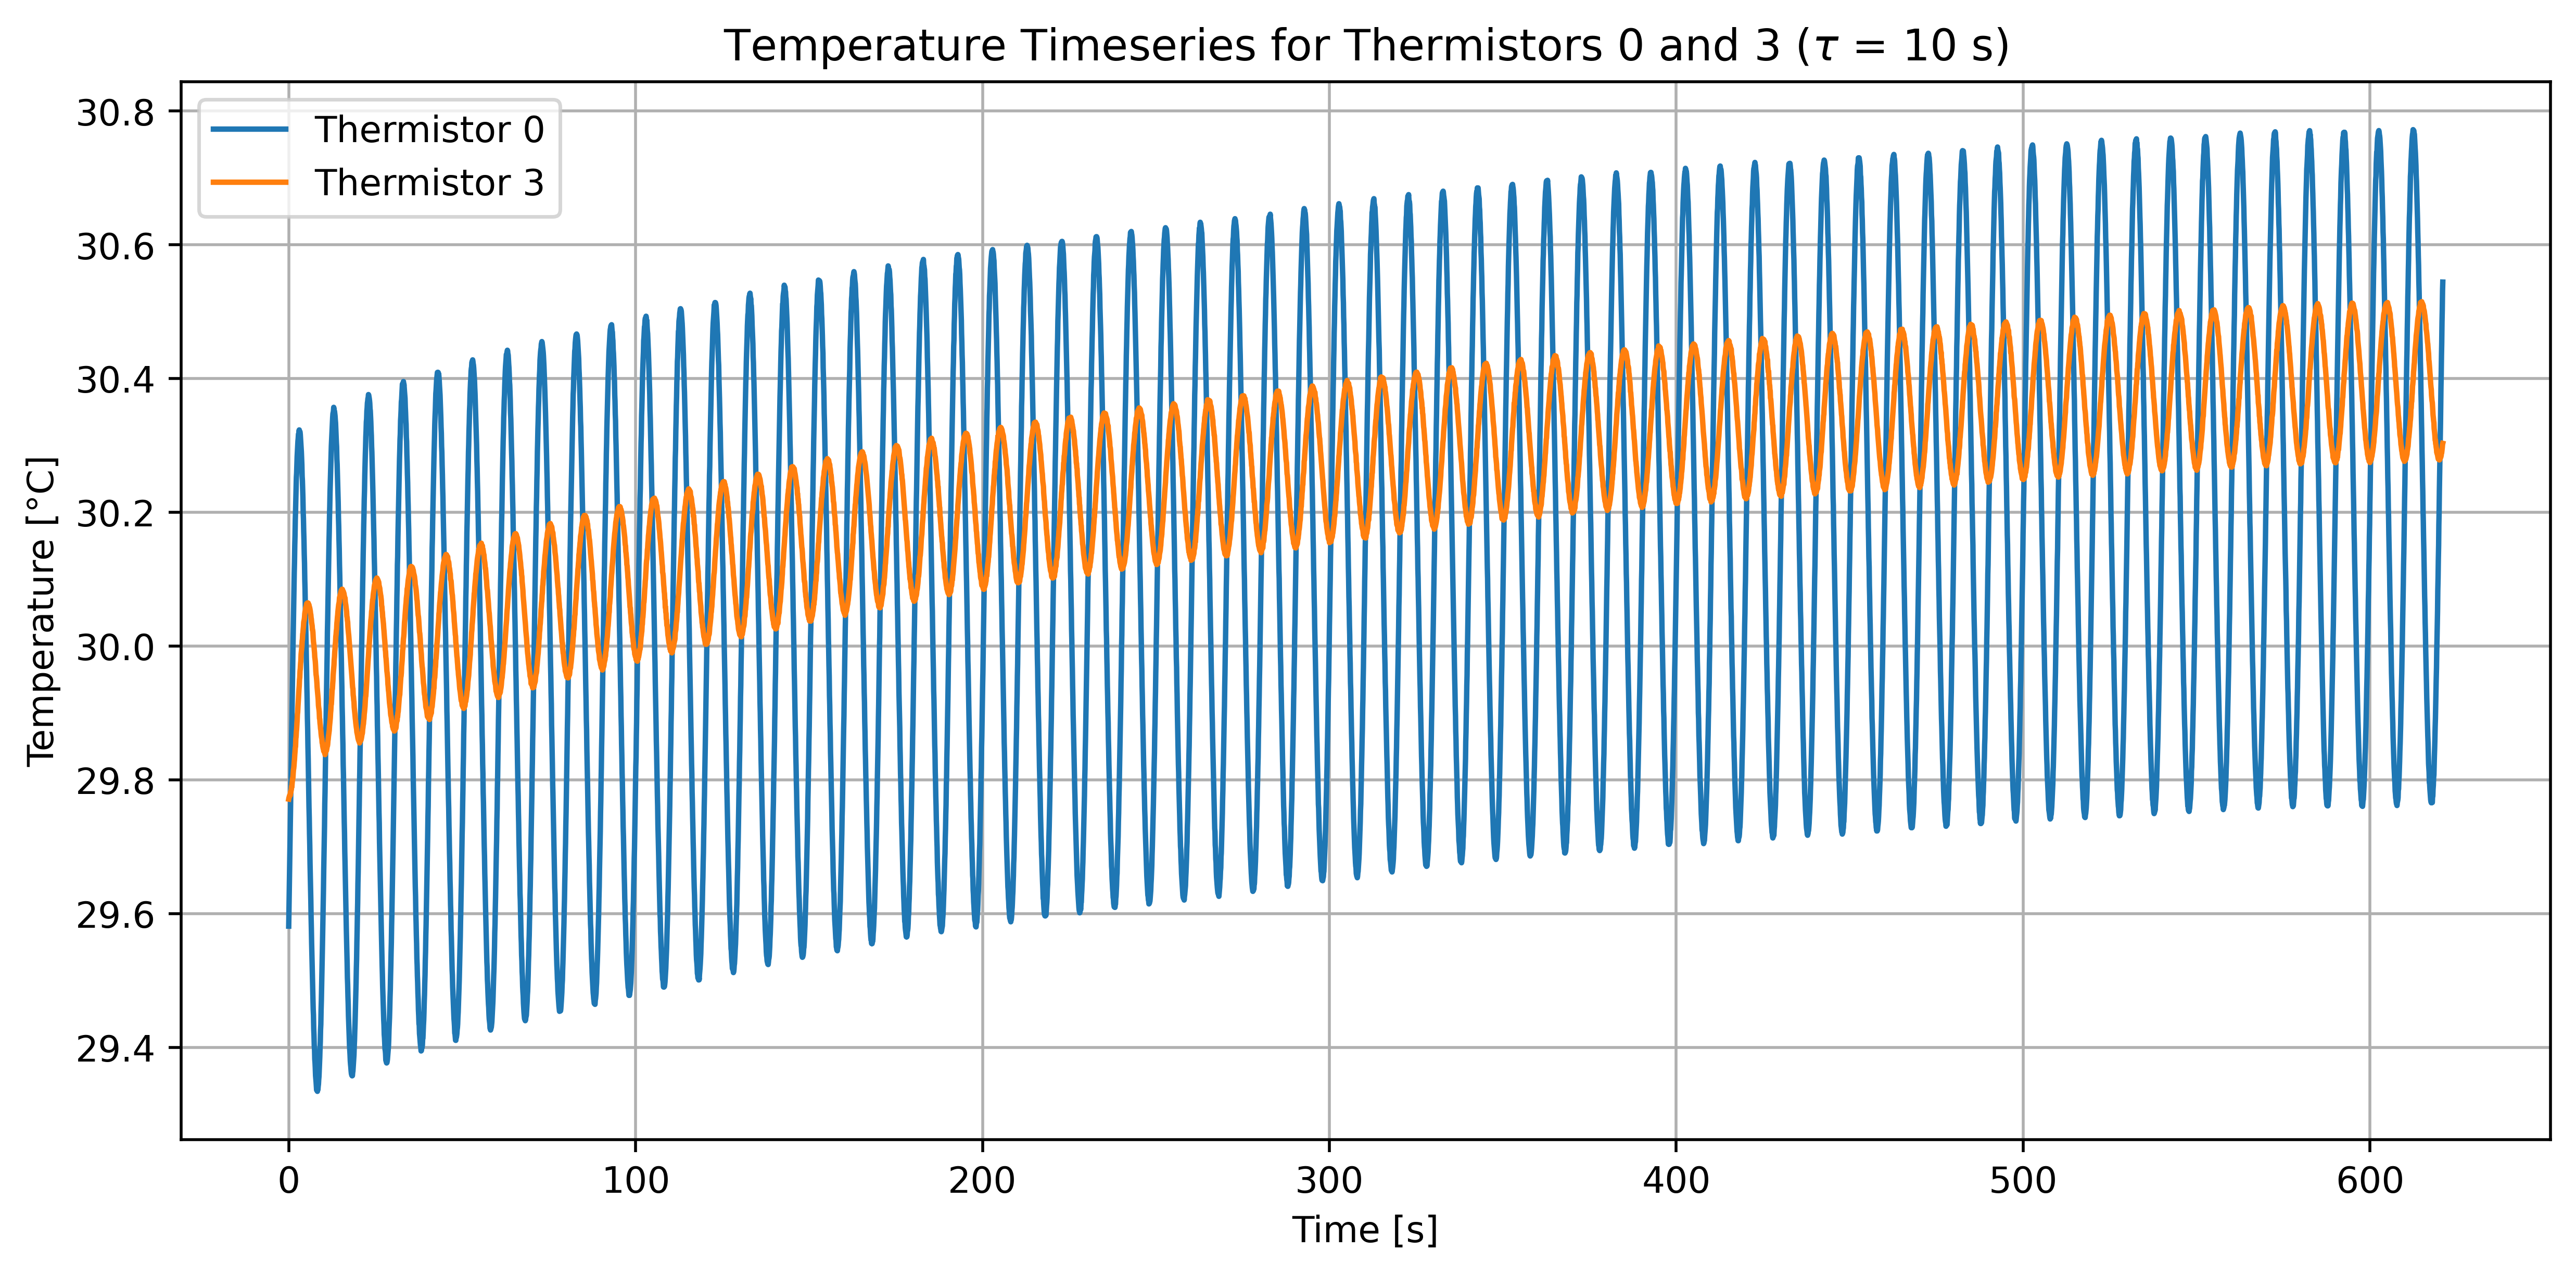

In [196]:
plt.figure(figsize=(10, 5), dpi=500)
plt.plot(timestamp, Temperatures[:, 0], label=r"Thermistor 0")
plt.plot(timestamp, Temperatures[:, 3], label=r"Thermistor 3")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.title(r"Temperature Timeseries for Thermistors 0 and 3 ($\tau$ = 10 s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

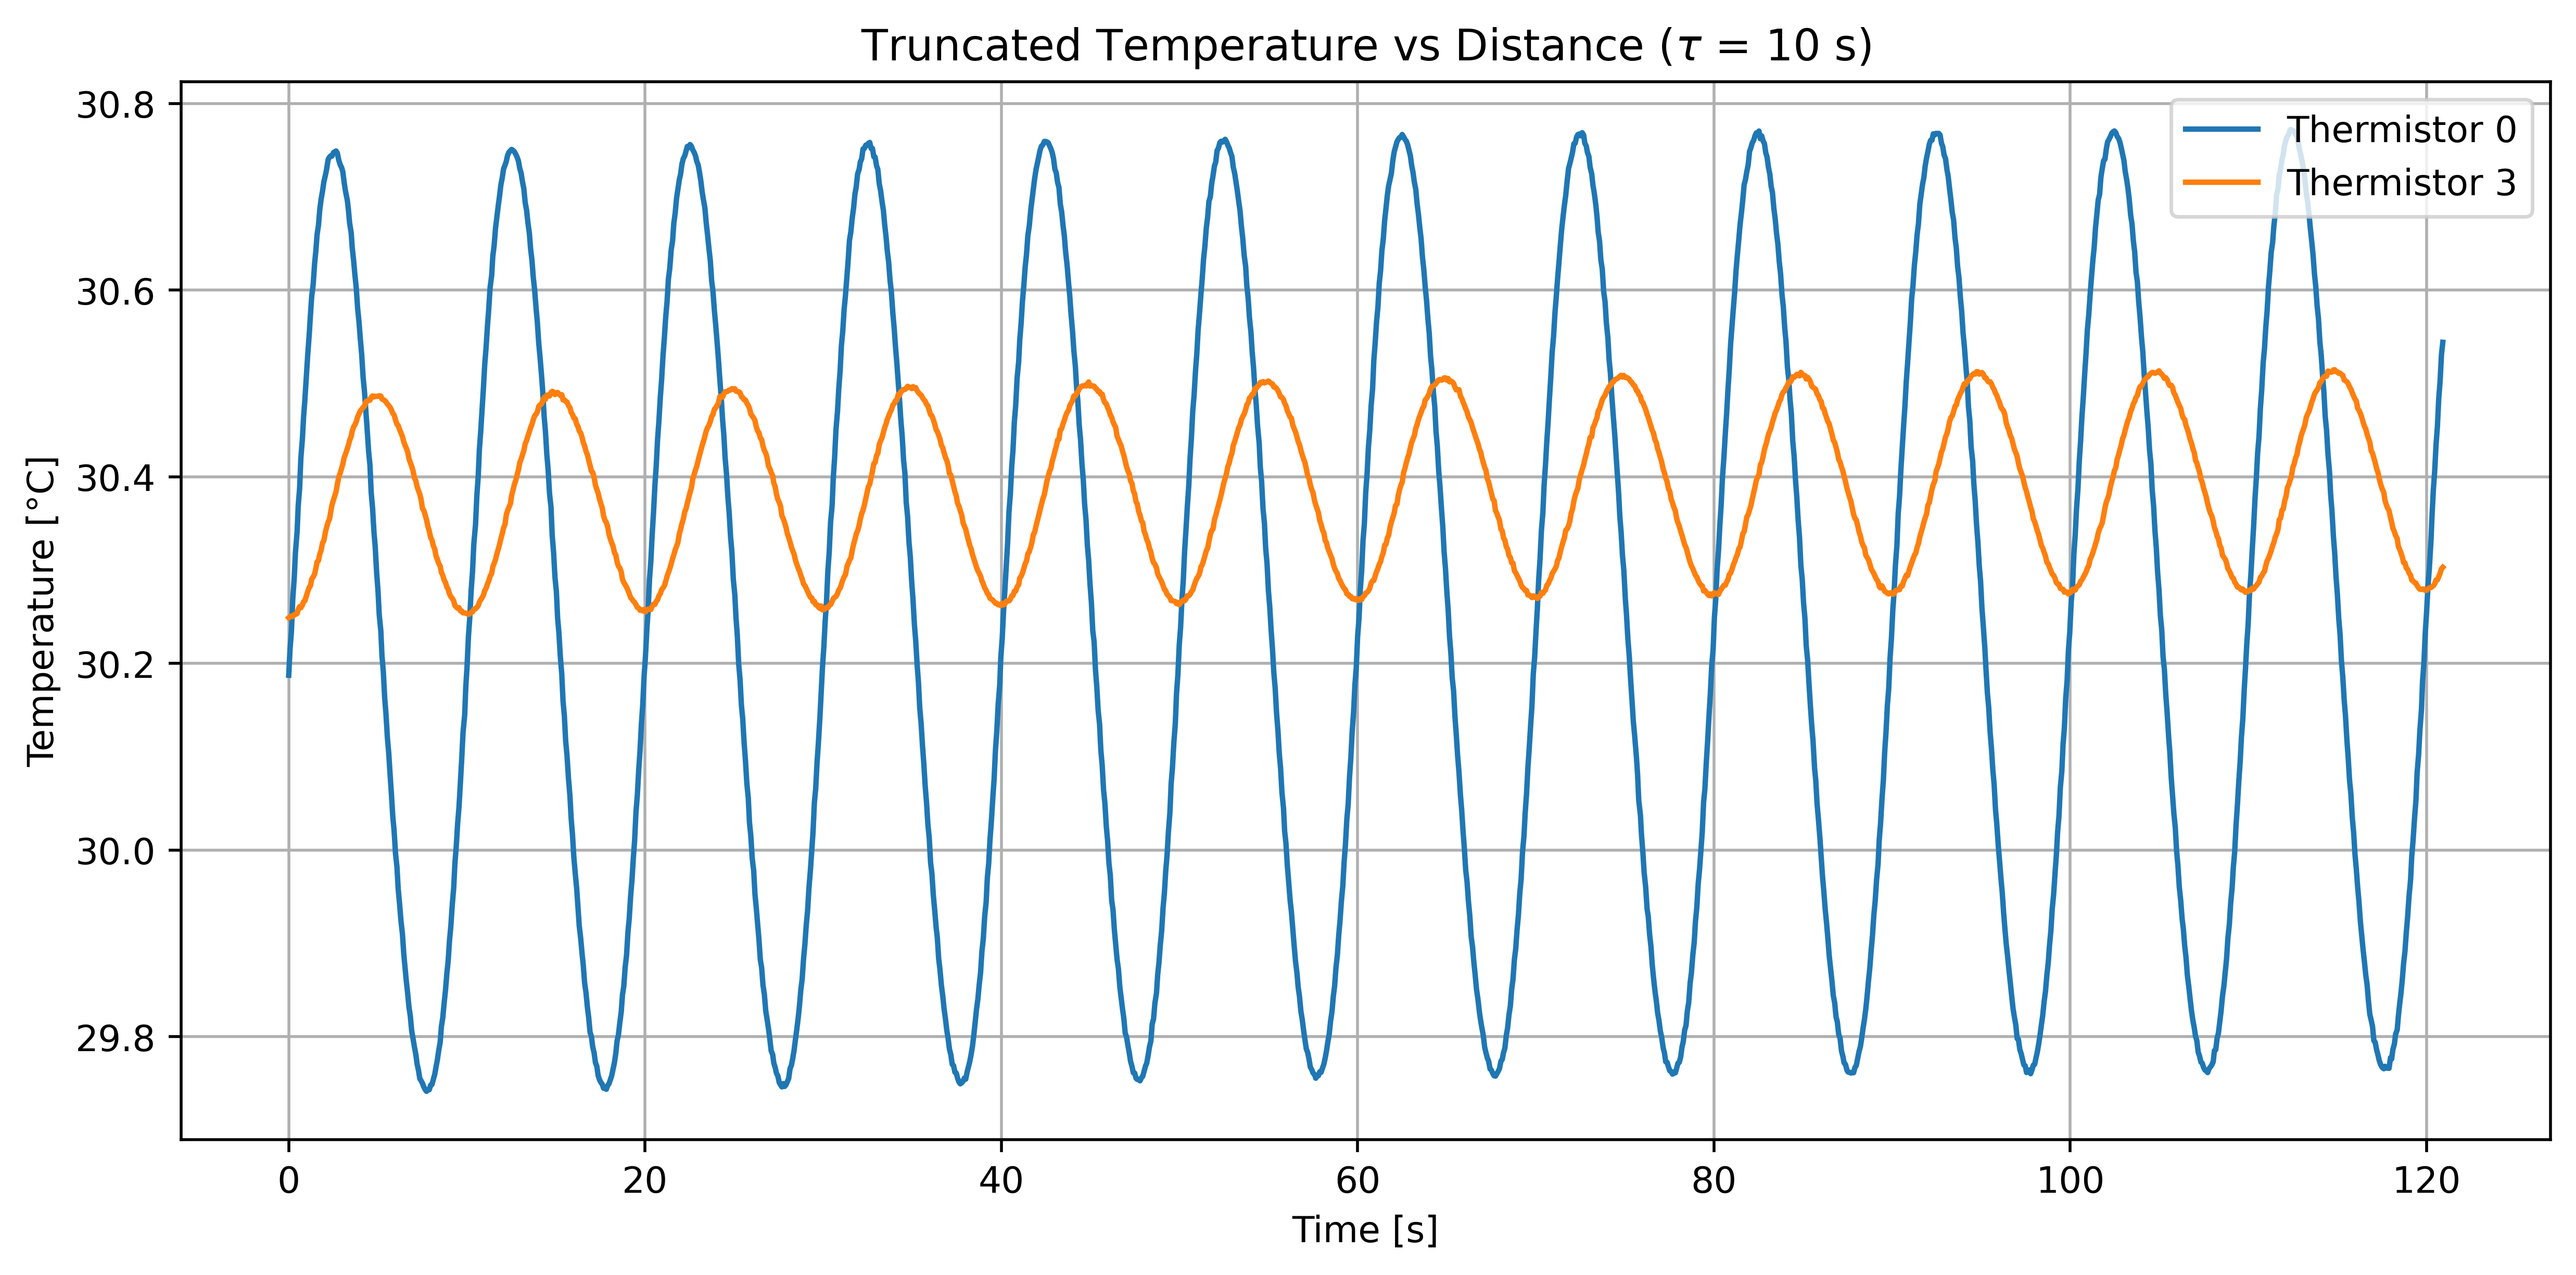

In [197]:
# Manual truncation: Keep only t > 500 s
mask = timestamp > 500.0

# Shift so it starts at t = 0 s
time_trunc = timestamp[mask] - timestamp[mask][0]

# Truncated Temperatures for i = 0, 3
T_trunc_0 = Temperatures[mask, 0]  # i = 0
T_trunc_3 = Temperatures[mask, 3]  # i = 3

plt.figure(figsize=(10, 5), dpi=500)
plt.plot(time_trunc, T_trunc_0, label=r"Thermistor 0")
plt.plot(time_trunc, T_trunc_3, label=r"Thermistor 3")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.title(r"Truncated Temperature vs Distance ($\tau$ = 10 s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


We will now define functions to extract the amplitude and phase from a single thermistor:

In [198]:
def plane_wave_model(t, T0, A, phi, omega):
    return T0 + A * np.sin(omega * t + phi)

def planewave_curvefit(t, y, omega=None, comments=None):
    
    # Function will detect the time period from the comments
    if comments is not None and omega is None:
        T_match = re.search(r"Period\s*=\s*([\d.]+)", comments)
        if not T_match:
            raise ValueError("Couldn't find time period in comments.")
        T = float(T_match.group(1))
        omega = 2 * np.pi / T
 
    # Initial guesses
    T0_guess  = np.mean(y)
    A_guess   = 0.5 * (np.percentile(y,95) - np.percentile(y,5))
    phi_guess = 0.0

    popt, pcov = curve_fit(
        lambda tt, T0, A, phi: plane_wave_model(tt, T0, A, phi, omega),
        t, y,
        p0=[T0_guess, A_guess, phi_guess],
        maxfev=10000
    )
    
    T0, A, phi = popt
    unc_T0, unc_A, unc_phi = np.sqrt(np.diag(pcov))

    # Enforce A ≥ 0
    if A < 0:
        A = -A
        phi = phi + np.pi

    return (T0, unc_T0), (A, unc_A), (phi, unc_phi), omega

In [199]:
(T0_0, unc_T0_0), (A0, unc_A0), (phi0, unc_phi0), omega = planewave_curvefit(time_trunc, T_trunc_0, comments=comments)

(T0_3, unc_T0_3), (A3, unc_A3), (phi3, unc_phi3), omega = planewave_curvefit(time_trunc, T_trunc_3, comments=comments)
print()

display(Math(rf"A_0 = {A0:.4f} \pm {unc_A0:.4f}\ \text{{°C}}"))
display(Math(rf"\phi_0 = {phi0:.4f} \pm {unc_phi0:.4f}\ \text{{rad}}"))
display(Math(""))
display(Math(rf"A_3 = {A3:.4f} \pm {unc_A3:.4f}\ \text{{°C}}"))
display(Math(rf"\phi_3 = {phi3:.4f} \pm {unc_phi3:.4f}\ \text{{rad}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Define functions to determine attenuation factor and phase difference:

In [200]:
def attenuation_factor(A1, unc_A1, A2, unc_A2):
    g = A2 / A1
    unc_g = g * np.sqrt((unc_A2/A2)**2 + (unc_A1/A1)**2)
    return g, unc_g

def phase_difference(phi1, unc_phi1, phi2, unc_phi2):
    dphi = phi2 - phi1
    unc_dphi = np.sqrt(unc_phi1**2 + unc_phi2**2)
    return dphi, unc_dphi

In [201]:
g, unc_g = attenuation_factor(A0, unc_A0, A3, unc_A3)
dphi, unc_dphi = phase_difference(phi0, unc_phi0, phi3, unc_phi3)

display(Math(rf"\gamma_3 = {g:.4f} \pm {unc_g:.4f}"))
display(Math(rf"\Delta\phi_3 = {dphi:.4f} \pm {unc_dphi:.4f}\ \text{{rad}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [202]:
D_gamma_3 = (omega*(3*delta_d)**2) / (2*(np.log(g))**2)
D_phi_3 = (omega*(3*delta_d)**2) / (2*(dphi)**2)

unc_D_gamma_3 = abs(2 * D_gamma_3 / (g * np.log(g))) * unc_g
unc_D_phi_3   = abs(2 * D_phi_3   / dphi)            * unc_dphi

display(Math(rf"T = 10\,\text{{s}},\, i = 3:"))
display(Math(rf"D_\gamma = {D_gamma_3:.4f} \pm {unc_D_gamma_3:.4f}\, \text{{mm}}^2/\text{{s}}"))
display(Math(rf"D_\phi = {D_phi_3:.8f} \pm {unc_D_phi_3:.4f}\, \text{{mm}}^2/\text{{s}}"))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### **Task 1.5 (b) – Extract transmission factor for all thermistors and plot them**
We now fit **all thermistors** with the same sinusoidal model to extract their
amplitudes $A_i$ and phases $\phi_i$, then compute the attenuation factor
$\gamma_i = A_i / A_0$ and plot it against distance $x_i = i \Delta d$.

In [203]:
# Truncated temperature data for all thermistors
Temps_trunc = Temperatures[mask, :]

n_therm = Temps_trunc.shape[1] - 1

amps = np.zeros(n_therm)
unc_amps = np.zeros(n_therm)
phases = np.zeros(n_therm)
unc_phases = np.zeros(n_therm)

for i in range(n_therm):
    T_i = Temps_trunc[:, i]

    # Fit sinusoid to truncated data
    (_, _), (A, unc_A), (phi, unc_phi), omega = planewave_curvefit(
        time_trunc, T_i,
        comments=comments  # auto-detect the period
    )

    amps[i] = A
    unc_amps[i] = unc_A
    phases[i] = phi
    unc_phases[i] = unc_phi

# Unwrap phases across thermistors so they vary linearly
phases = np.unwrap(phases)

print("Amplitudes A_i:", amps)
print()
print("Phases phi_i  :", phases)

Amplitudes A_i: [0.50236558 0.30401466 0.18234857 0.11750757 0.0682991  0.04115925
 0.02785659]

Phases phi_i  : [-0.05612737 -0.56339742 -1.10901114 -1.51968318 -2.04061669 -2.58635282
 -3.18765453]


In [204]:
# Thermistor indices and distances
i_vals = np.arange(n_therm)  # i = 0, 1, 2, ... , 7
x = i_vals * delta_d  # delta_d = 5 mm

# Attenuation factors
gamma = amps / amps[0]
unc_gamma = gamma * np.sqrt(
    (unc_amps / amps) ** 2 + (unc_amps[0] / amps[0]) ** 2)

# Taking natural logs ln(γ_i)
ln_gamma = np.log(gamma)
unc_ln_gamma = unc_gamma/gamma

# Compute phase lag relative to thermistor 0
dphi = phases - phases[0]
unc_dphi = np.sqrt(unc_phases**2 + unc_phases[0]**2)

print("Attenuation Factors:", gamma)
print("Attenuation Factor Uncertainties:", unc_gamma)
print("Phase Lags:", dphi)
print("Phase Lag Uncertainties:", unc_dphi)

Attenuation Factors: [1.         0.60516618 0.36297982 0.23390849 0.13595498 0.08193088
 0.05545084]
Attenuation Factor Uncertainties: [0.00166911 0.00106508 0.00080189 0.00069879 0.00065352 0.00065821
 0.00065828]
Phase Lags: [ 0.         -0.50727005 -1.05288377 -1.46355581 -1.98448932 -2.53022545
 -3.13152716]
Phase Lag Uncertainties: [0.00165773 0.00174824 0.00220567 0.00299933 0.00483762 0.00803996
 0.0117915 ]


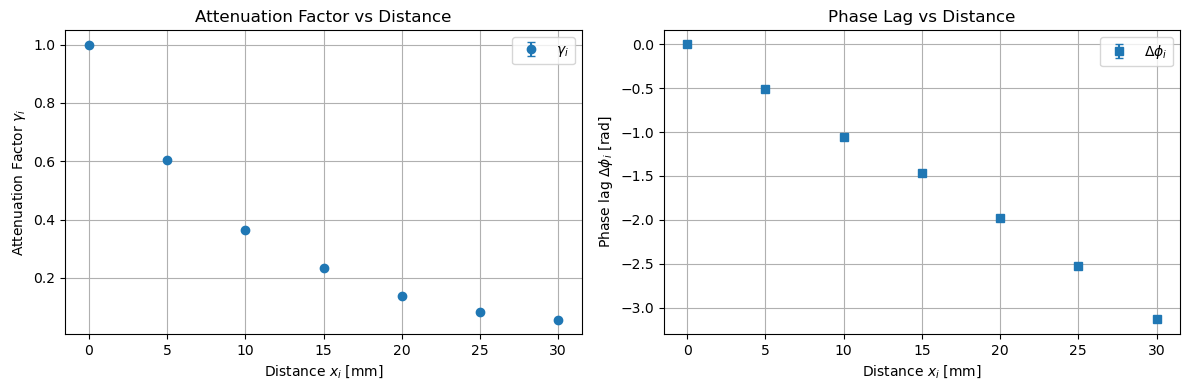

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Left Plot: Attenuation Factor vs Distance
ax = axes[0]
ax.errorbar(
    x, gamma,
    yerr = unc_gamma,
    fmt = 'o', capsize=3,
    label = r'$\gamma_i$')

ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Attenuation Factor $\gamma_i$")
ax.set_title("Attenuation Factor vs Distance")
ax.grid(True)
ax.legend()

# Right Plot: Phase-lag vs Distance
ax = axes[1]
ax.errorbar(
    x, dphi,
    yerr=unc_dphi,
    fmt='s', capsize=3,
    label=r'$\Delta\phi_i$',)

ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Phase lag $\Delta\phi_i$ [rad]")
ax.set_title("Phase Lag vs Distance")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


#### **Task 1.5 (c) – Fit attenuation vs distance to extract $D_\gamma$**

From the plane-wave solution, the attenuation factor 

$$
\ln(\gamma_i) = -\sqrt{\frac{\omega}{2D}} \, (i\Delta d)
$$

where $x_i = i \Delta d$, so we fit

$$
\ln(\gamma_i) = k_{\gamma} \, x_i
$$

and compute the diffusivity:

$$
D = \frac{\omega}{2 k_{\gamma}^2}.
$$

---

#### **Task 1.5 (d) – Fit phase lag vs distance to extract $D_\phi$**

The theoretical phase lag is

$$
\Delta\phi_i = \sqrt{\frac{\omega}{2D}} \, (i\Delta d),
$$

where $x_i = i \Delta d$, so we fit

$$
\Delta\phi_i = k_{\phi} \, x_i.
$$

Thus,

$$
D = \frac{\omega}{2 k_{\phi}^2}.
$$


In [206]:
def linear(x, k, c):
    return k * x + c

In [207]:
# Apply linear fit to ln(gamma) vs distance
popt_gamma, pcov_gamma = curve_fit(
    linear,
    x,
    ln_gamma,
    sigma = unc_ln_gamma,
    absolute_sigma = True,
    maxfev=10000
)
k_gamma, c_gamma = popt_gamma
unc_k_gamma, unc_c_gamma = np.sqrt(np.diag(pcov_gamma))

# Apply linear fit to phase lag vs distance
popt_phi, pcov_phi = curve_fit(
    linear,
    x,
    dphi,
    sigma=unc_dphi,
    absolute_sigma=True,
    maxfev=10000
)
k_phi, c_phi = popt_phi
unc_k_phi, unc_c_phi = np.sqrt(np.diag(pcov_phi))

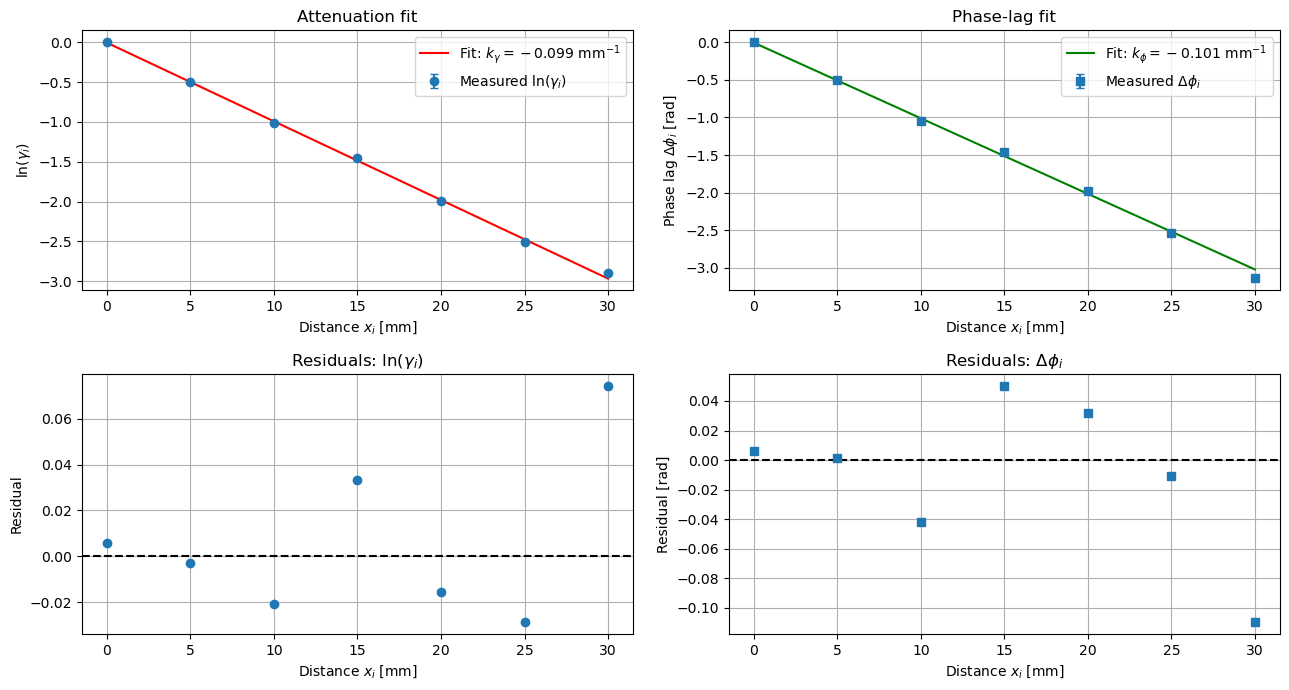

In [208]:
# Compute model values and residuals
ln_fit   = linear(x, k_gamma, c_gamma)
phi_fit  = linear(x, k_phi, c_phi)

ln_resid  = ln_gamma - ln_fit
phi_resid = dphi      - phi_fit

x_dense = np.linspace(x.min(), x.max(), 300)

fig, axes = plt.subplots(2, 2, figsize=(13, 7))

# Top-left: Attenuation fit (ln gamma)
ax = axes[0, 0]
ax.errorbar(
    x, ln_gamma,
    yerr=unc_ln_gamma,
    fmt='o', capsize=3,
    label=r'Measured $\ln(\gamma_i)$'
)
ax.plot(
    x_dense,
    linear(x_dense, k_gamma, c_gamma),
    'r-',
    label=rf'Fit: $k_\gamma = {k_gamma:.3f}$ mm$^{{-1}}$'
)
ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"$\ln(\gamma_i)$")
ax.set_title("Attenuation fit")
ax.grid(True)
ax.legend()

# Top-right: Phase-lag fit
ax = axes[0, 1]
ax.errorbar(
    x, dphi,
    yerr=unc_dphi,
    fmt='s', capsize=3,
    label=r'Measured $\Delta\phi_i$'
)
ax.plot(
    x_dense,
    linear(x_dense, k_phi, c_phi),
    'g-',
    label=rf'Fit: $k_\phi = {k_phi:.3f}$ mm$^{{-1}}$'
)
ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Phase lag $\Delta\phi_i$ [rad]")
ax.set_title("Phase-lag fit")
ax.grid(True)
ax.legend()

#Bottom-left: Residuals for ln(gamma)
ax = axes[1, 0]
ax.axhline(0, color='k', linestyle='--')
ax.plot(x, ln_resid, 'o')
ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel("Residual")
ax.set_title(r"Residuals: $\ln(\gamma_i)$")
ax.grid(True)

# Bottom-right: Residuals for phase
ax = axes[1, 1]
ax.axhline(0, color='k', linestyle='--')
ax.plot(x, phi_resid, 's')
ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel("Residual [rad]")
ax.set_title(r"Residuals: $\Delta\phi_i$")
ax.grid(True)

plt.tight_layout()
plt.show()


It looks like for the thermistors close to the top end of the cylinder the attenuation factor is higher than predicted by the model. As the total length of the cylinder is $L = 41\,\text{{mm}}$ and the amplitude of the temperature oscillations are non-zero at the end, we could be getting some reflection. The model assumes the cylinder is an 1-D slab of infinite length, hence only the upwards part of the solution matters. In reality this is not the case as we can see above.

In [209]:
# Diffusivity from transmission factor (mm^2/s)
D_gamma = omega / (2 * k_gamma ** 2)
unc_D_gamma = np.abs(-omega / (k_gamma ** 3)) * unc_k_gamma

# Diffusivity from phase (mm^2/s)
D_phi = omega / (2 * k_phi ** 2)
unc_D_phi = np.abs(-omega / (k_phi ** 3)) * unc_k_phi

# Display results
display(Math(rf"D_\gamma = {D_gamma:.3f} \pm {unc_D_gamma:.3f}\ \text{{mm}}^2/\text{{s}}"))
display(Math(rf"D_\phi = {D_phi:.3f} \pm {unc_D_phi:.3f}\ \text{{mm}}^2/ \text{{s}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

This approximately matches the diffusivity of brass. Our model fit errors are quite low hence the propagated uncertianty on the diffusivity is also low.

## **Task 1.6**

**a)** Send sine wave of different periods, e.g. 15s, 20s, 30s, 60s. Repeat each dataset a few times and use this to estimate the noise level on your extracted phase and amplitudes. Don’t forget to let the temperatures stabilize! 

---

**b)** Plot the attenuation and phase lags for each frequency and extract estimates of D for each frequency with each method. How well does the model work at all these frequencies?




#### **Task 1.6 (a) – Collect data and truncate each to remove transients**

We first plot all collected data sets to determine over what region we should truncate.

In [210]:
'''
for fname in files:
    path = os.path.join(save_dir, fname)

    timestamp, V, I, Temperatures, comments = load_dataset(path)

    n_therm = Temperatures.shape[1]

    plt.figure(figsize=(12, 5))

    for i in range(n_therm):
        plt.plot(timestamp, Temperatures[:, i], label=f"Thermistor {i}")

    plt.xlabel("Time [s]")
    plt.ylabel("Temperature [°C]")
    plt.title(f"All thermistors — {fname}")
    plt.grid(True)
    plt.legend(ncol=4, fontsize=9)
    plt.tight_layout()
    plt.show()
'''

'\nfor fname in files:\n    path = os.path.join(save_dir, fname)\n\n    timestamp, V, I, Temperatures, comments = load_dataset(path)\n\n    n_therm = Temperatures.shape[1]\n\n    plt.figure(figsize=(12, 5))\n\n    for i in range(n_therm):\n        plt.plot(timestamp, Temperatures[:, i], label=f"Thermistor {i}")\n\n    plt.xlabel("Time [s]")\n    plt.ylabel("Temperature [°C]")\n    plt.title(f"All thermistors — {fname}")\n    plt.grid(True)\n    plt.legend(ncol=4, fontsize=9)\n    plt.tight_layout()\n    plt.show()\n'

Given the plots above we will now manually truncate each file by applying a mask:

In [211]:
# Truncation rules:
truncate_rules = {
        'brass_T10s_run1.csv': lambda t: t > 500,
        'brass_T10s_run2.csv': lambda t: t < 200,
        'brass_T10s_run3.csv': lambda t: t > 650,
        'brass_T15s_run1.csv': lambda t: t > 500,
        'brass_T15s_run2.csv': lambda t: t > 100,
        'brass_T15s_run3.csv': lambda t: t > 400,
        'brass_T20s_run1.csv': lambda t: t > 200,
        'brass_T20s_run2.csv': lambda t: t < 200,
        'brass_T20s_run3.csv': lambda t: t < 200,
        'brass_T20s_run4.csv': lambda t: t > 400,
        'brass_T30s_run1.csv': lambda t: t > 300,
        'brass_T30s_run2.csv': lambda t: t > 100,
        'brass_T30s_run3.csv': lambda t: t > 400,
        'brass_T45s_run1.csv': lambda t: t > 400,
        'brass_T45s_run2.csv': lambda t: t > 400,
        'brass_T60s_run1.csv': lambda t: t > 300,
        'brass_T60s_run2.csv': lambda t: t > 300,
        'brass_T60s_run3.csv': lambda t: t > 400,
        'brass_T75s_run1.csv': lambda t: t > 300,
        'brass_T75s_run2.csv': lambda t: t > 300,
        'brass_T90s_run1.csv': lambda t: t > 350,
        'brass_T90s_run2.csv': lambda t: t > 350,
        'brass_T105s_run1.csv': lambda t: t < 400,
        'brass_T105s_run2.csv': lambda t: t > 400,
        'brass_T105s_run3.csv': lambda t: t > 200,
        'brass_T120s_run1.csv': lambda t: t > 300,
        'brass_T120s_run2.csv': lambda t: t > 250,
        'brass_T120s_run3.csv': lambda t: t > 350,
        'brass_T135s_run1.csv': lambda t: t > 300,
        'brass_T135s_run2.csv': lambda t: t > 300,
        'brass_T135s_run3.csv': lambda t: t > 250,
        'brass_T150s_run1.csv': lambda t: t > 250,
        'brass_T150s_run2.csv': lambda t: t > 350,
        'brass_T150s_run3.csv': lambda t: t > 350
}

In [212]:
'''
for fname in files:
    path = os.path.join(save_dir, fname)

    # Load the dataset
    timestamp, V, I, Temperatures, comments = load_dataset(path)
    n_therm = Temperatures.shape[1]

    # Get truncation mask for this file
    if fname in truncate_rules:
        mask = truncate_rules[fname](timestamp)
    else:
        mask = slice(None)  # if no truncation rule then use all data

    # Apply truncation
    t_trunc = timestamp[mask]
    Temps_trunc = Temperatures[mask, :]

    # Shift time so truncated series starts at t = 0
    t_rel = t_trunc - t_trunc[0]

    # Make the plot: all thermistors on one figure
    plt.figure(figsize=(12, 5))

    for i in range(n_therm):
        plt.plot(t_rel, Temps_trunc[:, i], label=f"Thermistor {i}")

    plt.xlabel("Time since truncation [s]")
    plt.ylabel("Temperature [°C]")
    plt.title(f"All thermistors (truncated) — {fname}")
    plt.grid(True)
    plt.legend(ncol=4, fontsize=9)
    plt.tight_layout()
    plt.show()
'''

'\nfor fname in files:\n    path = os.path.join(save_dir, fname)\n\n    # Load the dataset\n    timestamp, V, I, Temperatures, comments = load_dataset(path)\n    n_therm = Temperatures.shape[1]\n\n    # Get truncation mask for this file\n    if fname in truncate_rules:\n        mask = truncate_rules[fname](timestamp)\n    else:\n        mask = slice(None)  # if no truncation rule then use all data\n\n    # Apply truncation\n    t_trunc = timestamp[mask]\n    Temps_trunc = Temperatures[mask, :]\n\n    # Shift time so truncated series starts at t = 0\n    t_rel = t_trunc - t_trunc[0]\n\n    # Make the plot: all thermistors on one figure\n    plt.figure(figsize=(12, 5))\n\n    for i in range(n_therm):\n        plt.plot(t_rel, Temps_trunc[:, i], label=f"Thermistor {i}")\n\n    plt.xlabel("Time since truncation [s]")\n    plt.ylabel("Temperature [°C]")\n    plt.title(f"All thermistors (truncated) — {fname}")\n    plt.grid(True)\n    plt.legend(ncol=4, fontsize=9)\n    plt.tight_layout()\n  

#### **Task 1.6 (b) – Using multiple frequencies to determine $D(\omega)$**

We first define a function to analyse a single dataset which returns arrays of $\gamma_i$ and $\Delta\phi_i$ and their uncertainties:

In [213]:
def analyse_dataset(path):
    # Load dataset
    timestamp, V, I, Temperatures, comments = load_dataset(path)
    fname = os.path.basename(path)

    # --- Apply the same manual truncation rules as for plotting ---
    truncate_rules = {
        'brass_T10s_run1.csv': lambda t: t > 500,
        'brass_T10s_run2.csv': lambda t: t < 200,
        'brass_T10s_run3.csv': lambda t: t > 650,
        'brass_T15s_run1.csv': lambda t: t > 500,
        'brass_T15s_run2.csv': lambda t: t > 100,
        'brass_T15s_run3.csv': lambda t: t > 400,
        'brass_T20s_run1.csv': lambda t: t > 200,
        'brass_T20s_run2.csv': lambda t: t < 200,
        'brass_T20s_run3.csv': lambda t: t < 200,
        'brass_T20s_run4.csv': lambda t: t > 400,
        'brass_T30s_run1.csv': lambda t: t > 300,
        'brass_T30s_run2.csv': lambda t: t > 100,
        'brass_T30s_run3.csv': lambda t: t > 400,
        'brass_T45s_run1.csv': lambda t: t > 400,
        'brass_T45s_run2.csv': lambda t: t > 400,
        'brass_T60s_run1.csv': lambda t: t > 300,
        'brass_T60s_run2.csv': lambda t: t > 300,
        'brass_T60s_run3.csv': lambda t: t > 400,
        'brass_T75s_run1.csv': lambda t: t > 300,
        'brass_T75s_run2.csv': lambda t: t > 300,
        'brass_T90s_run1.csv': lambda t: t > 350,
        'brass_T90s_run2.csv': lambda t: t > 350,
        'brass_T105s_run1.csv': lambda t: t < 400,
        'brass_T105s_run2.csv': lambda t: t > 400,
        'brass_T105s_run3.csv': lambda t: t > 200,
        'brass_T120s_run1.csv': lambda t: t > 300,
        'brass_T120s_run2.csv': lambda t: t > 250,
        'brass_T120s_run3.csv': lambda t: t > 350,
        'brass_T135s_run1.csv': lambda t: t > 300,
        'brass_T135s_run2.csv': lambda t: t > 300,
        'brass_T135s_run3.csv': lambda t: t > 250,
        'brass_T150s_run1.csv': lambda t: t > 250,
        'brass_T150s_run2.csv': lambda t: t > 350,
        'brass_T150s_run3.csv': lambda t: t > 350
        }

    if fname in truncate_rules:
        mask = truncate_rules[fname](timestamp)
    else:
        # Fallback: if no rule then use full data
        mask = np.ones_like(timestamp, dtype=bool)

    timestamp_trunc = timestamp[mask]
    Temps_trunc     = Temperatures[mask, :]

    # Shift time so truncated segment starts at t = 0
    timestamp_trunc = timestamp_trunc - timestamp_trunc[0]

    # Number of thermistors
    n_therm = Temps_trunc.shape[1] - 1

    # Arrays for amplitudes and phases
    amps = np.zeros(n_therm)
    unc_amps = np.zeros(n_therm)
    phases = np.zeros(n_therm)
    unc_phases = np.zeros(n_therm)

    # --- Fit each thermistor on the already-truncated data ---
    for i in range(n_therm):
        T_i = Temps_trunc[:, i]

        (_, _), (A, unc_A), (phi, unc_phi), omega = planewave_curvefit(
            timestamp_trunc,
            T_i,
            comments=comments  # auto-detect Period → omega
        )

        amps[i] = A
        unc_amps[i] = unc_A
        phases[i] = phi
        unc_phases[i] = unc_phi

    # Unwrap phases across thermistors
    phases = np.unwrap(phases)

    # Transmission factors γ_i = A_i / A_0
    gamma = amps / amps[0]
    unc_gamma = gamma * np.sqrt(
        (unc_amps / amps) ** 2 +
        (unc_amps[0] / amps[0]) ** 2
    )

    # Phase lags Δφ_i = φ_i - φ_0
    dphi = phases - phases[0]
    unc_dphi = np.sqrt(unc_phases ** 2 + unc_phases[0] ** 2)

    return omega, gamma, unc_gamma, dphi, unc_dphi


We now create a loop to index through each data set and determine the transmission factors and phase lags. We will then average over each run to calculate the statistical uncertainty for each frequency. Then we will determine the diffusivity of the material using the either of $\gamma$ or $\Delta\Phi$ using the linear fit we defined above. Our plane wave model assumes that the diffusivity is independent of the driving frequency. In reality we should see the plane wave model break down for low frequencies (high time periods). Hence, we will plot diffusivity as a function of the angular frequency $D(\omega)$ to determine what range of frequencies our model works over.


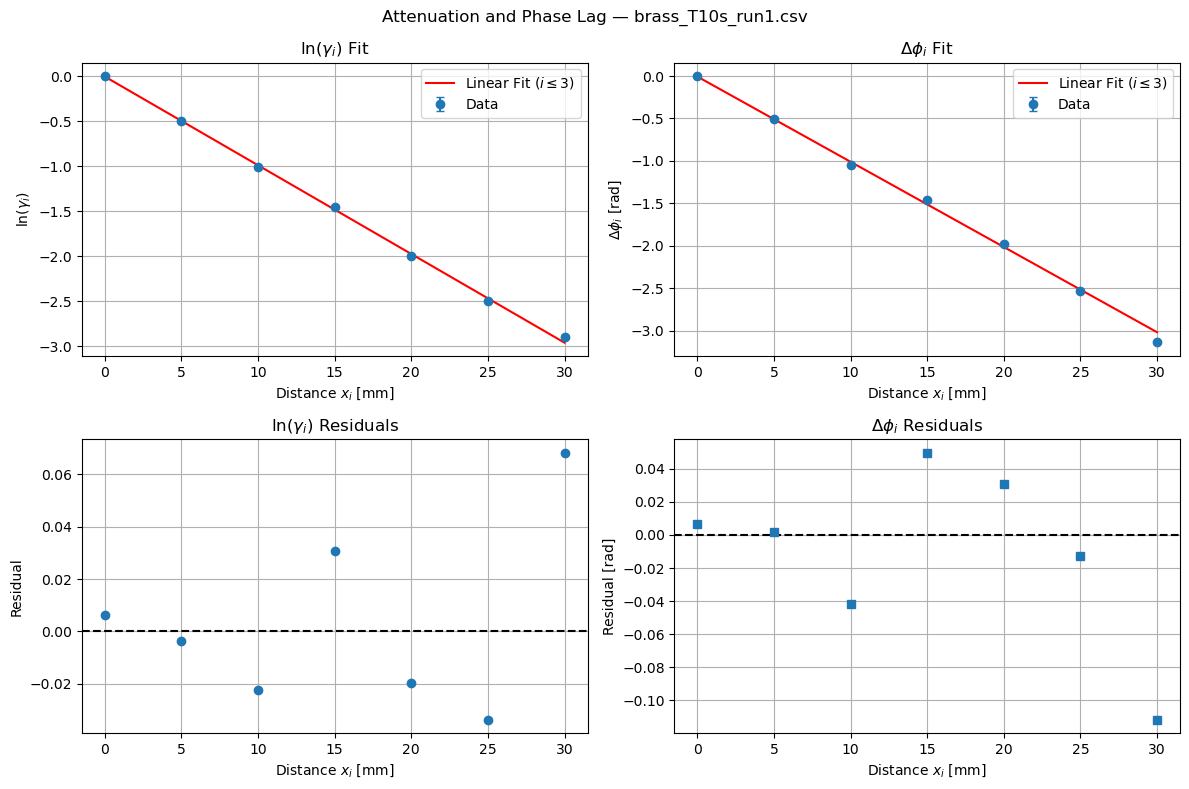

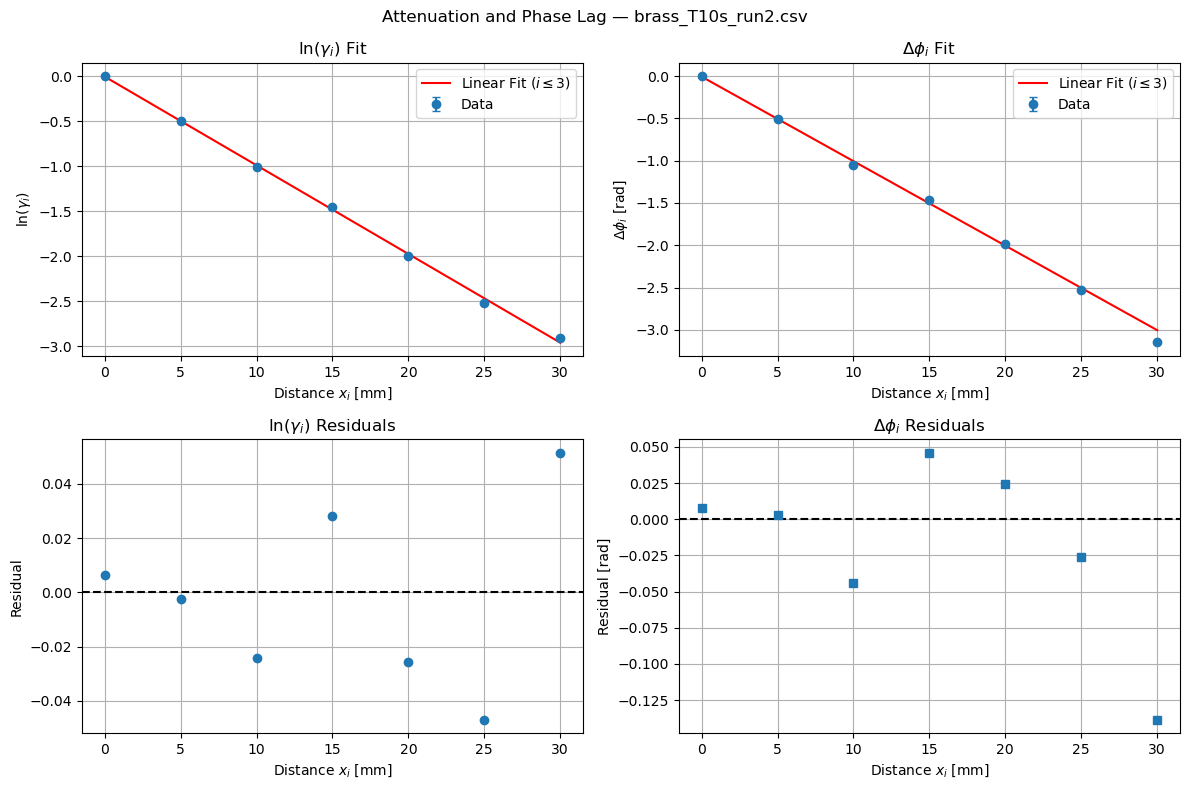

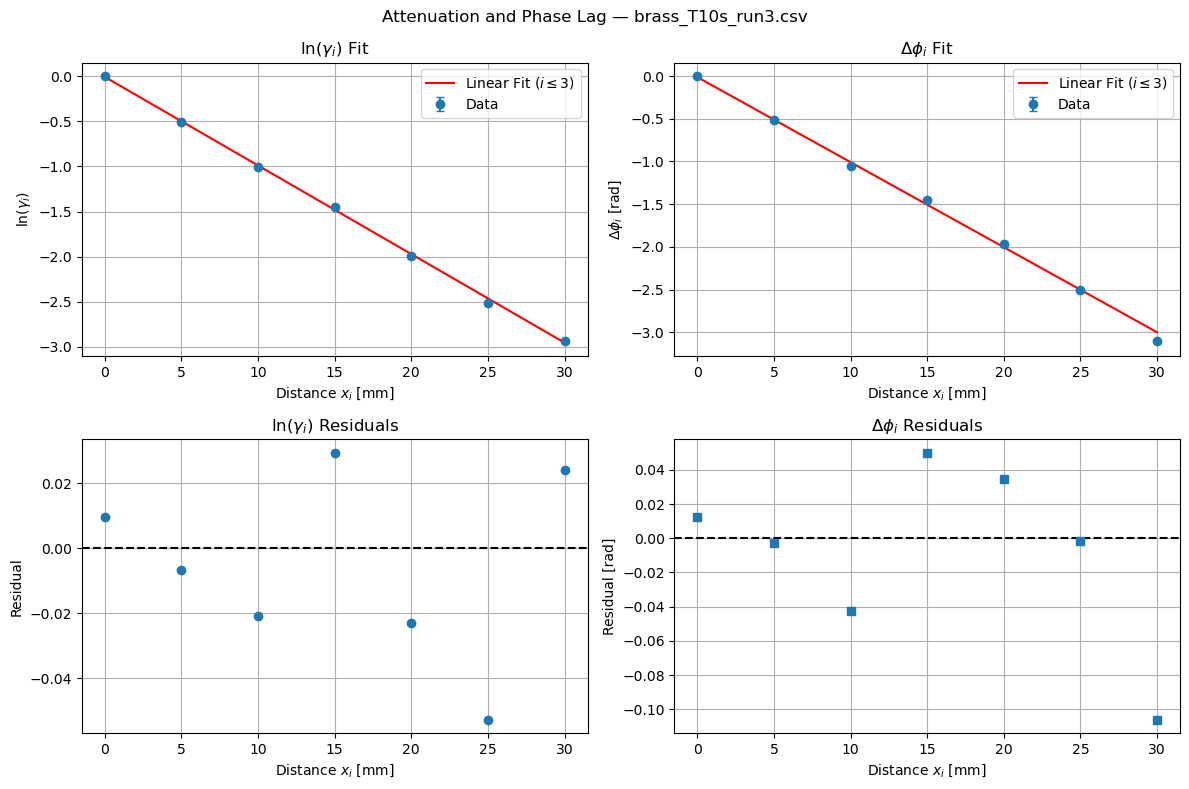

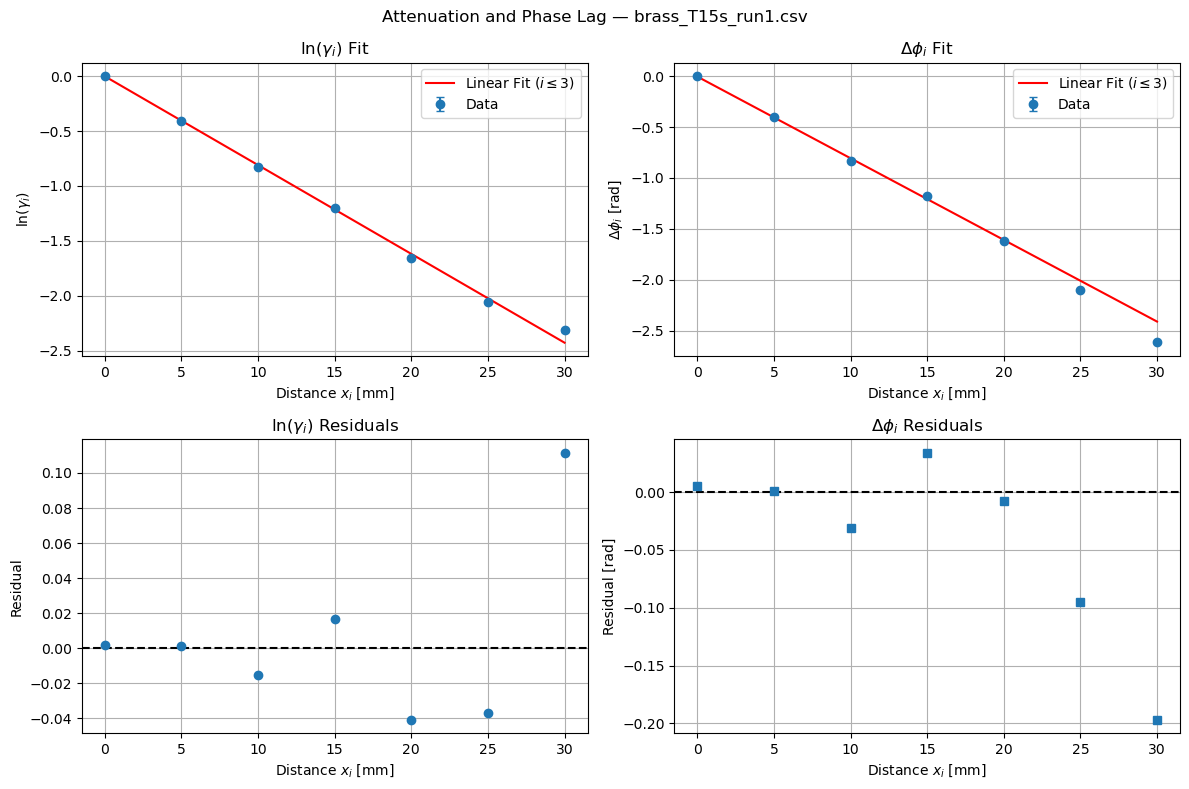

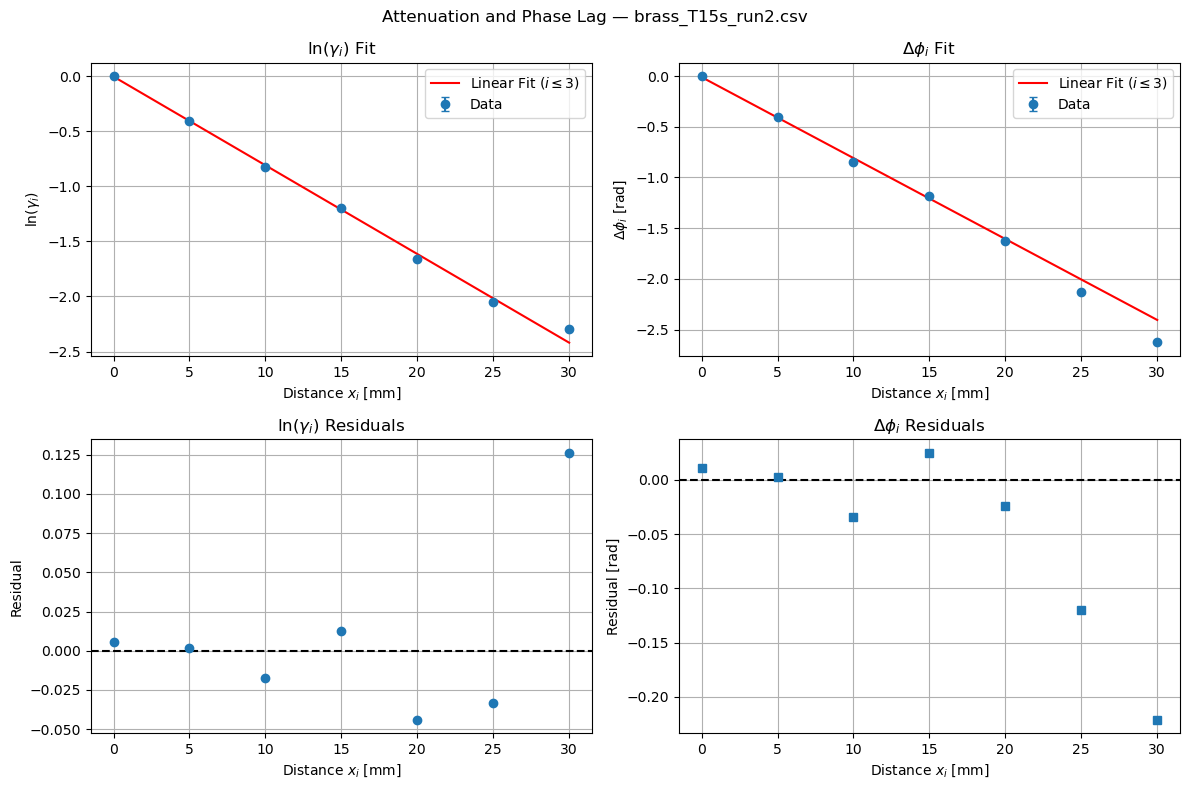

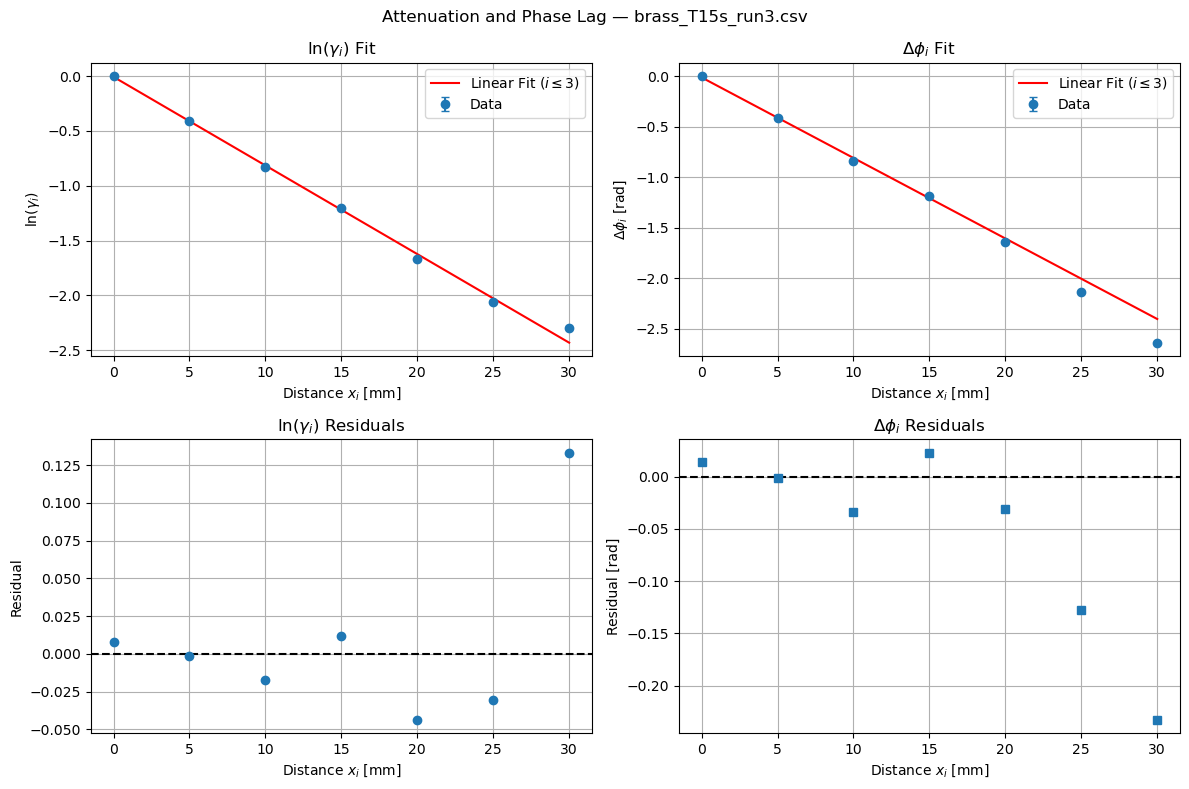

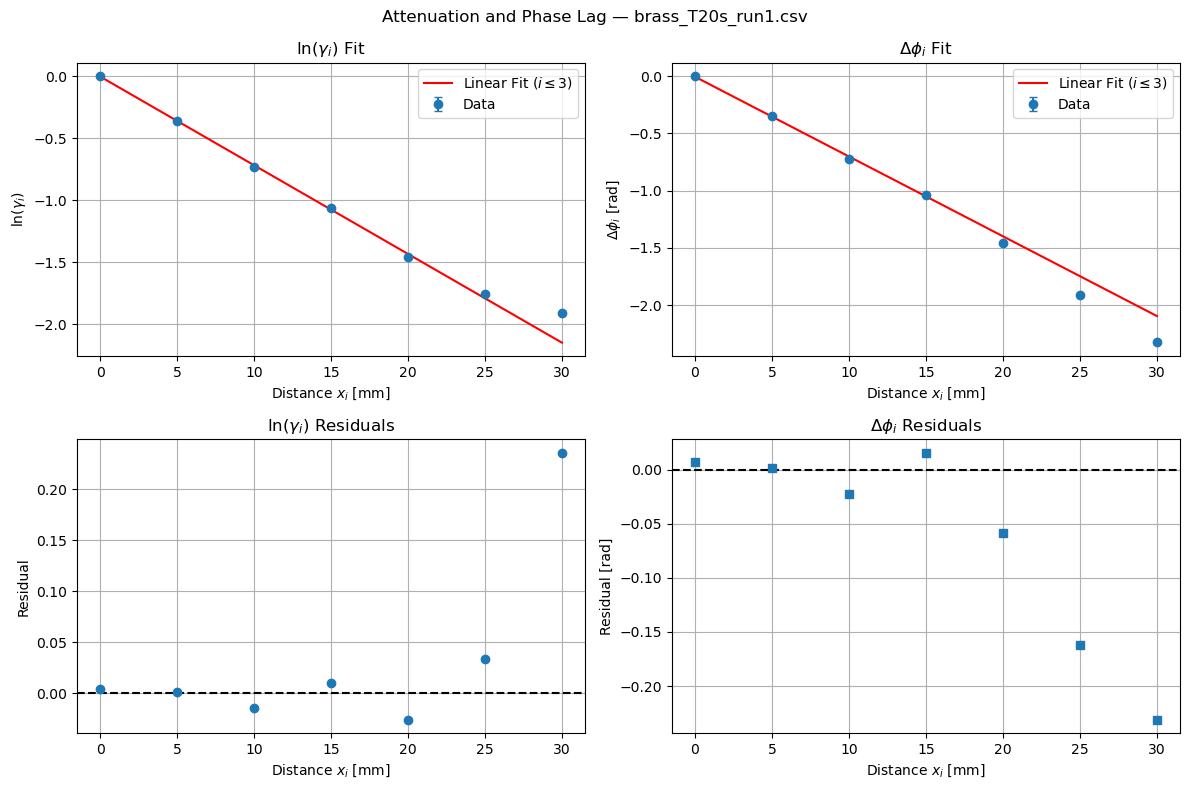

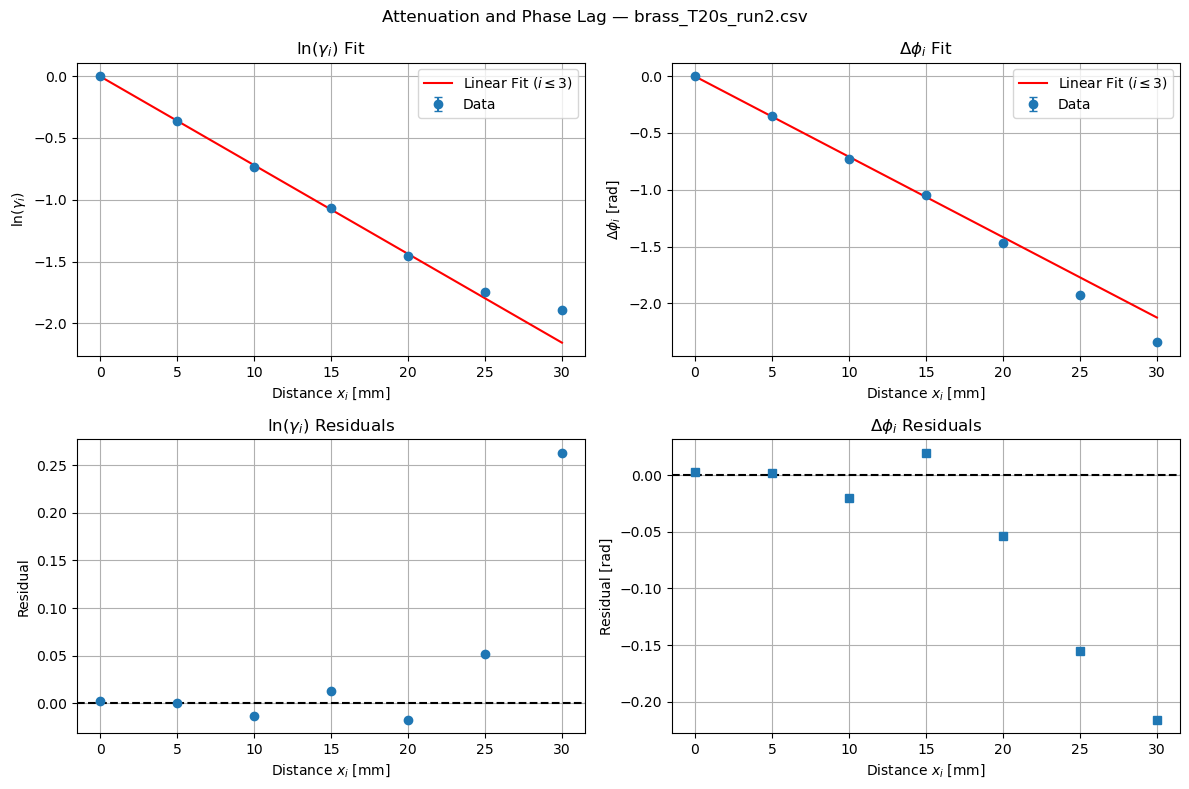

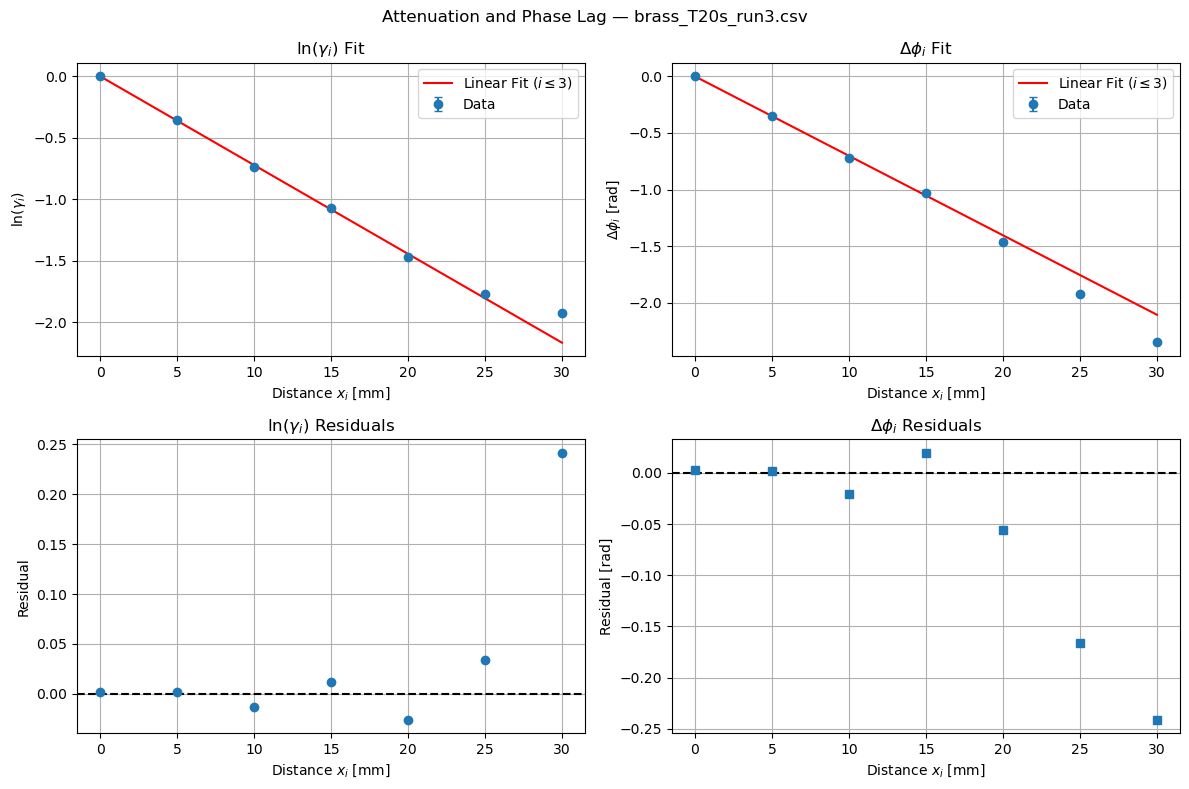

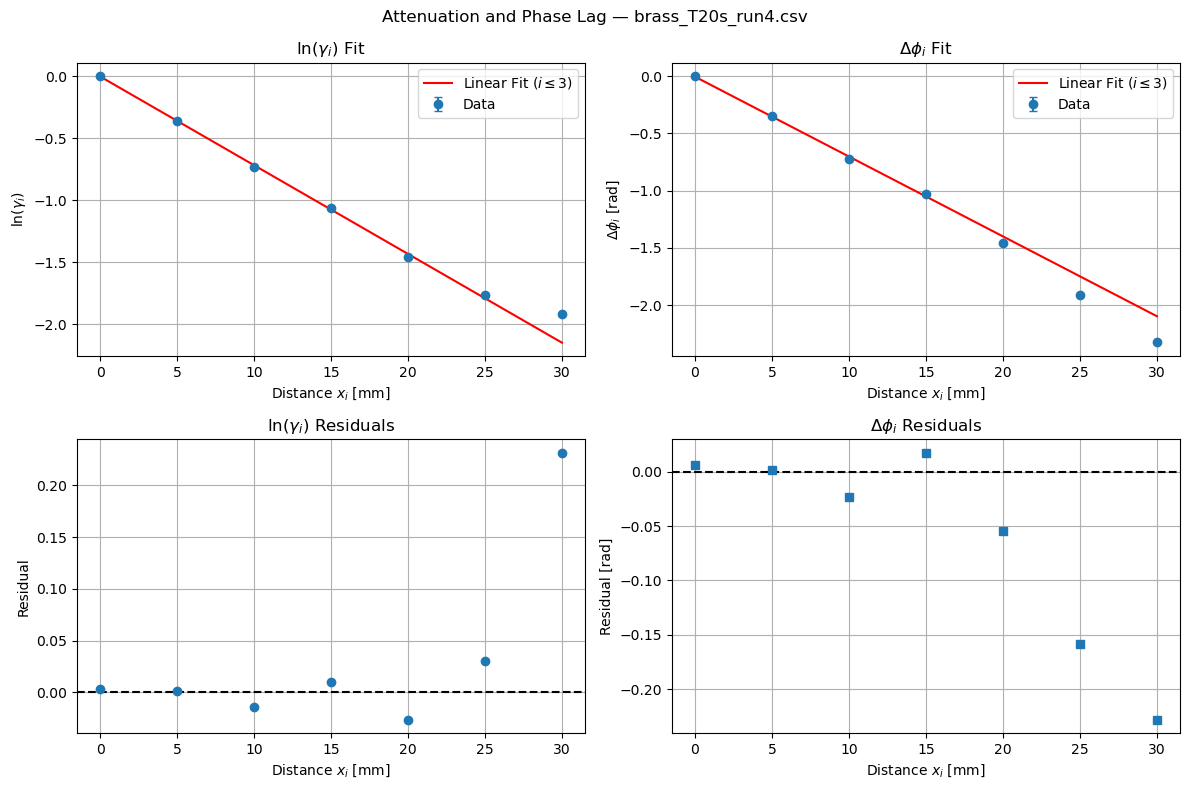

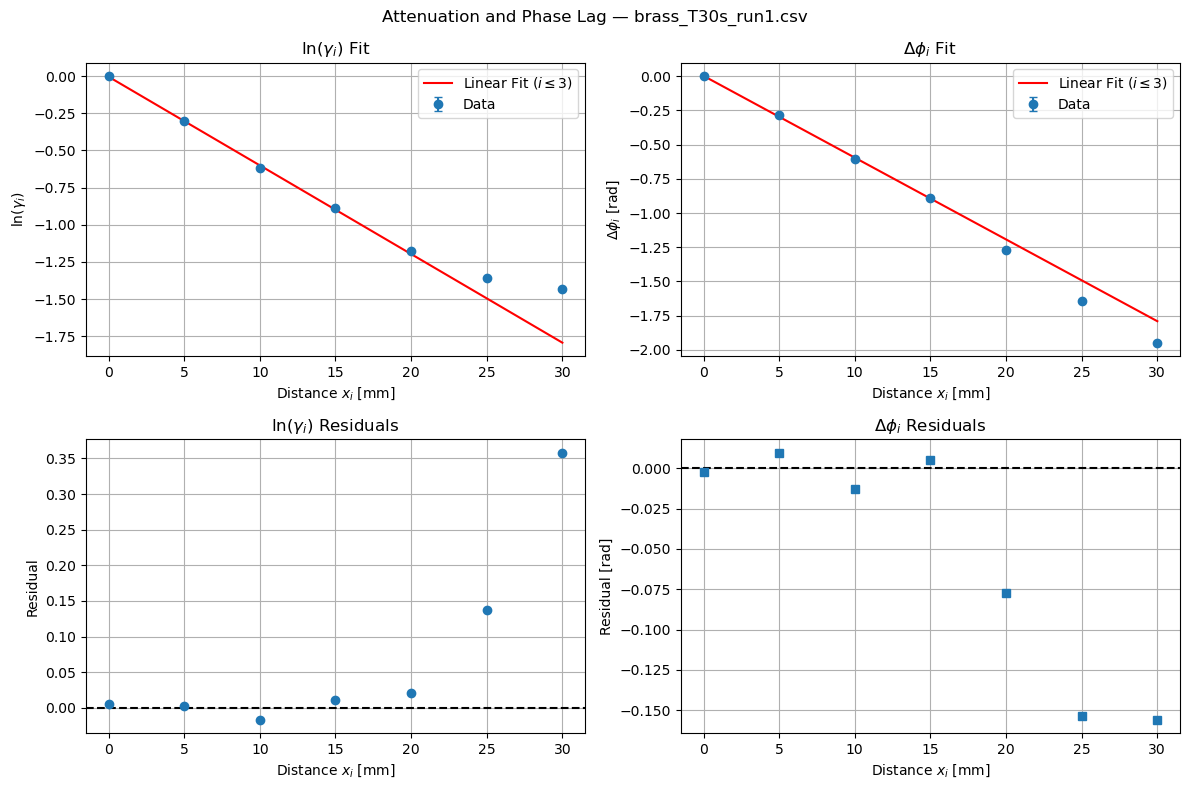

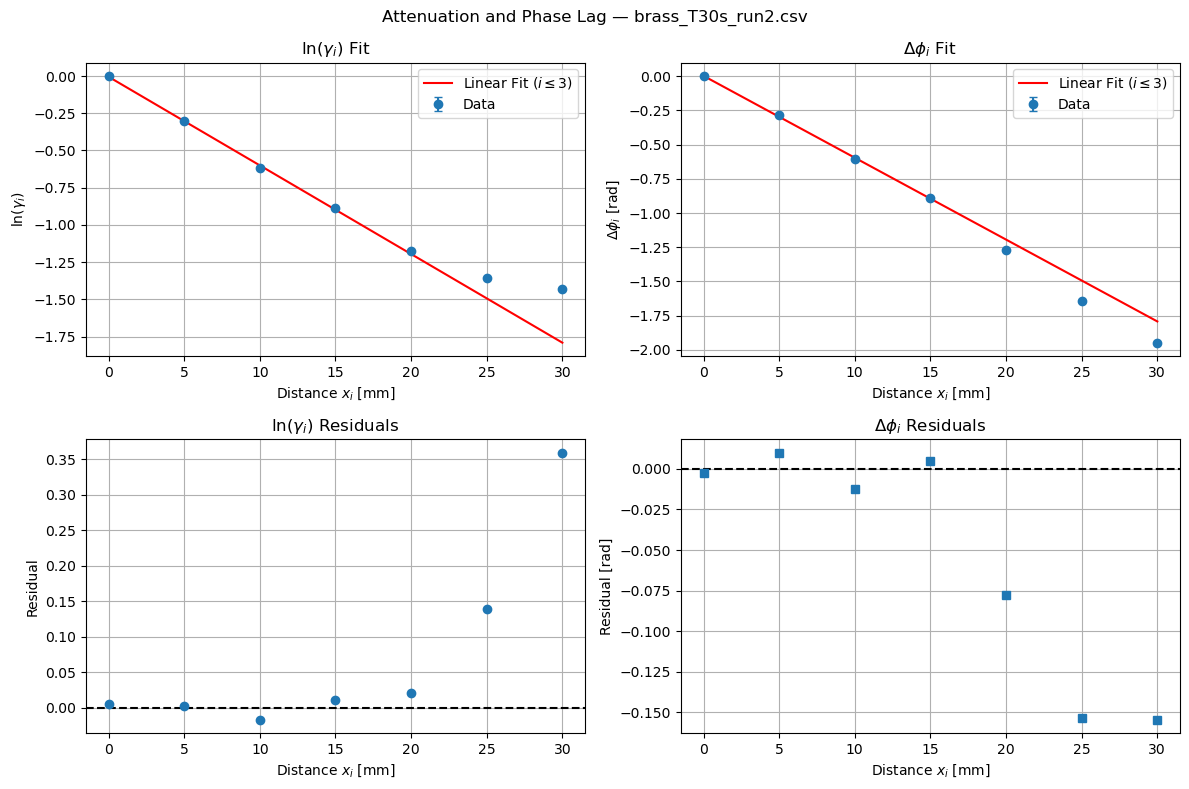

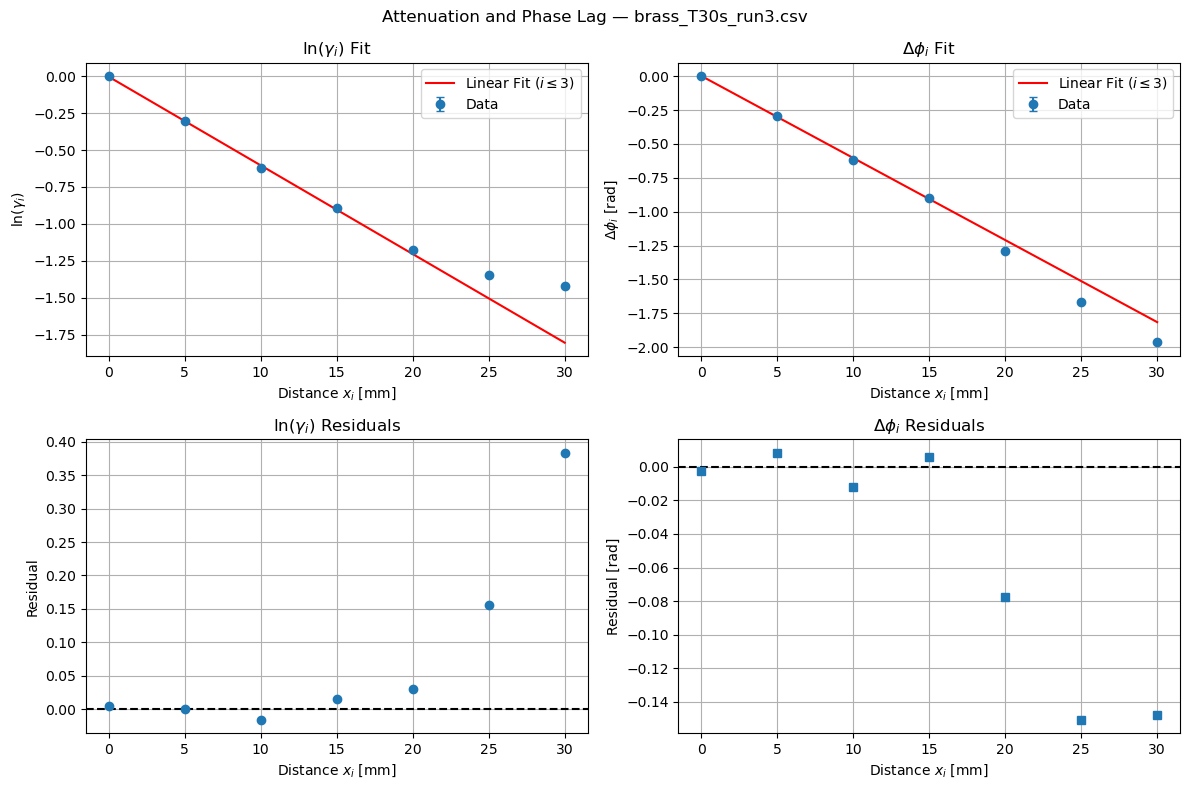

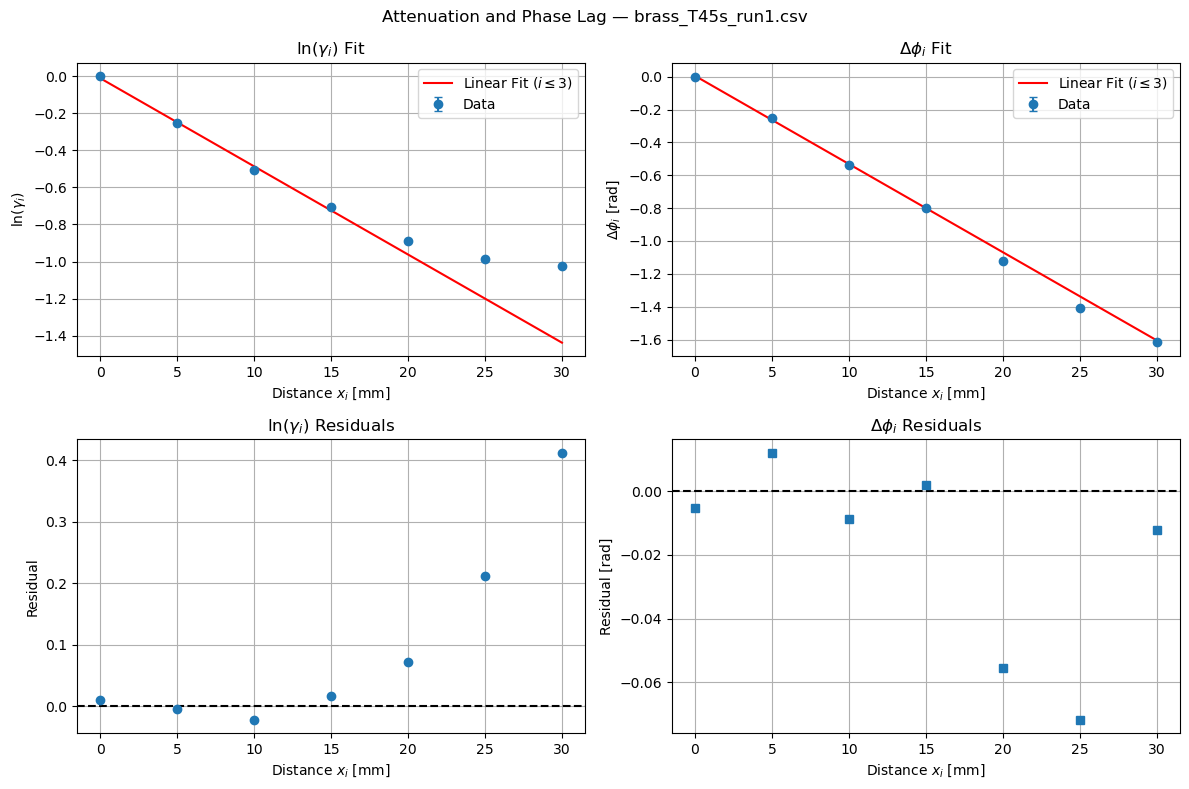

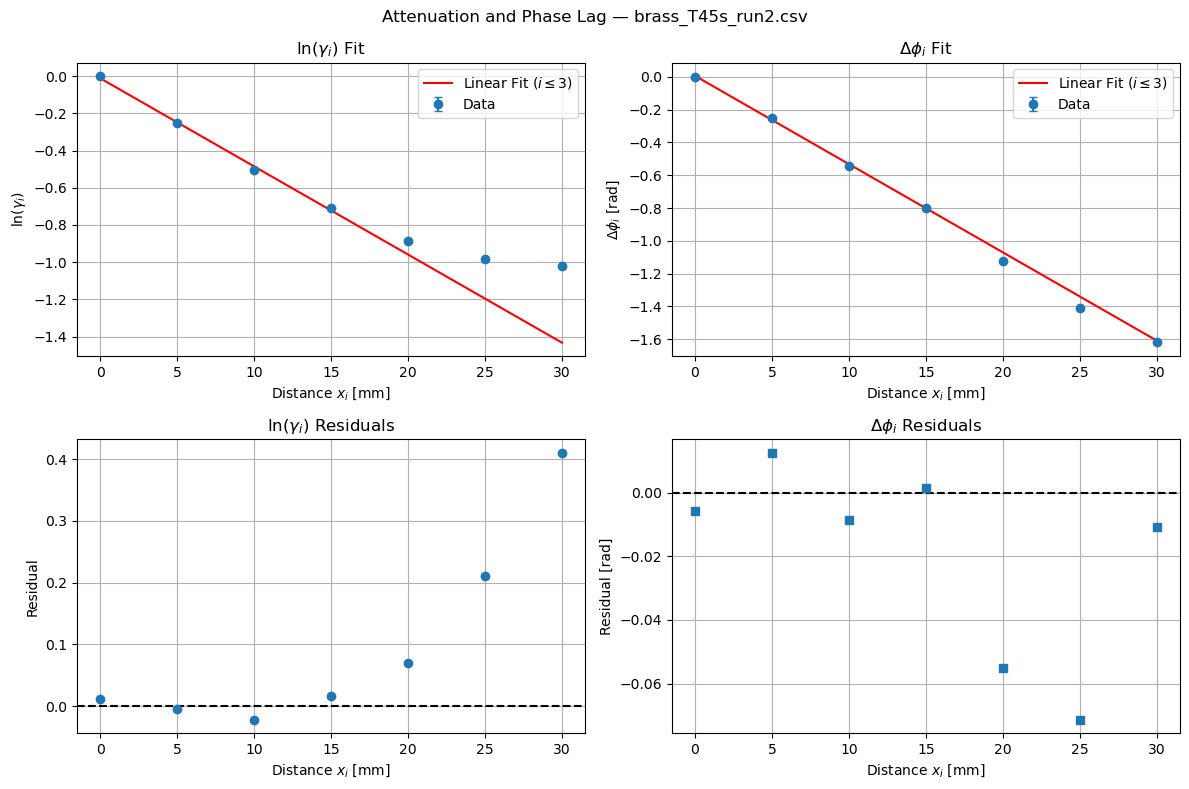

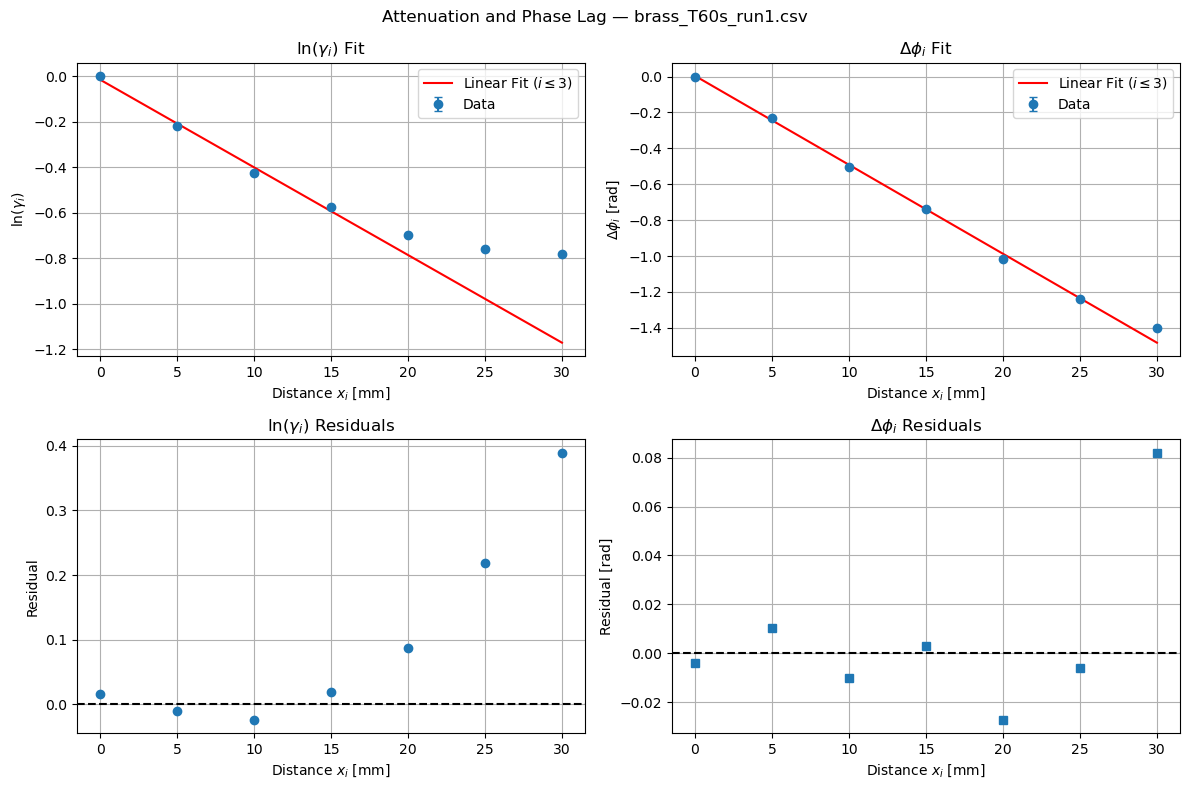

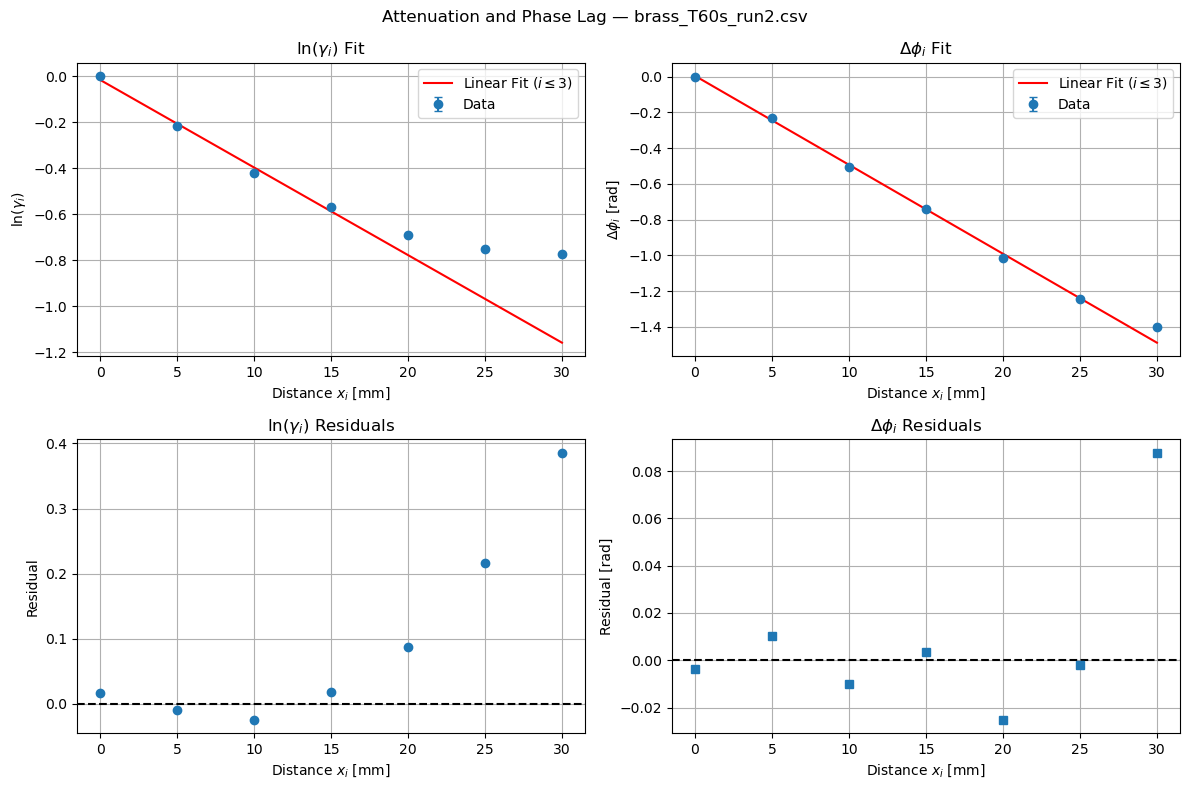

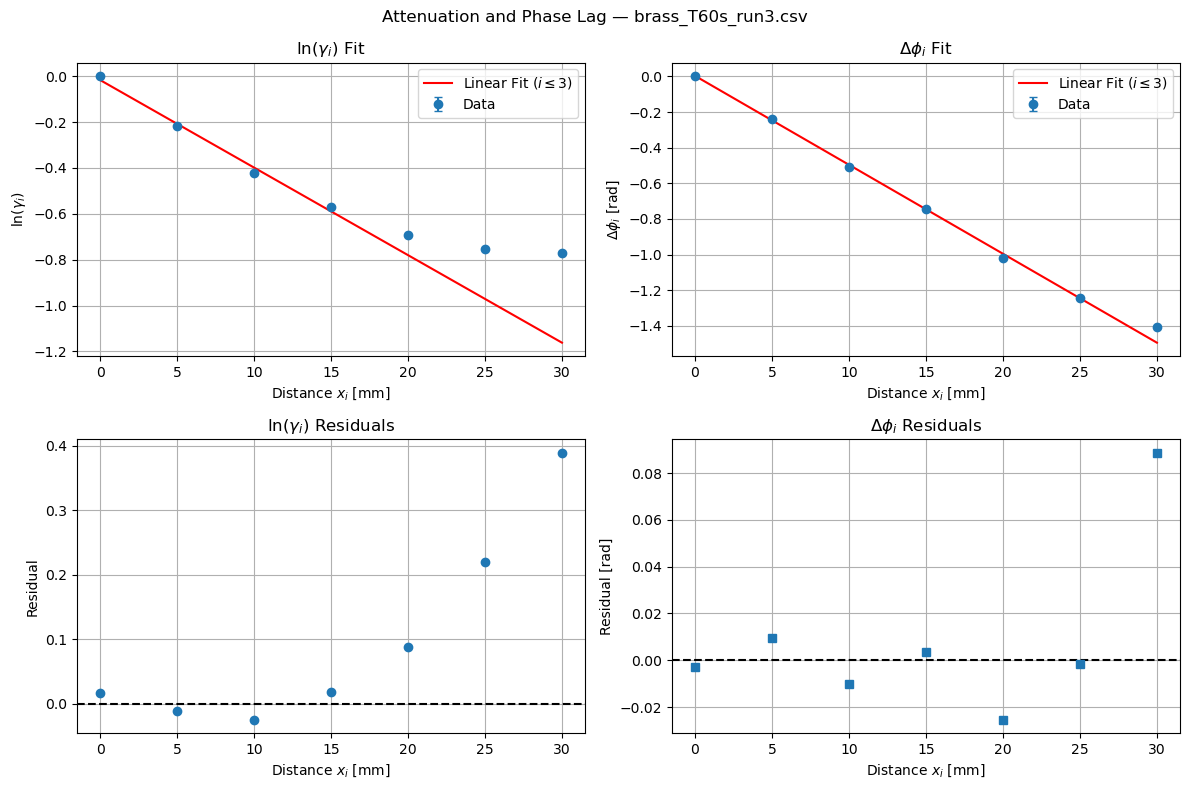

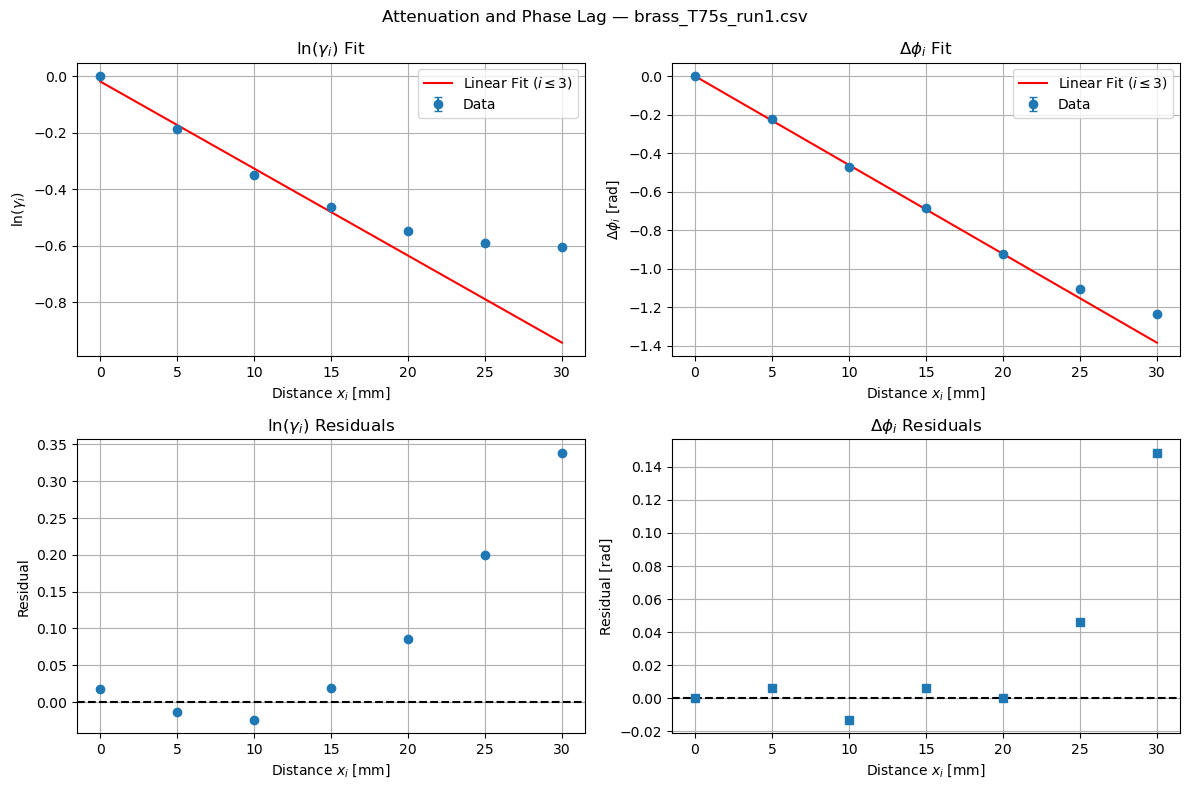

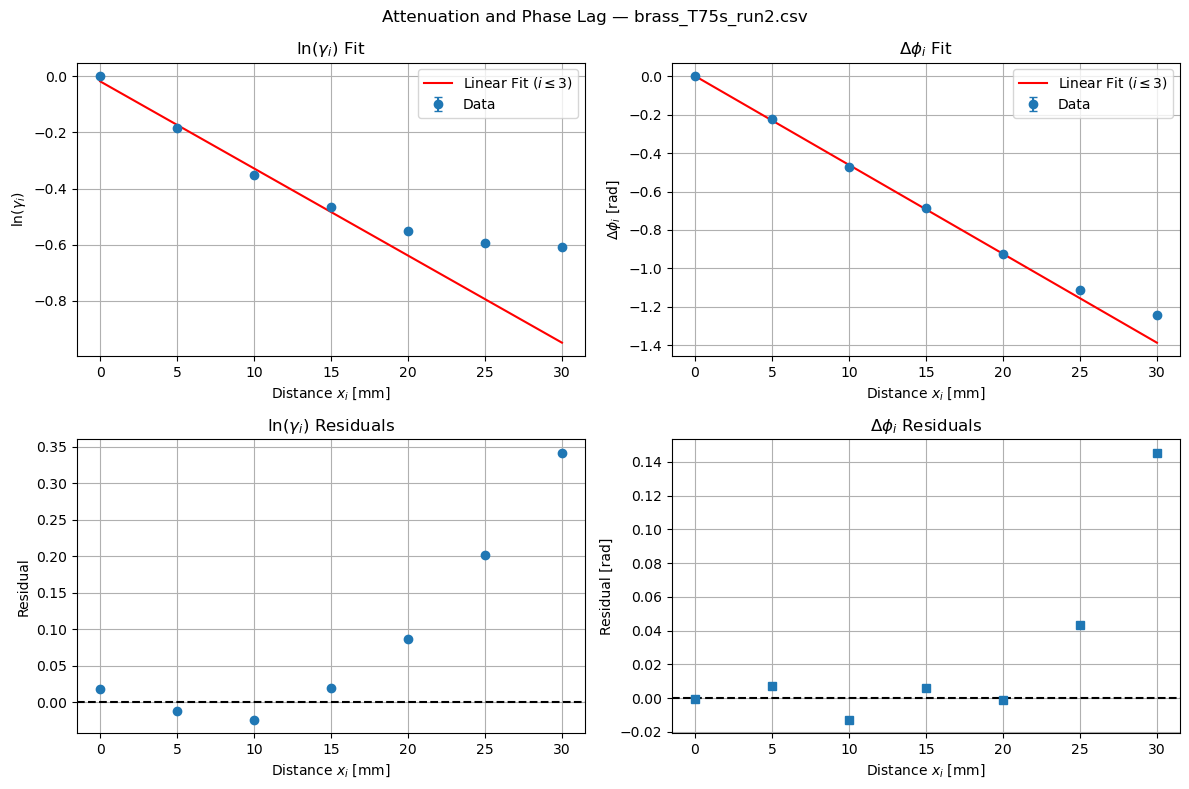

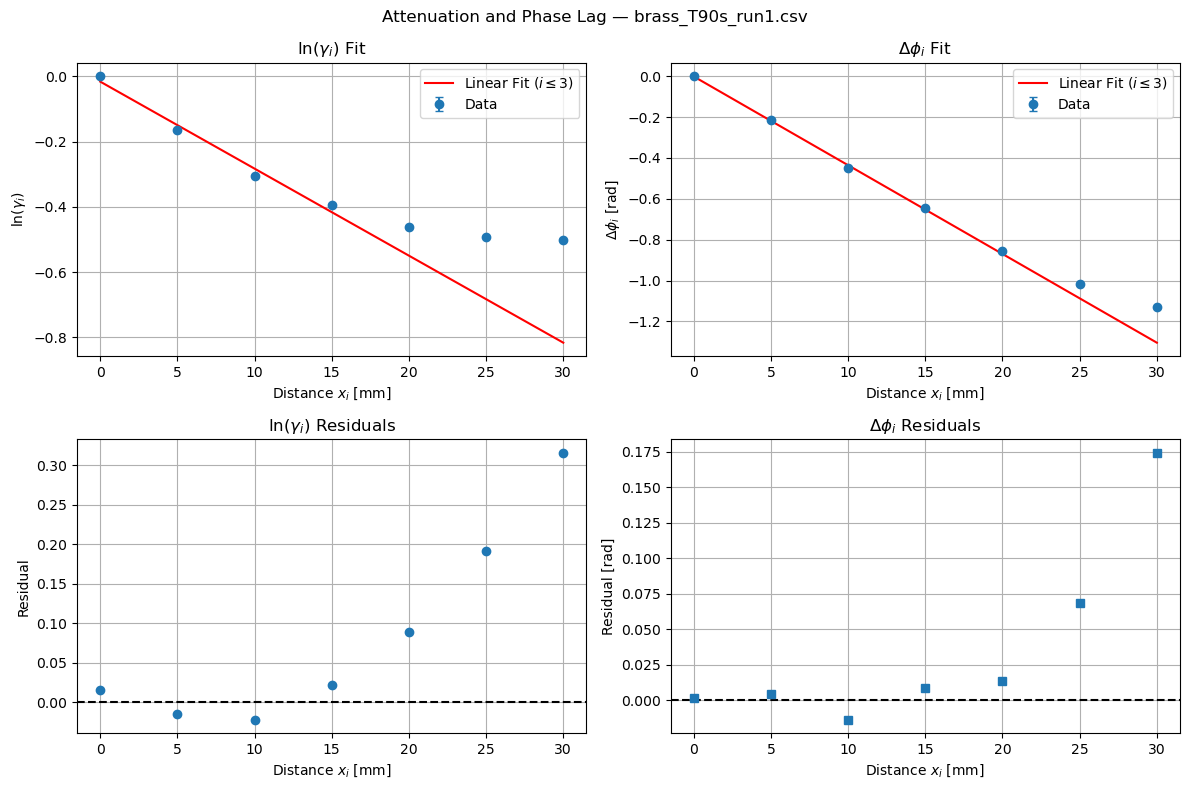

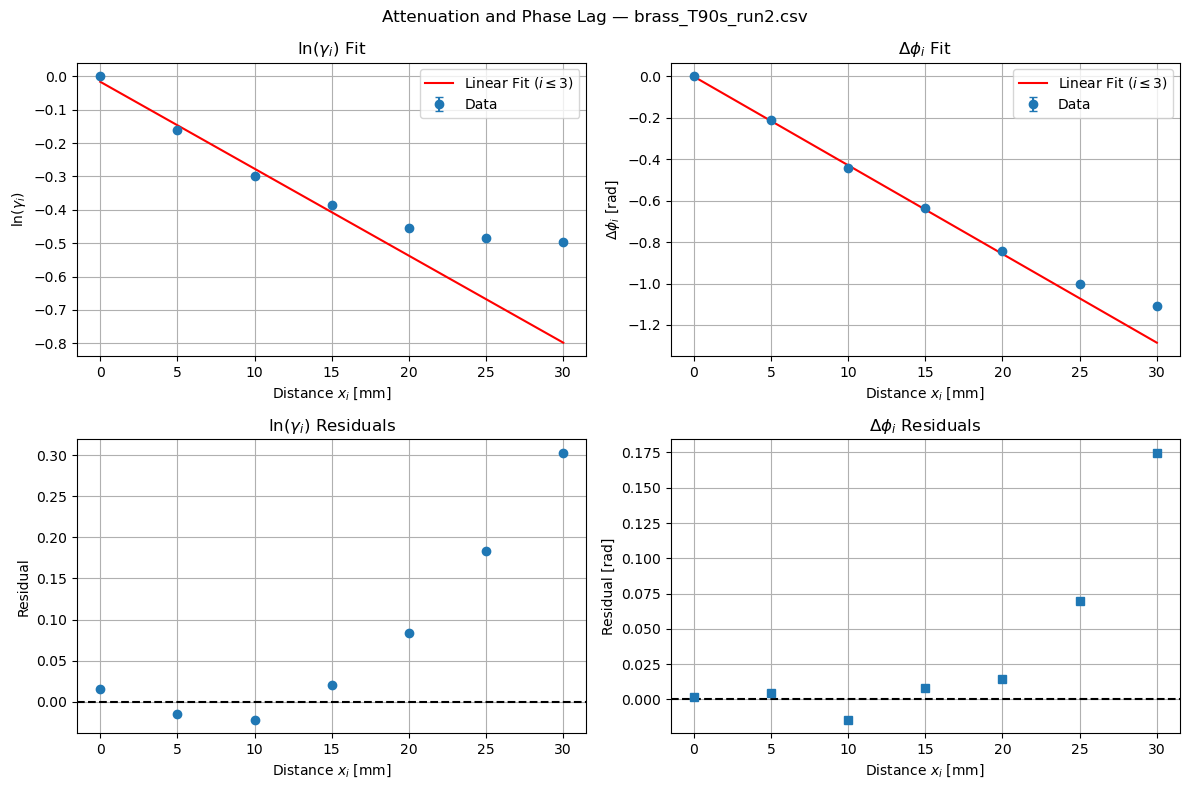

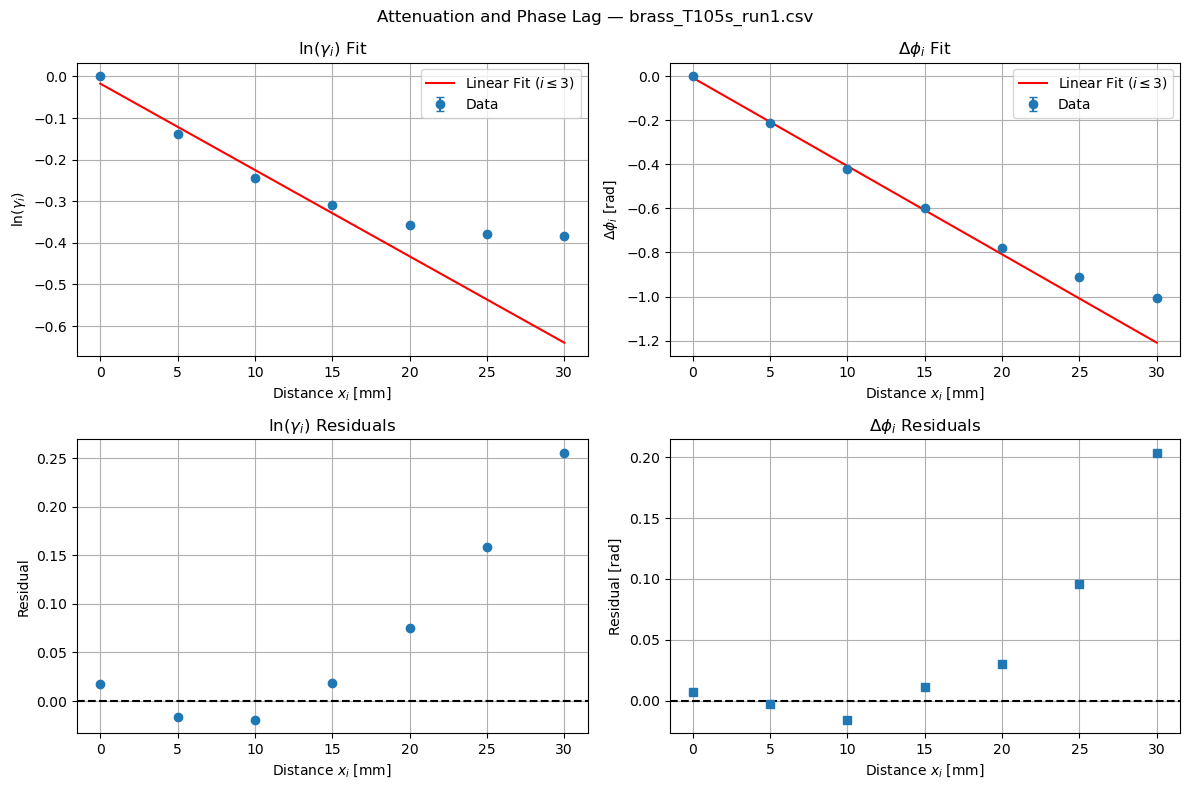

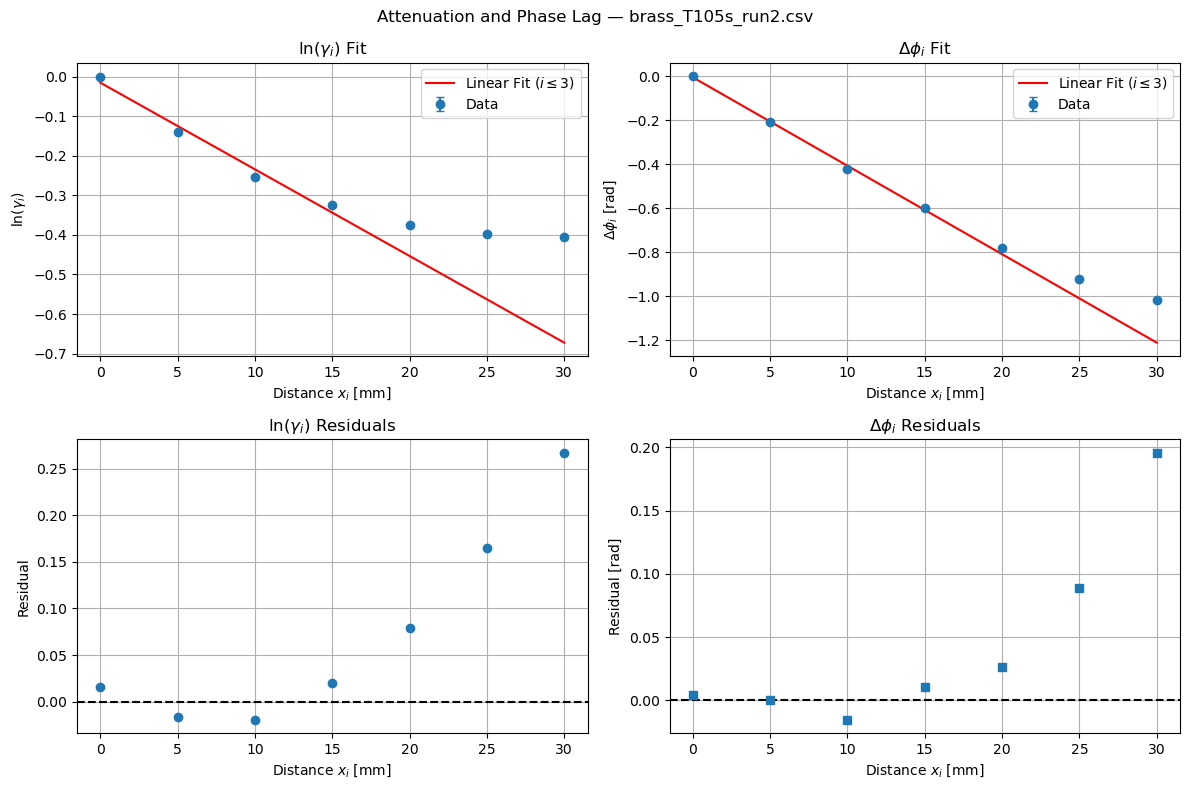

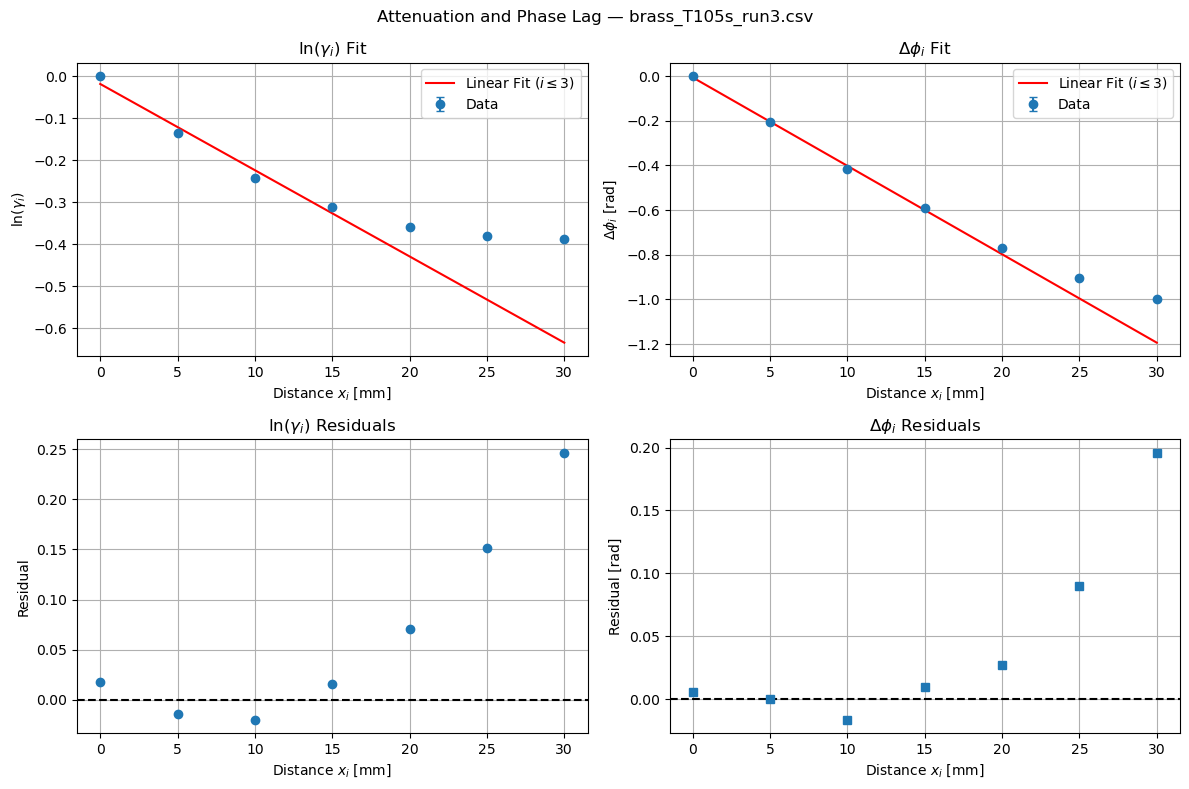

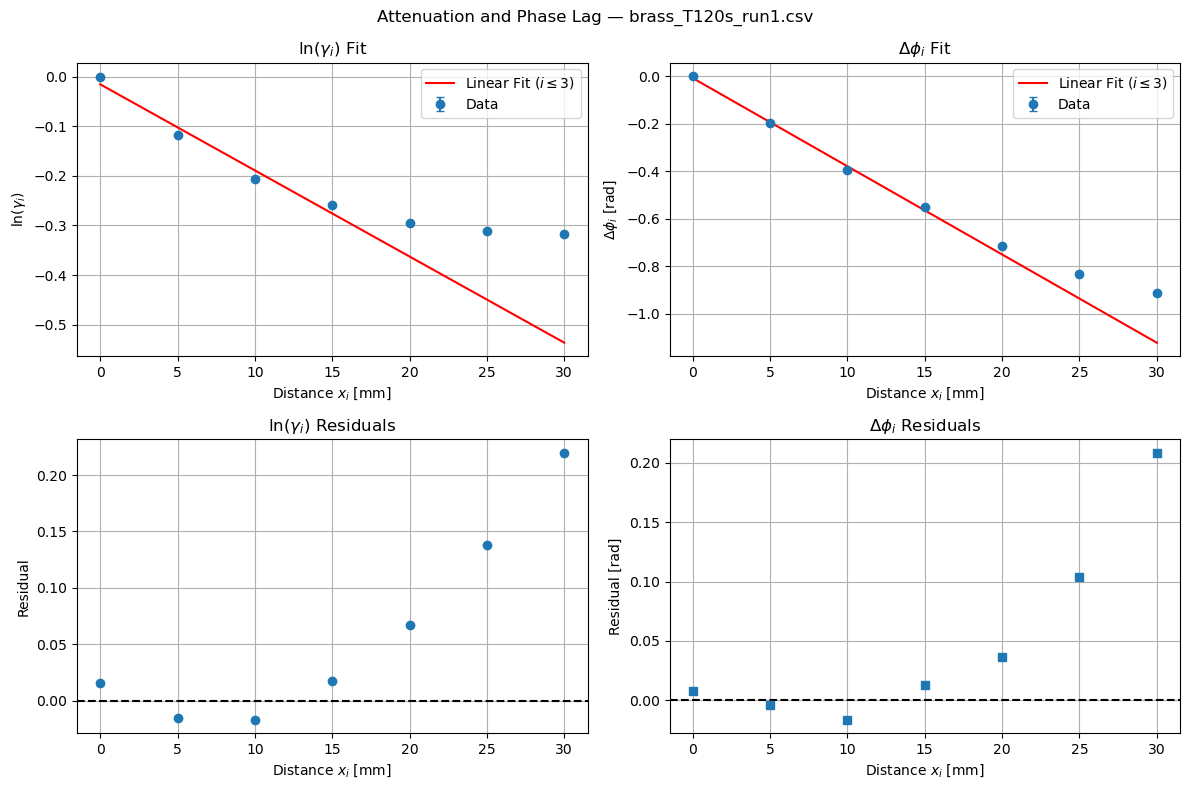

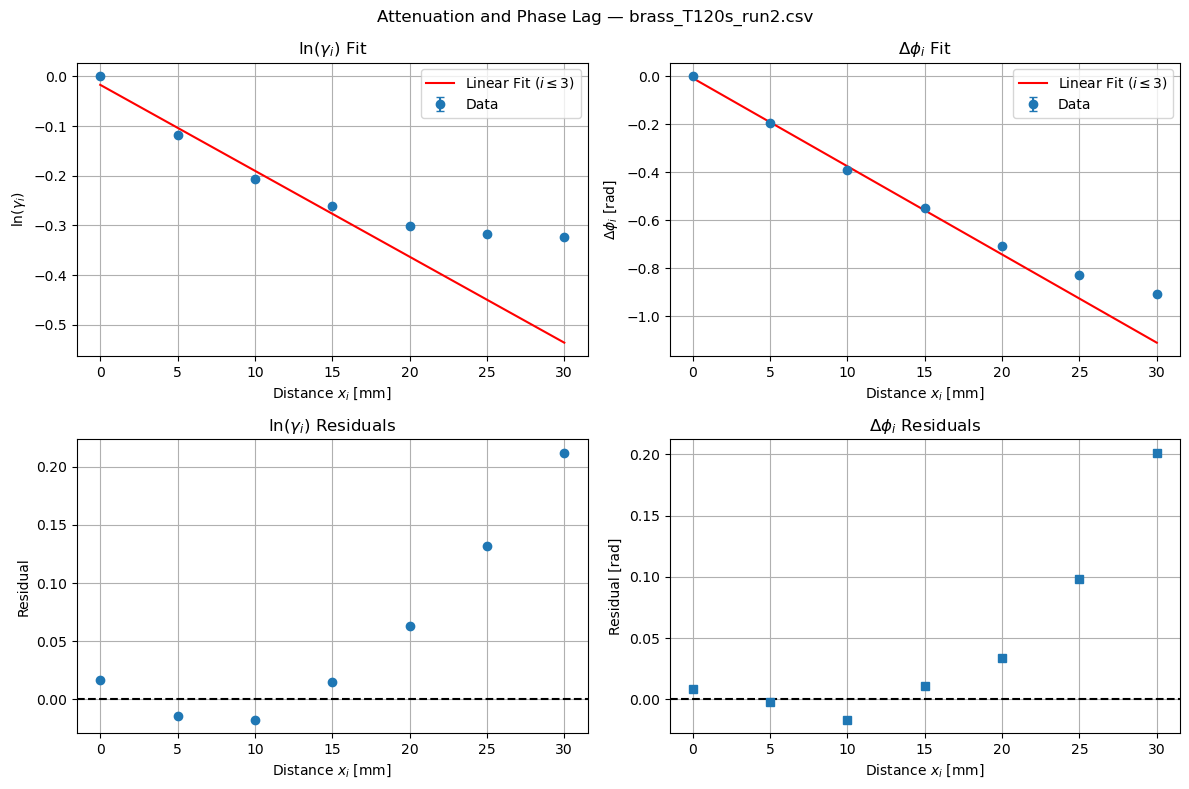

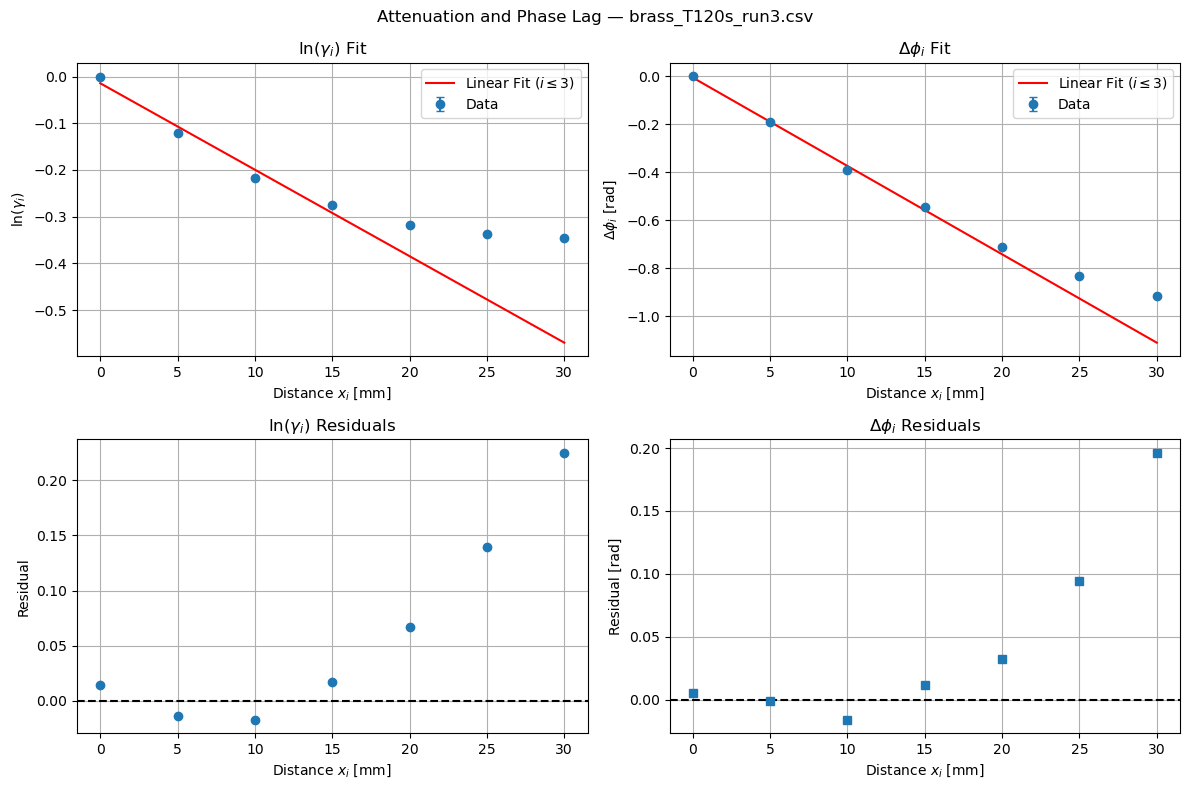

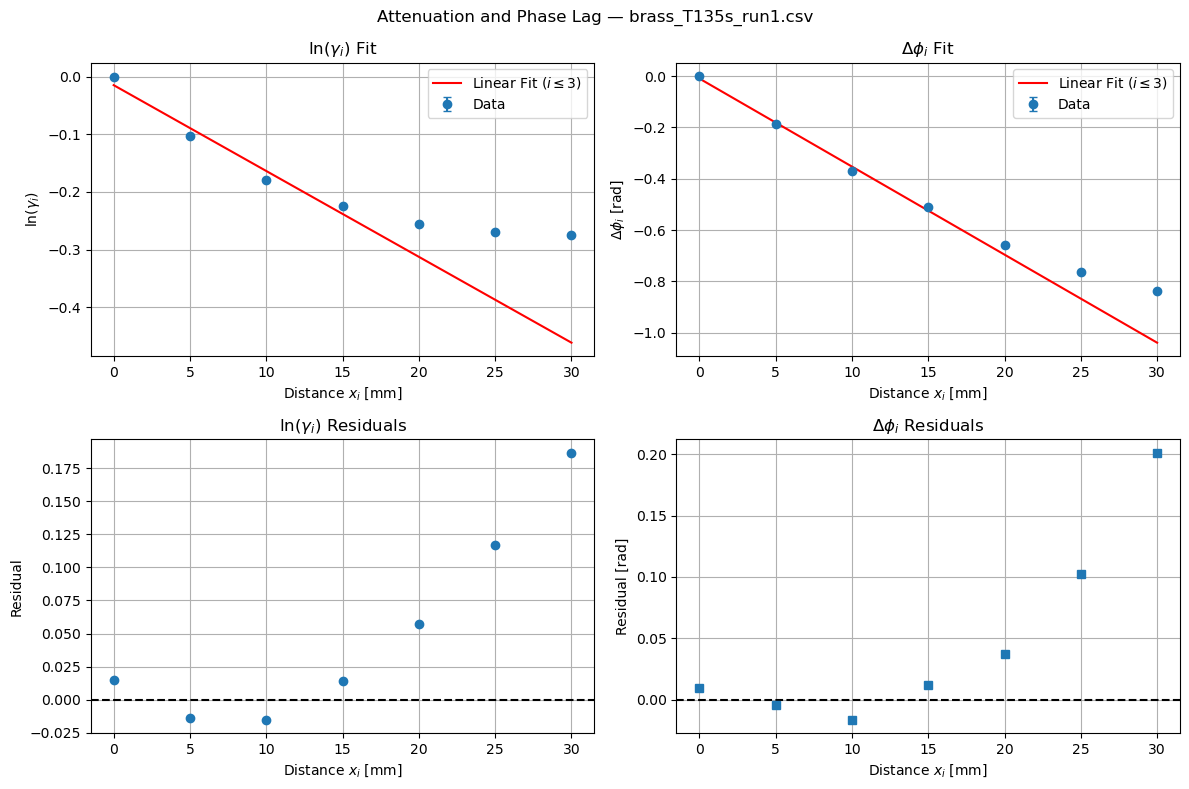

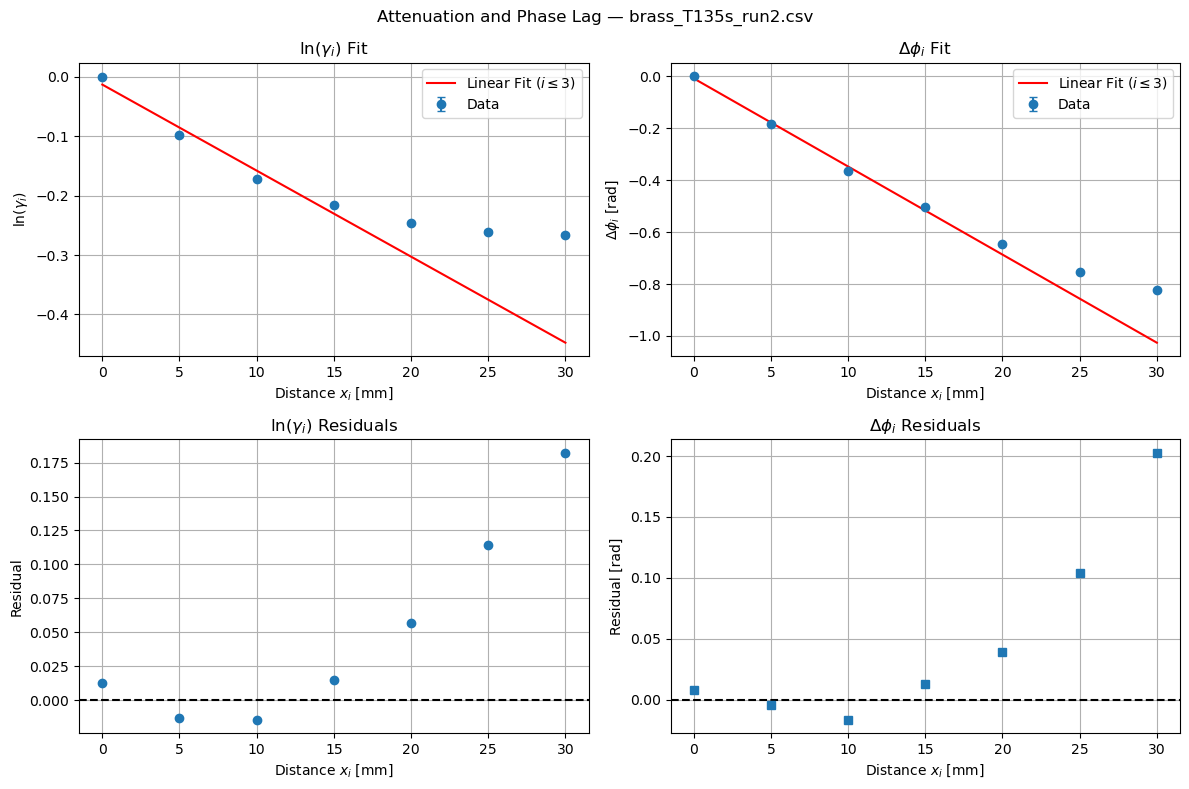

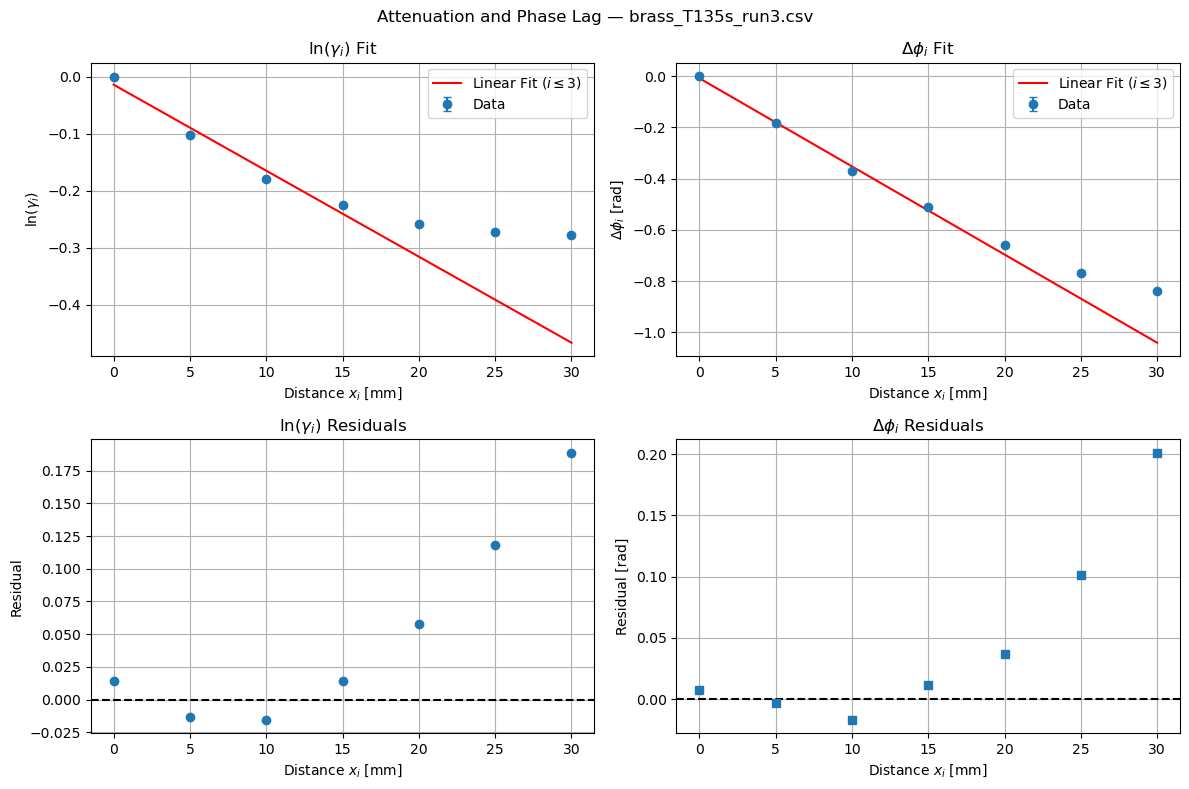

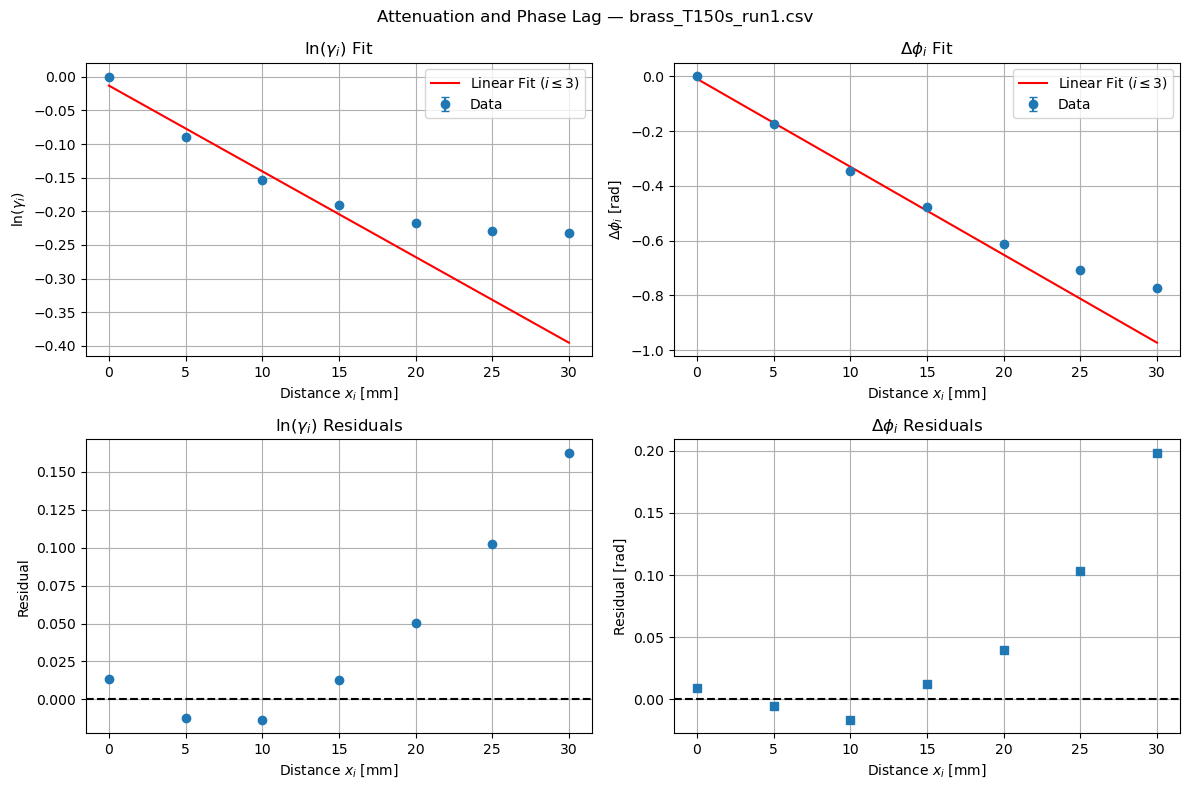

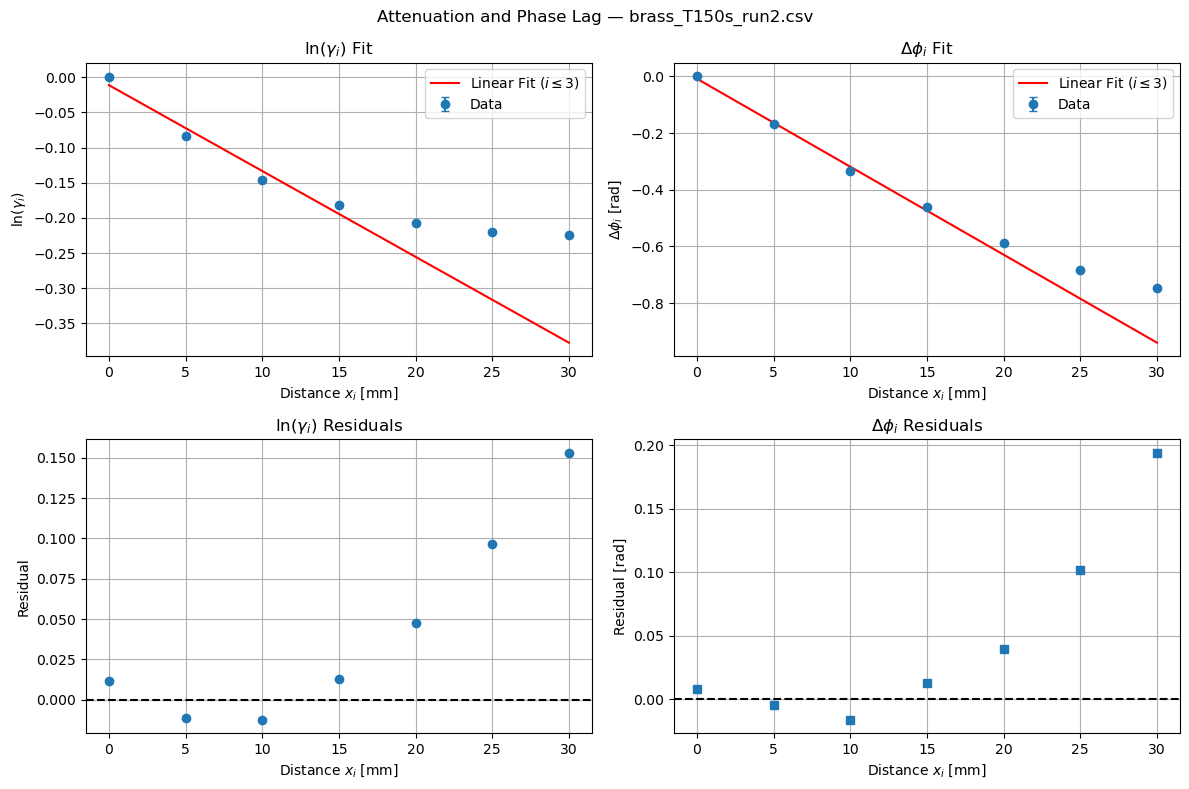

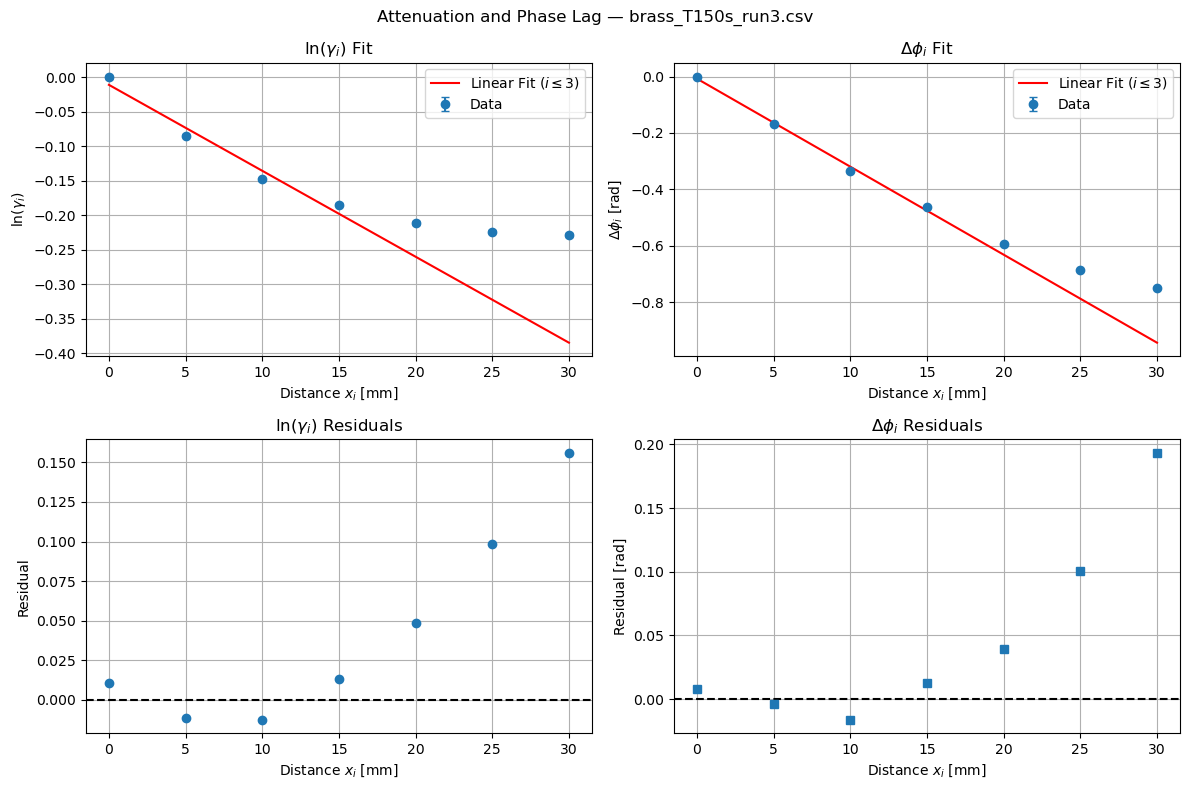

In [214]:
for fname in files:
    path = os.path.join(save_dir, fname)

    # Analyse this dataset
    omega, gamma, unc_gamma, dphi, unc_dphi = analyse_dataset(path)

    n_therm = len(gamma)
    i_vals = np.arange(n_therm)
    x = i_vals * delta_d  # distance in mm

    ln_gamma = np.log(gamma)
    sigma_ln_gamma = unc_gamma / gamma
    
    n_fit_therm = 3

    # Restrict fit up to i = 4 (or up to last available)
    fit_max_index = min(n_fit_therm, n_therm - 1)
    idx_fit = np.arange(fit_max_index + 1)

    x_fit = x[idx_fit]
    ln_gamma_fit = ln_gamma[idx_fit]
    sigma_ln_gamma_fit = sigma_ln_gamma[idx_fit]

    dphi_fit = dphi[idx_fit]
    sigma_dphi_fit = unc_dphi[idx_fit]

    # Fit ln(gamma) using only up to i = fit_max_index
    popt_g, pcov_g = curve_fit(
        linear,
        x_fit,
        ln_gamma_fit,
        sigma=sigma_ln_gamma_fit,
        absolute_sigma=True,
        maxfev=10000
    )
    k_g, c_g = popt_g
    ln_fit_all = linear(x, k_g, c_g)   # model evaluated for all i
    ln_resid = ln_gamma - ln_fit_all   # residuals for all thermistors

    # Fit phase using only up to i = fit_max_index
    popt_p, pcov_p = curve_fit(
        linear,
        x_fit,
        dphi_fit,
        sigma=sigma_dphi_fit,
        absolute_sigma=True,
        maxfev=10000
    )
    k_p, c_p = popt_p
    phi_fit_all = linear(x, k_p, c_p)
    phi_resid = dphi - phi_fit_all

    # Plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # ln(gamma) fit 
    axes[0,0].errorbar(x, ln_gamma, yerr=sigma_ln_gamma,
                       fmt='o', capsize=3, label='Data')
    axes[0,0].plot(x, linear(x, k_g, c_g),
                   'r-', label=f'Linear Fit ($i \,≤ \,{n_fit_therm}$)')
    axes[0,0].set_title("ln($\\gamma_i$) Fit")
    axes[0,0].set_xlabel("Distance $x_i$ [mm]")
    axes[0,0].set_ylabel("ln($\\gamma_i$)")
    axes[0,0].grid(True)
    axes[0,0].legend()

    # ln residuals
    axes[1,0].axhline(0, color='k', linestyle='--')
    axes[1,0].plot(x, ln_resid, 'o')
    axes[1,0].set_title("ln($\\gamma_i$) Residuals")
    axes[1,0].set_xlabel("Distance $x_i$ [mm]")
    axes[1,0].set_ylabel("Residual")
    axes[1,0].grid(True)

    # Δφ fit
    axes[0,1].errorbar(x, dphi, yerr=unc_dphi,
                       fmt='o', capsize=3, label='Data')
    axes[0,1].plot(x, linear(x, k_p, c_p),
                   'r-', label=f'Linear Fit ($i \,≤ \,{n_fit_therm}$)')
    axes[0,1].set_title("$\\Delta\\phi_i$ Fit")
    axes[0,1].set_xlabel("Distance $x_i$ [mm]")
    axes[0,1].set_ylabel("$\\Delta\\phi_i$ [rad]")
    axes[0,1].grid(True)
    axes[0,1].legend()

    # Δφ residuals
    axes[1,1].axhline(0, color='k', linestyle='--')
    axes[1,1].plot(x, phi_resid, 's')
    axes[1,1].set_title("$\\Delta\\phi_i$ Residuals")
    axes[1,1].set_xlabel("Distance $x_i$ [mm]")
    axes[1,1].set_ylabel("Residual [rad]")
    axes[1,1].grid(True)

    plt.suptitle(f"Attenuation and Phase Lag — {fname}")
    plt.tight_layout()
    plt.show()


Here we have only used the first four thermistors for the fitted line. We then calculate the residuals using this fit to more accurately determine at what point our model breaks down. Again, it looks like for the thermistors close to the end of the cylinder both the attenuation factor and phase lag are greater that predicted by the model. This effect increases as the driving time period increases, which is to be expected when considering the thermal penetration depth.

In [215]:
# period_results[tau] will hold a list of (omega, gamma, unc_gamma, dphi, unc_dphi) for each run
period_results = defaultdict(list)

for fname in files:
    path = os.path.join(save_dir, fname)

    omega, gamma, unc_gamma, dphi, unc_dphi = analyse_dataset(path)

    # Convert ω -> period τ so we can group runs
    tau = 2 * np.pi / omega

    period_results[tau].append((omega, gamma, unc_gamma, dphi, unc_dphi))

# Dictionary to hold averaged quantities per period
period_avg = {}

for tau, runs in sorted(period_results.items()):
    # Unpack lists of arrays
    omegas, gammas, unc_gammas, dphis, unc_dphis = zip(*runs)

    omegas     = np.array(omegas)       # shape (n_runs,)
    gammas     = np.stack(gammas)       # shape (n_runs, n_therm)
    unc_gammas = np.stack(unc_gammas)   # shape (n_runs, n_therm)
    dphis      = np.stack(dphis)        # shape (n_runs, n_therm)
    unc_dphis  = np.stack(unc_dphis)    # shape (n_runs, n_therm)

    n_runs, n_therm = gammas.shape

    # Mean omega (they should all be the same for a given tau)
    omega_mean = float(np.mean(omegas))

    # --- Mean values over runs ---
    gamma_mean = gammas.mean(axis=0)
    dphi_mean  = dphis.mean(axis=0)

    # --- Statistical uncertainty from multiple runs ---
    if n_runs > 1:
        # variance of the mean: s^2 / n
        gamma_stat_var = gammas.var(axis=0, ddof=1) / n_runs
        dphi_stat_var  = dphis.var(axis=0, ddof=1)  / n_runs
    else:
        # with only one run, no scatter info
        gamma_stat_var = np.zeros(n_therm)
        dphi_stat_var  = np.zeros(n_therm)

    # --- Measurement uncertainty from fit errors ---
    # Each run r has uncertainty σ_{r,i}; variance of the mean = (1/n^2) * Σ_r σ_{r,i}^2
    gamma_meas_var = (unc_gammas**2).sum(axis=0) / (n_runs**2)
    dphi_meas_var  = (unc_dphis**2).sum(axis=0)  / (n_runs**2)

    # --- Total uncertainty on the mean (stat + meas in quadrature) ---
    gamma_tot_var = gamma_stat_var + gamma_meas_var
    dphi_tot_var  = dphi_stat_var  + dphi_meas_var

    gamma_unc = np.sqrt(gamma_tot_var)
    dphi_unc  = np.sqrt(dphi_tot_var)

    # Store results for this period
    period_avg[tau] = {
        "omega": omega_mean,
        "gamma_mean": gamma_mean,
        "gamma_unc": gamma_unc,
        "dphi_mean": dphi_mean,
        "dphi_unc": dphi_unc,
        "n_runs": n_runs,
    }

# Example: inspect one period
for tau, vals in sorted(period_avg.items()):
    print(f"T = {tau:.0f} s, {vals['n_runs']} run(s)")
    print("  gamma_mean:", vals["gamma_mean"])
    print("  gamma_unc :", vals["gamma_unc"])
    print("  dphi_mean :", vals["dphi_mean"])
    print("  dphi_unc  :", vals["dphi_unc"])
    print()


T = 10 s, 3 run(s)
  gamma_mean: [1.         0.60437921 0.36290092 0.23369457 0.13563515 0.08116314
 0.05443542]
  gamma_unc : [0.00116968 0.00125526 0.00068061 0.00053432 0.00052682 0.00055639
 0.00070237]
  dphi_mean : [ 0.         -0.50829439 -1.05143393 -1.4599986  -1.97844633 -2.52167993
 -3.1268781 ]
  dphi_unc  : [0.00117765 0.00293093 0.00164379 0.00274886 0.00531213 0.00992958
 0.01277127]

T = 15 s, 3 run(s)
  gamma_mean: [1.         0.66501581 0.43661338 0.30064339 0.1898169  0.12793812
 0.10003642]
  gamma_unc : [0.00096555 0.00180746 0.00107919 0.00091925 0.00059688 0.00051057
 0.000789  ]
  dphi_mean : [ 0.         -0.40832732 -0.84180565 -1.1806484  -1.62798927 -2.12050257
 -2.6225084 ]
  dphi_unc  : [0.00097698 0.00282407 0.00251151 0.00407525 0.0070267  0.00916268
 0.00964835]

T = 20 s, 4 run(s)
  gamma_mean: [1.         0.69757493 0.48016923 0.3438947  0.23199766 0.17225035
 0.14784327]
  gamma_unc : [0.00073479 0.00056308 0.0006184  0.00072213 0.0009034  0.00105411


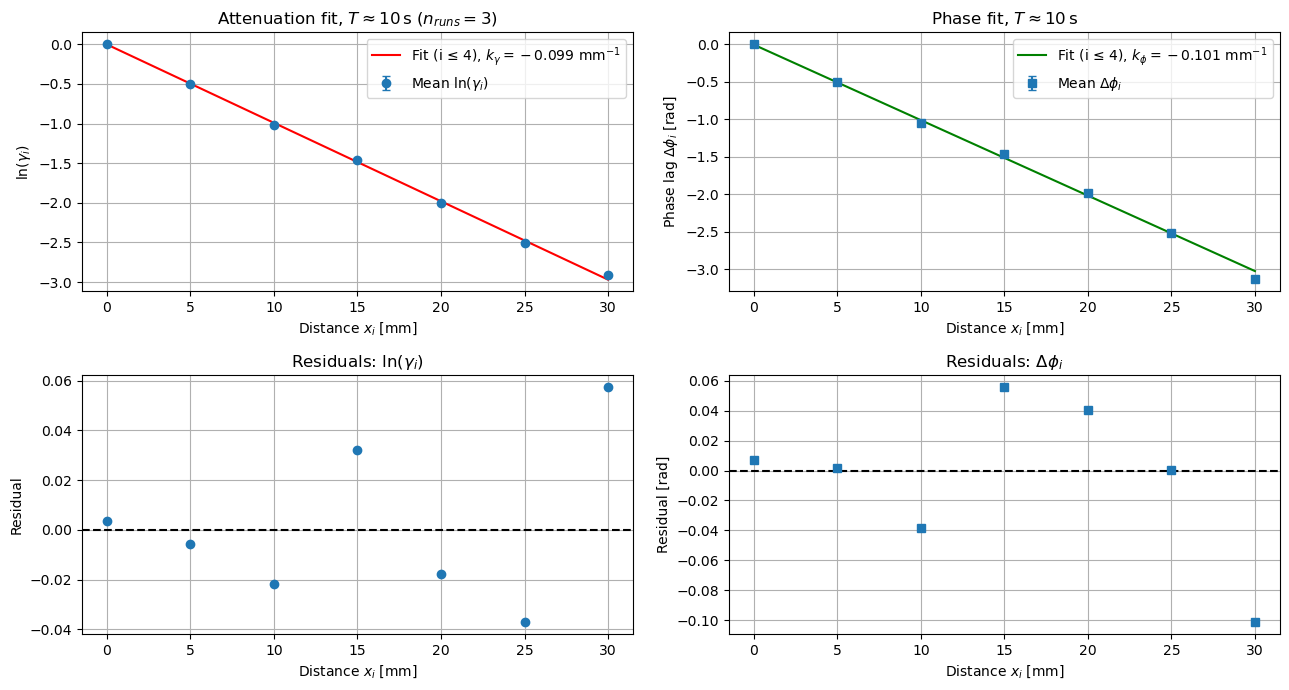

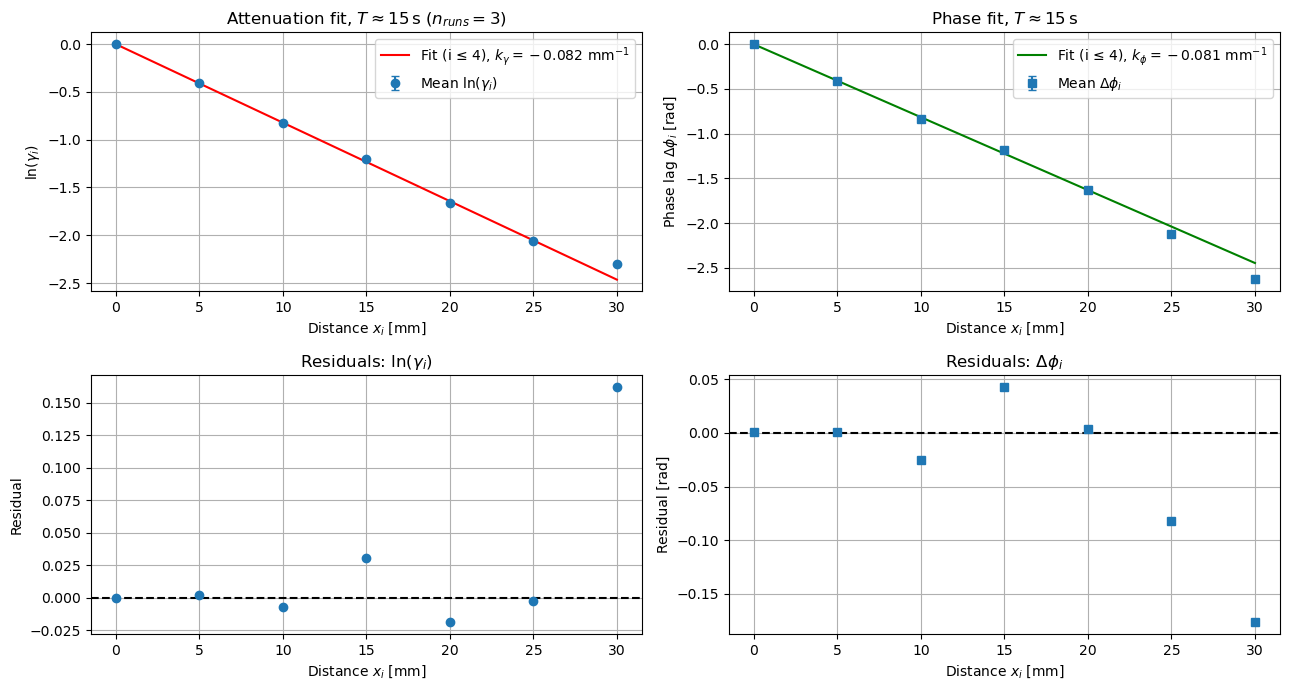

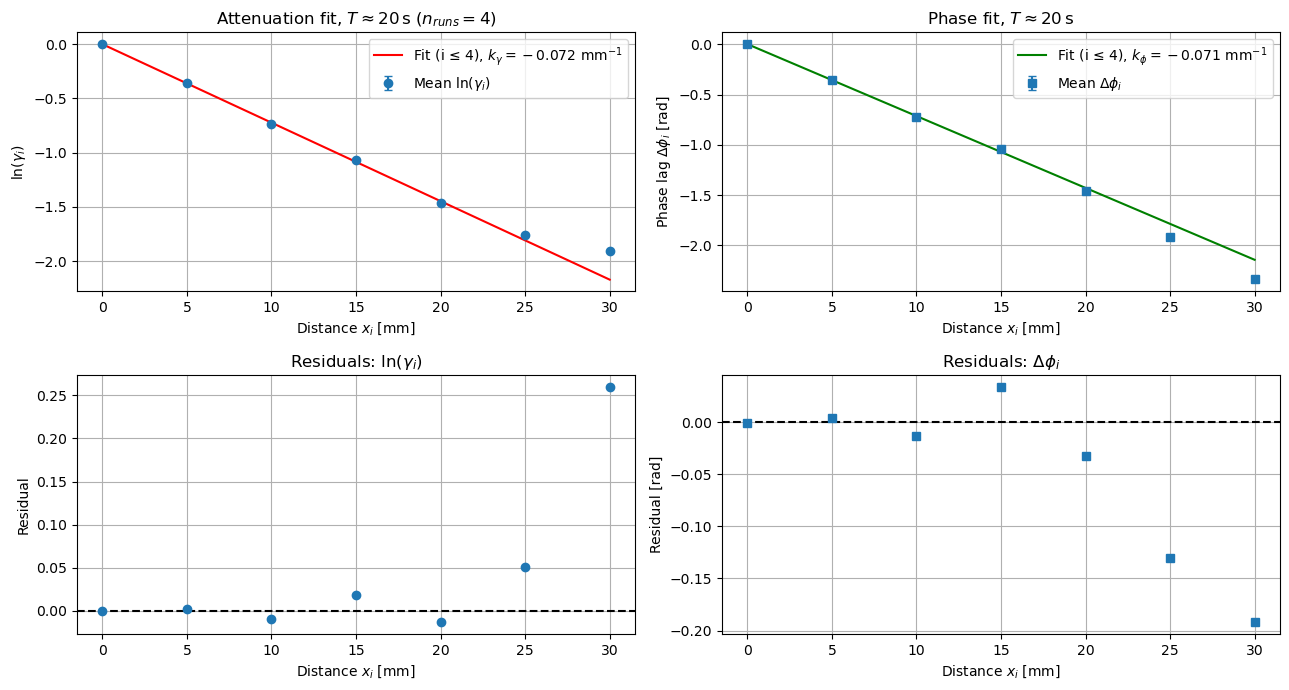

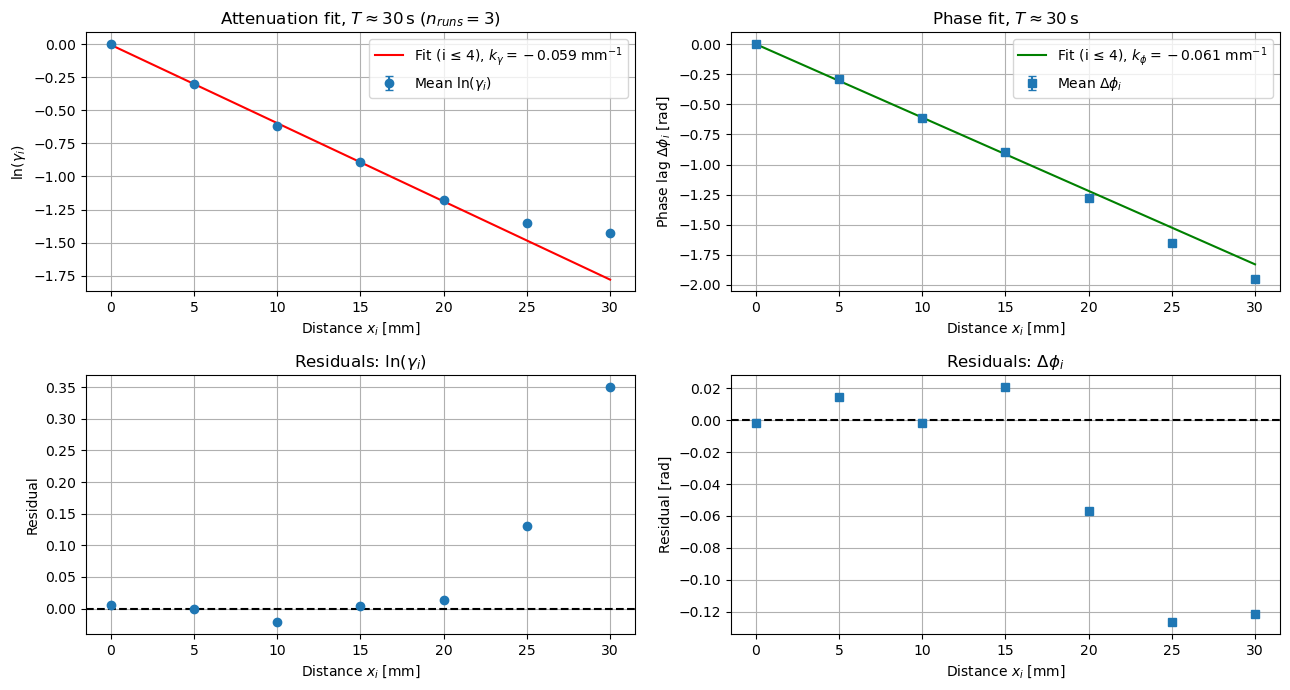

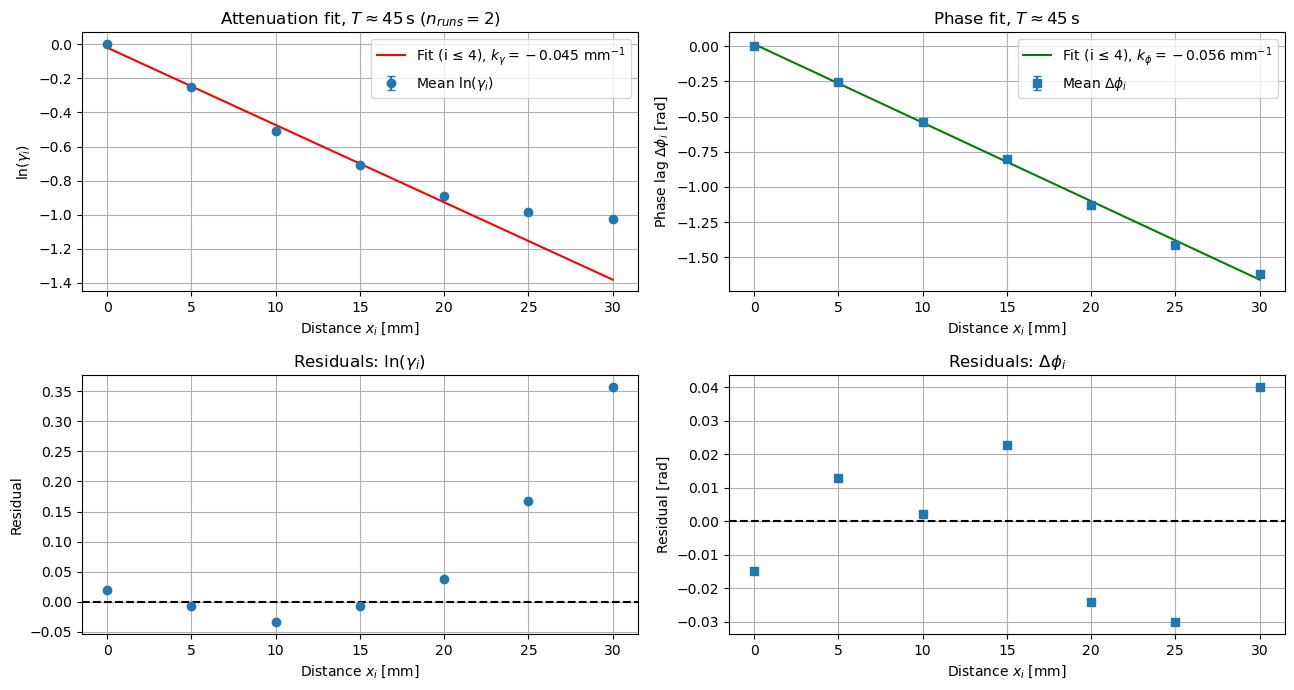

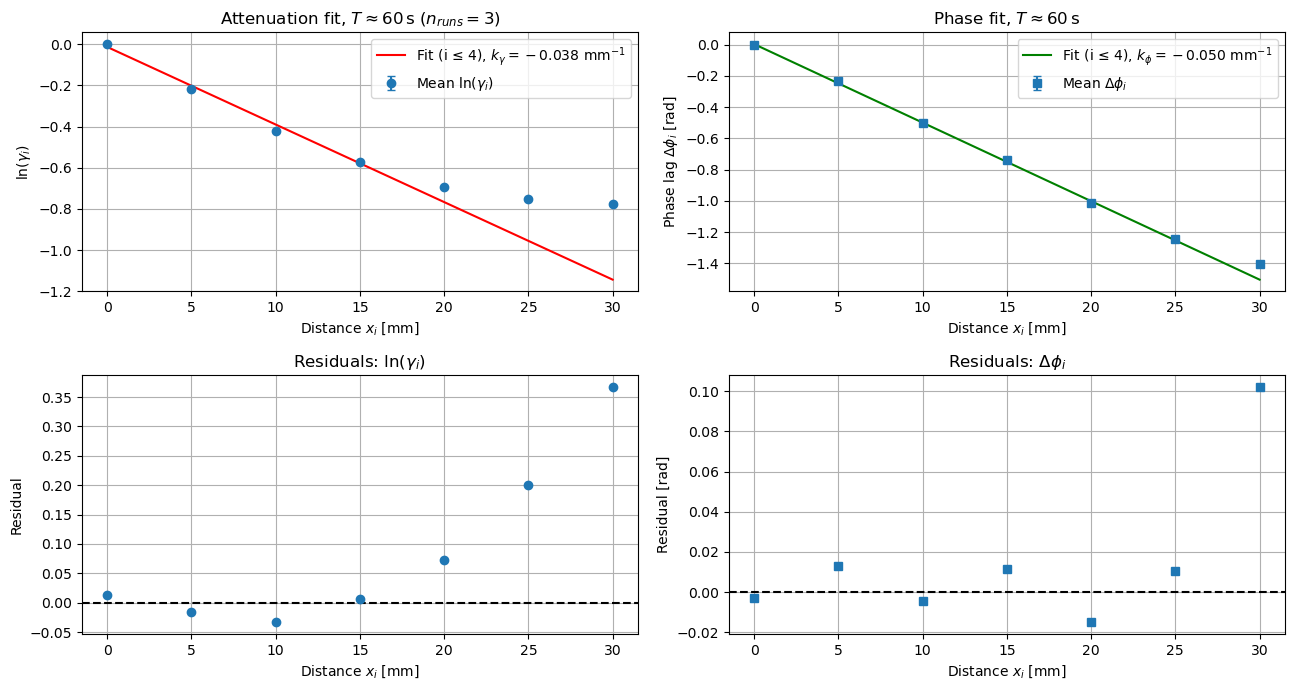

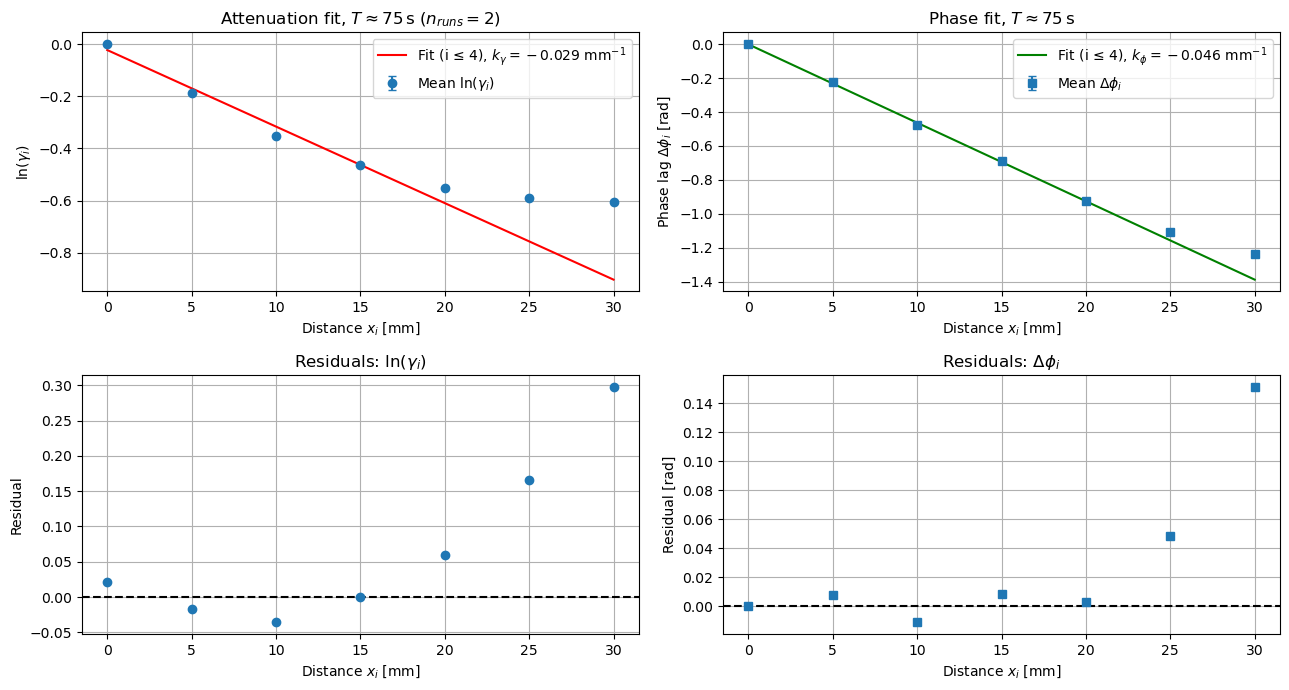

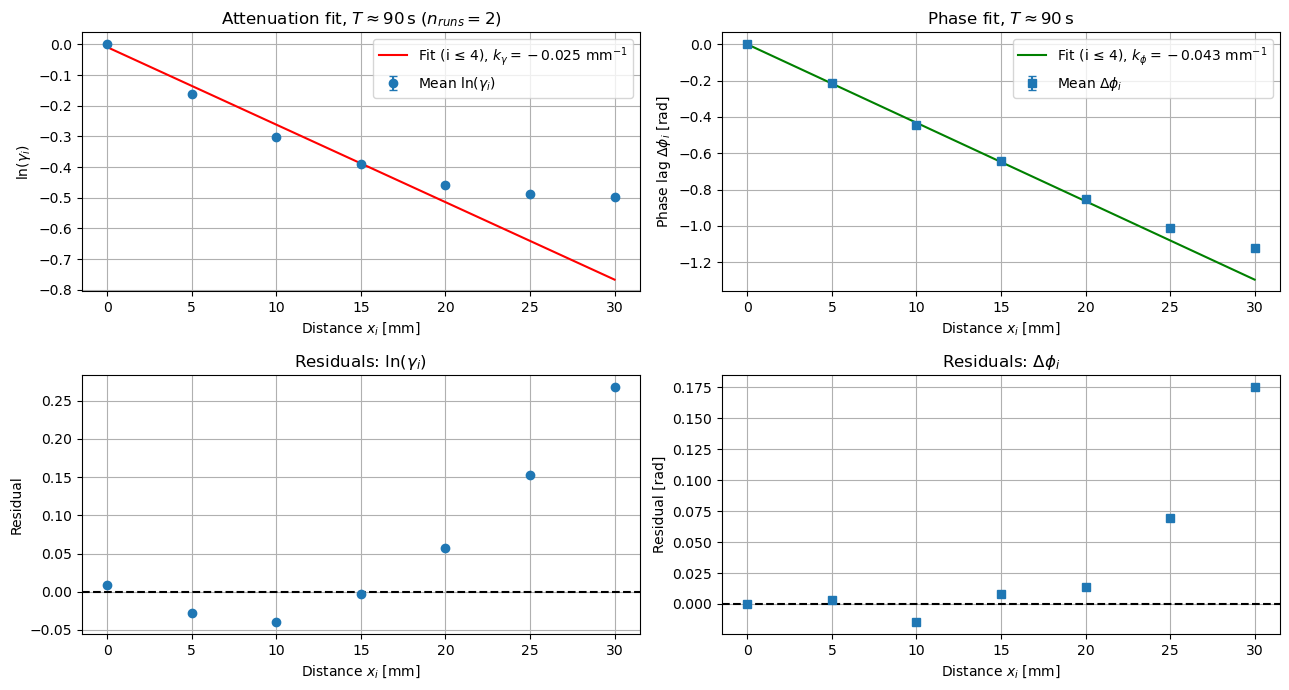

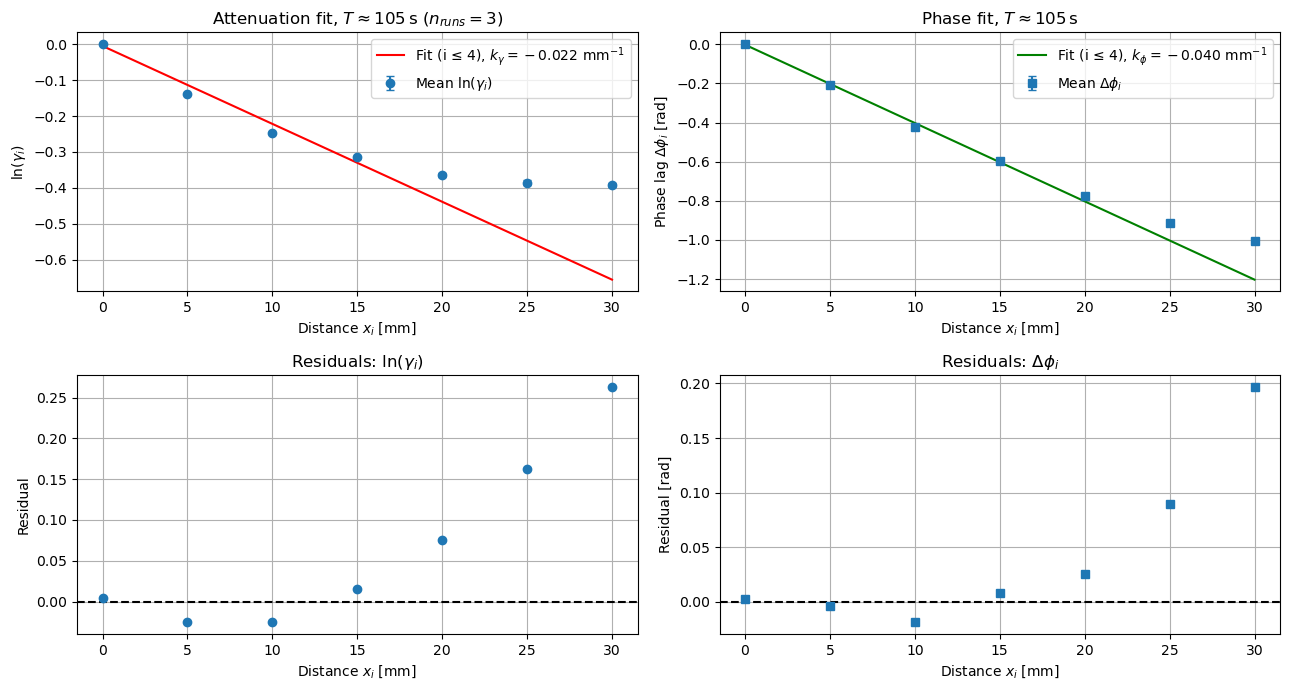

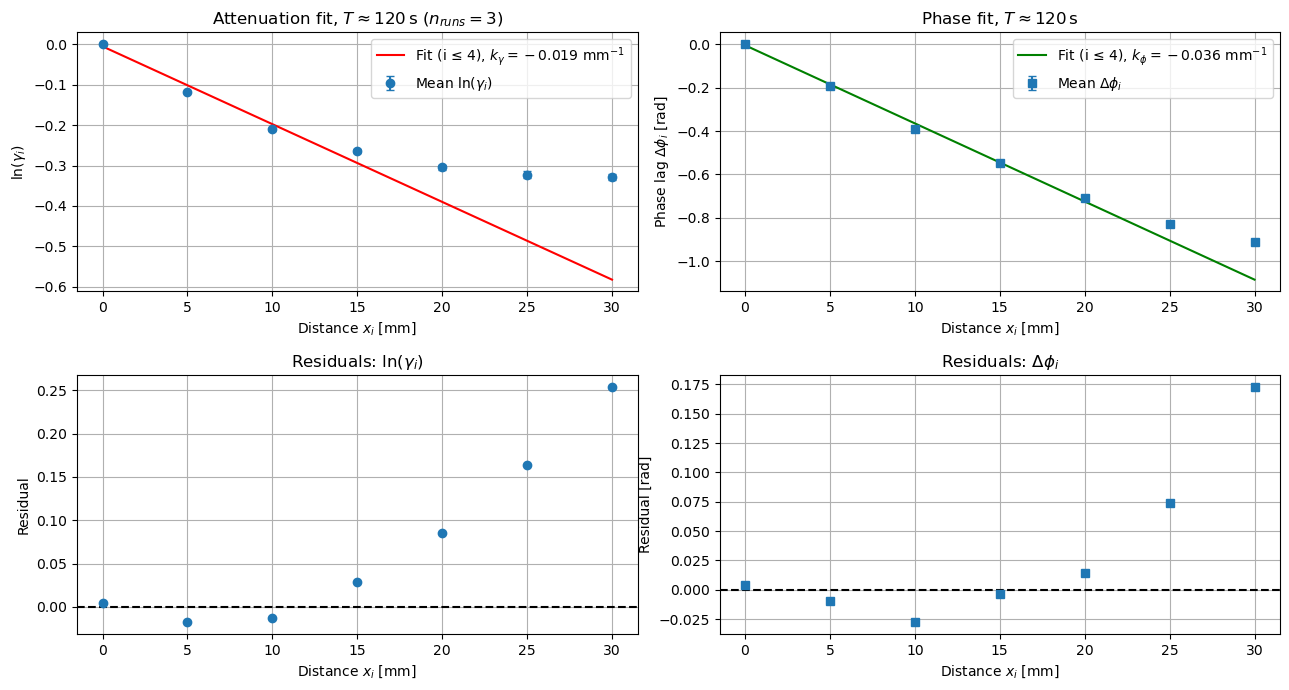

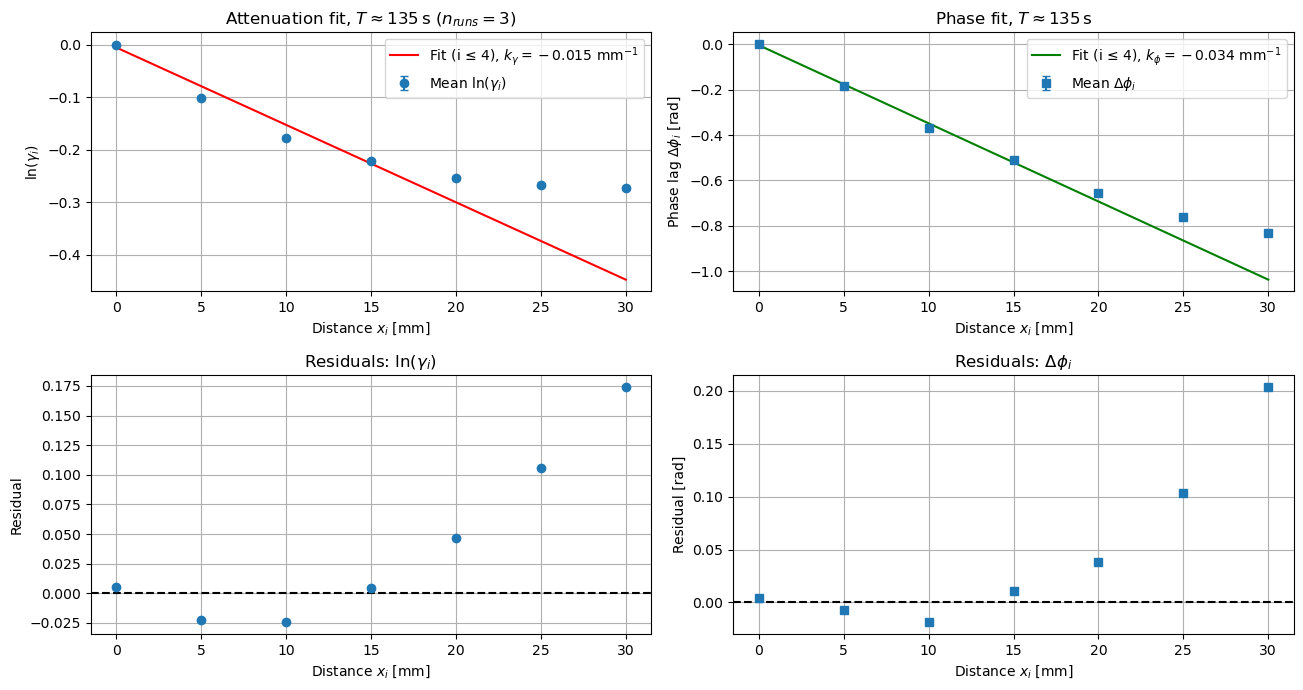

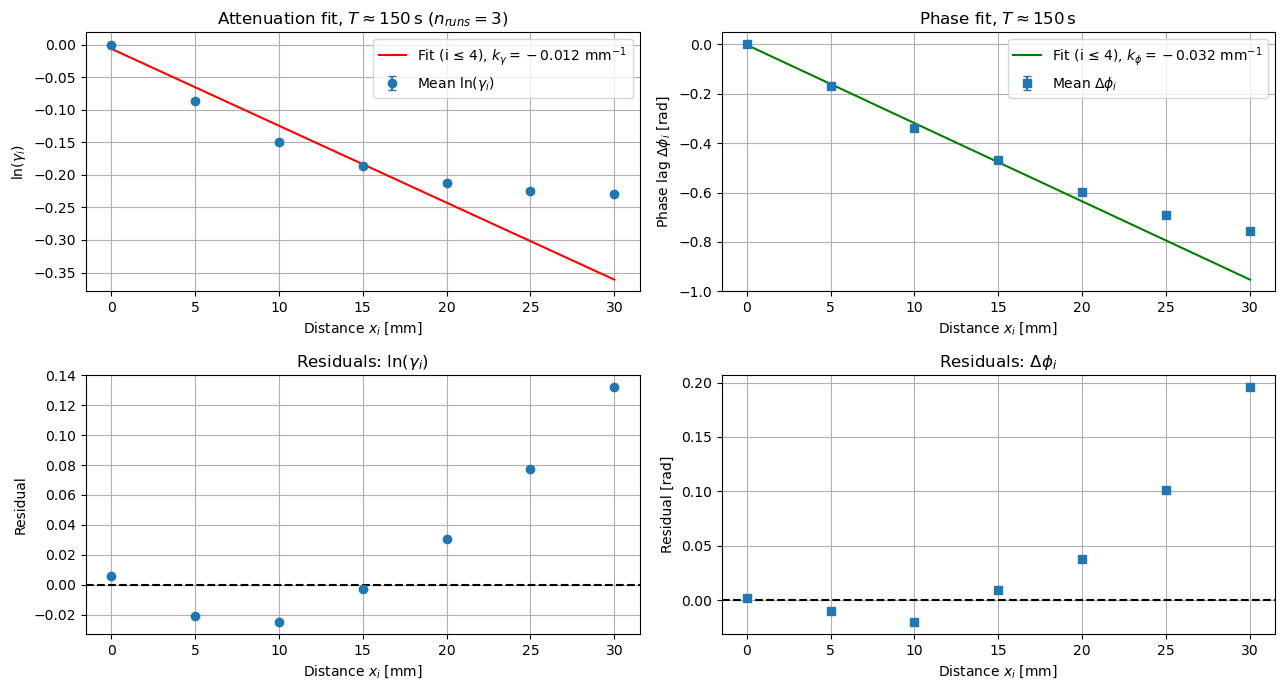

In [216]:
# How many thermistors (i = 0..n_fit_therm) to include in the fit
n_fit_therm = 4

for tau, vals in sorted(period_avg.items()):
    omega      = vals["omega"]
    gamma_mean = vals["gamma_mean"]
    gamma_unc  = vals["gamma_unc"]
    dphi_mean  = vals["dphi_mean"]
    dphi_unc   = vals["dphi_unc"]
    n_runs     = vals["n_runs"]

    n_therm = gamma_mean.shape[0]
    i_vals = np.arange(n_therm)
    x = i_vals * delta_d  # [mm]

    # ---- ln(gamma) and its uncertainty ----
    ln_gamma = np.log(gamma_mean)
    unc_ln_gamma = gamma_unc / gamma_mean   # σ[ln γ] ≈ σγ / γ

    # ---- choose thermistors to fit: i = 0..fit_max_index ----
    fit_max_index = min(n_fit_therm, n_therm - 1)
    idx_fit = np.arange(fit_max_index + 1)

    x_fit           = x[idx_fit]
    ln_gamma_fit    = ln_gamma[idx_fit]
    unc_ln_gamma_fit = unc_ln_gamma[idx_fit]

    dphi_fit   = dphi_mean[idx_fit]
    unc_dphi_fit = dphi_unc[idx_fit]

    # ---- Fit ln(gamma) (weighted if possible) ----
    use_weight_gamma = np.all(np.isfinite(unc_ln_gamma_fit)) and np.any(unc_ln_gamma_fit > 0)

    if use_weight_gamma:
        popt_g, pcov_g = curve_fit(
            linear,
            x_fit,
            ln_gamma_fit,
            sigma=unc_ln_gamma_fit,
            absolute_sigma=True,
            maxfev=10000
        )
    else:
        popt_g, pcov_g = curve_fit(
            linear,
            x_fit,
            ln_gamma_fit,
            maxfev=10000
        )

    k_gamma, c_gamma = popt_g
    ln_fit_all = linear(x, k_gamma, c_gamma)
    ln_resid   = ln_gamma - ln_fit_all

    # ---- Fit phase (weighted if possible) ----
    use_weight_phi = np.all(np.isfinite(unc_dphi_fit)) and np.any(unc_dphi_fit > 0)

    if use_weight_phi:
        popt_phi, pcov_phi = curve_fit(
            linear,
            x_fit,
            dphi_fit,
            sigma=unc_dphi_fit,
            absolute_sigma=True,
            maxfev=10000
        )
    else:
        popt_phi, pcov_phi = curve_fit(
            linear,
            x_fit,
            dphi_fit,
            maxfev=10000
        )

    k_phi, c_phi = popt_phi
    phi_fit_all = linear(x, k_phi, c_phi)
    phi_resid   = dphi_mean - phi_fit_all

    # ---- Make plots: fits + residuals ----
    x_dense = np.linspace(x.min(), x.max(), 300)

    fig, axes = plt.subplots(2, 2, figsize=(13, 7))

    # Top-left: ln(gamma) fit
    ax = axes[0, 0]
    ax.errorbar(
        x, ln_gamma,
        yerr=unc_ln_gamma,
        fmt='o', capsize=3,
        label=r'Mean $\ln(\gamma_i)$'
    )
    ax.plot(
        x_dense,
        linear(x_dense, k_gamma, c_gamma),
        'r-',
        label=rf'Fit (i ≤ {fit_max_index}), $k_\gamma = {k_gamma:.3f}$ mm$^{{-1}}$'
    )
    ax.set_xlabel(r"Distance $x_i$ [mm]")
    ax.set_ylabel(r"$\ln(\gamma_i)$")
    ax.set_title(rf"Attenuation fit, $T \approx {tau:.0f}\,$s ($n_{{runs}}={n_runs}$)")
    ax.grid(True)
    ax.legend()

    # Top-right: phase fit
    ax = axes[0, 1]
    ax.errorbar(
        x, dphi_mean,
        yerr=dphi_unc,
        fmt='s', capsize=3,
        label=r'Mean $\Delta\phi_i$'
    )
    ax.plot(
        x_dense,
        linear(x_dense, k_phi, c_phi),
        'g-',
        label=rf'Fit (i ≤ {fit_max_index}), $k_\phi = {k_phi:.3f}$ mm$^{{-1}}$'
    )
    ax.set_xlabel(r"Distance $x_i$ [mm]")
    ax.set_ylabel(r"Phase lag $\Delta\phi_i$ [rad]")
    ax.set_title(rf"Phase fit, $T \approx {tau:.0f}\,$s")
    ax.grid(True)
    ax.legend()

    # Bottom-left: residuals ln(gamma)
    ax = axes[1, 0]
    ax.axhline(0, color='k', linestyle='--')
    ax.plot(x, ln_resid, 'o')
    ax.set_xlabel(r"Distance $x_i$ [mm]")
    ax.set_ylabel("Residual")
    ax.set_title(r"Residuals: $\ln(\gamma_i)$")
    ax.grid(True)

    # Bottom-right: residuals phase
    ax = axes[1, 1]
    ax.axhline(0, color='k', linestyle='--')
    ax.plot(x, phi_resid, 's')
    ax.set_xlabel(r"Distance $x_i$ [mm]")
    ax.set_ylabel("Residual [rad]")
    ax.set_title(r"Residuals: $\Delta\phi_i$")
    ax.grid(True)

    plt.tight_layout()
    plt.show()


In [217]:
diffusivity_results = {}   # store final Dγ, Dφ values

n_fit_therm = 4  # use thermistors i for the fit

for tau, vals in sorted(period_avg.items()):
    omega      = vals["omega"]
    gamma_mean = vals["gamma_mean"]
    gamma_unc  = vals["gamma_unc"]
    dphi_mean  = vals["dphi_mean"]
    dphi_unc   = vals["dphi_unc"]

    n_therm = len(gamma_mean)
    i_vals = np.arange(n_therm)
    x = i_vals * delta_d  # mm

    # --- Select thermistors for fitting ---
    fit_max_index = min(n_fit_therm, n_therm - 1)
    idx_fit = np.arange(fit_max_index + 1)

    # Data for gamma
    ln_gamma     = np.log(gamma_mean)
    unc_ln_gamma = gamma_unc / gamma_mean

    x_fit            = x[idx_fit]
    ln_gamma_fit     = ln_gamma[idx_fit]
    unc_ln_gamma_fit = unc_ln_gamma[idx_fit]

    # Data for phase
    dphi_fit      = dphi_mean[idx_fit]
    unc_dphi_fit  = dphi_unc[idx_fit]

    # Fit ln(gamma)
    popt_g, pcov_g = curve_fit(
        linear,
        x_fit,
        ln_gamma_fit,
        sigma=unc_ln_gamma_fit,
        absolute_sigma=True,
        maxfev=10000
    )
    k_gamma, c_gamma = popt_g
    unc_k_gamma = np.sqrt(np.diag(pcov_g))[0]

    # Fit dphi
    popt_p, pcov_p = curve_fit(
        linear,
        x_fit,
        dphi_fit,
        sigma=unc_dphi_fit,
        absolute_sigma=True,
        maxfev=10000
    )
    k_phi, c_phi = popt_p
    unc_k_phi = np.sqrt(np.diag(pcov_p))[0]

    # Compute diffusivities
    D_gamma = omega / (2 * k_gamma**2)
    D_phi   = omega / (2 * k_phi**2)

    # Propagate uncertainties
    unc_D_gamma = abs(-omega / (k_gamma**3)) * unc_k_gamma
    unc_D_phi   = abs(-omega / (k_phi**3))   * unc_k_phi

    diffusivity_results[tau] = {
        "omega": omega,
        "k_gamma": k_gamma,
        "k_phi": k_phi,
        "D_gamma": D_gamma,
        "D_phi": D_phi,
        "unc_D_gamma": unc_D_gamma,
        "unc_D_phi": unc_D_phi,
    }

# Print results
for tau, res in sorted(diffusivity_results.items()):
    print(f"T = {tau:.0f} s")
    print(f"  D_gamma = {res['D_gamma']:.4f} ± {res['unc_D_gamma']:.4f} mm^2/s")
    print(f"  D_phi   = {res['D_phi']:.4f} ± {res['unc_D_phi']:.4f} mm^2/s")
    print()


T = 10 s
  D_gamma = 32.1666 ± 0.0847 mm^2/s
  D_phi   = 31.0337 ± 0.0886 mm^2/s

T = 15 s
  D_gamma = 31.0219 ± 0.0960 mm^2/s
  D_phi   = 31.5331 ± 0.1371 mm^2/s

T = 20 s
  D_gamma = 29.9716 ± 0.0842 mm^2/s
  D_phi   = 30.7758 ± 0.0993 mm^2/s

T = 30 s
  D_gamma = 29.9179 ± 0.0660 mm^2/s
  D_phi   = 28.0799 ± 0.1414 mm^2/s

T = 45 s
  D_gamma = 33.8841 ± 0.1153 mm^2/s
  D_phi   = 22.4284 ± 0.0578 mm^2/s

T = 60 s
  D_gamma = 36.8979 ± 0.1596 mm^2/s
  D_phi   = 20.7286 ± 0.0695 mm^2/s

T = 75 s
  D_gamma = 48.4796 ± 0.2695 mm^2/s
  D_phi   = 19.5540 ± 0.0598 mm^2/s

T = 90 s
  D_gamma = 54.6563 ± 0.7154 mm^2/s
  D_phi   = 18.7125 ± 0.1712 mm^2/s

T = 105 s
  D_gamma = 63.3973 ± 1.0416 mm^2/s
  D_phi   = 18.6665 ± 0.1089 mm^2/s

T = 120 s
  D_gamma = 70.5749 ± 1.3475 mm^2/s
  D_phi   = 20.1700 ± 0.0883 mm^2/s

T = 135 s
  D_gamma = 107.5261 ± 1.9448 mm^2/s
  D_phi   = 19.5901 ± 0.1404 mm^2/s

T = 150 s
  D_gamma = 149.5711 ± 3.2218 mm^2/s
  D_phi   = 20.8438 ± 0.2947 mm^2/s



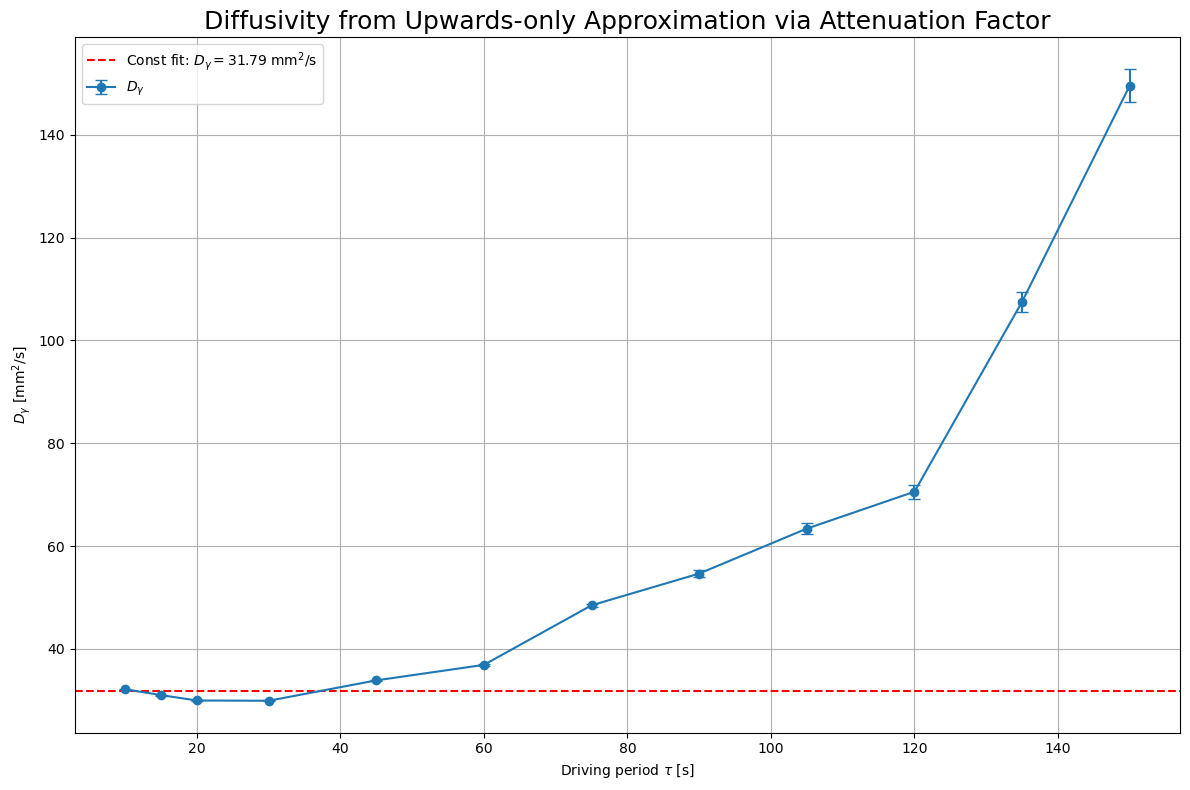

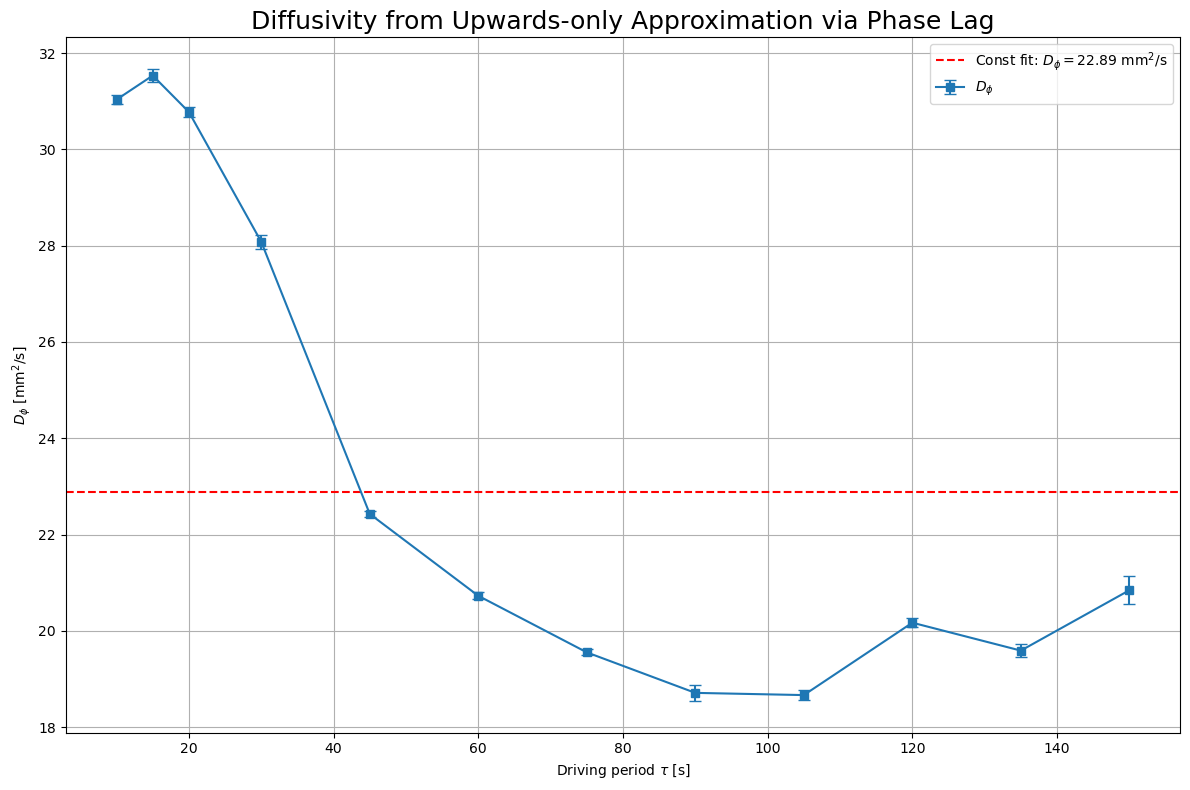

In [218]:
# --- Extract arrays for plotting from diffusivity_results ---
taus   = np.array(sorted(diffusivity_results.keys()))
Dg     = np.array([diffusivity_results[t]["D_gamma"]     for t in taus])
Dg_unc = np.array([diffusivity_results[t]["unc_D_gamma"] for t in taus])
Dp     = np.array([diffusivity_results[t]["D_phi"]       for t in taus])
Dp_unc = np.array([diffusivity_results[t]["unc_D_phi"]   for t in taus])

def constant_model(t, C):
    return C * np.ones_like(t)

# --- Constant fits ---
popt_g, pcov_g = curve_fit(
    constant_model, taus, Dg,
    sigma=Dg_unc, absolute_sigma=True, maxfev=10000
)
Dg_const = popt_g[0]
Dg_resid = Dg - Dg_const

popt_p, pcov_p = curve_fit(
    constant_model, taus, Dp,
    sigma=Dp_unc, absolute_sigma=True, maxfev=10000
)
Dp_const = popt_p[0]
Dp_resid = Dp - Dp_const



# Figure 1: D_gamma vs tau


fig, ax = plt.subplots(figsize=(12,8))

ax.errorbar(
    taus, Dg, yerr=Dg_unc,
    fmt='o-', capsize=4, label=r'$D_\gamma$'
)

ax.axhline(
    Dg_const, color='r', linestyle='--',
    label=rf'Const fit: $D_\gamma = {Dg_const:.2f}$ mm$^2$/s'
)

ax.set_xlabel(r"Driving period $\tau$ [s]")
ax.set_ylabel(r"$D_\gamma$ [mm$^2$/s]")
ax.set_title(r"Diffusivity from Upwards-only Approximation via Attenuation Factor", size=18)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()



# Figure 2: D_phi vs tau

fig, ax = plt.subplots(figsize=(12,8))

ax.errorbar(
    taus, Dp, yerr=Dp_unc,
    fmt='s-', capsize=4, label=r'$D_\phi$'
)

ax.axhline(
    Dp_const, color='r', linestyle='--',
    label=rf'Const fit: $D_\phi = {Dp_const:.2f}$ mm$^2$/s'
)

ax.set_xlabel(r"Driving period $\tau$ [s]")
ax.set_ylabel(r"$D_\phi$ [mm$^2$/s]")
ax.set_title(r"Diffusivity from Upwards-only Approximation via Phase Lag", size=18)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


In [219]:
# Cylinder length in mm (as you used in your markdown: L = 41 mm)
L_mm = 41.0

def cosh_gamma_model(x_mm, D_mm2_s, omega, L=L_mm):
    """
    Full finite-length model for the relative amplitude gamma_i = A_i / A_0
    as a function of distance x in mm, using the script's beta:

        beta = (i - 1) * sqrt(omega / (2D))

    Parameters
    ----------
    x_mm : array
        Thermistor positions in mm (x = i * delta_d).
    D_mm2_s : float
        Thermal diffusivity in mm^2 / s.
    omega : float
        Angular frequency in rad/s.
    L : float
        Cylinder length in mm.

    Returns
    -------
    gamma_model : array
        Model prediction for gamma_i = A_i / A_0 at each x.
    """
    # beta has units 1/mm when D in mm^2/s and omega in 1/s
    beta = (1j - 1.0) * np.sqrt(omega / (2.0 * D_mm2_s))

    # Complex spatial dependence with zero-flux at x = L:
    # T̃(x) ∝ cosh[β(L - x)] / cosh(β L)
    num   = np.cosh(beta * (L - x_mm))
    denom = np.cosh(beta * L)

    gamma_complex = num / denom
    gamma_model   = np.abs(gamma_complex)  # amplitude ratio

    return gamma_model


In [220]:
# --- Fit D using the full finite-length cosh model for each period ---

diffusivity_cosh_results = {}  # store D_cosh per period

for tau, vals in sorted(period_avg.items()):
    omega      = vals["omega"]        # mean omega for this period
    gamma_mean = vals["gamma_mean"]   # shape (n_therm,)
    gamma_unc  = vals["gamma_unc"]    # shape (n_therm,)

    n_therm = gamma_mean.shape[0]
    i_vals  = np.arange(n_therm)
    x_mm    = i_vals * delta_d   # positions in mm

    # Use all thermistors whose uncertainties are finite and non-zero
    mask = np.isfinite(gamma_mean) & np.isfinite(gamma_unc) & (gamma_unc > 0)
    x_fit       = x_mm[mask]
    gamma_fit   = gamma_mean[mask]
    gamma_sigma = gamma_unc[mask]

    # Initial guess for D: use plane-wave D_gamma for this tau if available,
    # otherwise a reasonable brass value like 30 mm^2/s.
    if tau in diffusivity_results:
        D_init = diffusivity_results[tau]["D_gamma"]
    else:
        D_init = 30.0  # mm^2/s

    # Fit the cosh model: only one free parameter, D
    popt_cosh, pcov_cosh = curve_fit(
        lambda x, D: cosh_gamma_model(x, D, omega, L=L_mm),
        x_fit,
        gamma_fit,
        sigma=gamma_sigma,
        absolute_sigma=True,
        p0=[D_init],
        bounds=(1e-6, np.inf),  # <-- THIS FIXES THE PROBLEM
        maxfev=20000
    )


    D_cosh = float(popt_cosh[0])
    unc_D_cosh = float(np.sqrt(pcov_cosh[0, 0]))

    diffusivity_cosh_results[tau] = {
        "omega": omega,
        "D_cosh": D_cosh,
        "unc_D_cosh": unc_D_cosh,
    }

    print(f"T = {tau:.0f} s  ->  D_cosh = {D_cosh:.3f} ± {unc_D_cosh:.3f} mm^2/s")


T = 10 s  ->  D_cosh = 32.052 ± 0.060 mm^2/s
T = 15 s  ->  D_cosh = 32.576 ± 0.073 mm^2/s
T = 20 s  ->  D_cosh = 31.630 ± 0.068 mm^2/s
T = 30 s  ->  D_cosh = 33.916 ± 0.049 mm^2/s
T = 45 s  ->  D_cosh = 36.364 ± 0.041 mm^2/s
T = 60 s  ->  D_cosh = 36.272 ± 0.058 mm^2/s
T = 75 s  ->  D_cosh = 36.942 ± 0.048 mm^2/s
T = 90 s  ->  D_cosh = 36.281 ± 0.110 mm^2/s
T = 105 s  ->  D_cosh = 36.722 ± 0.181 mm^2/s
T = 120 s  ->  D_cosh = 36.231 ± 0.204 mm^2/s
T = 135 s  ->  D_cosh = 37.019 ± 0.150 mm^2/s
T = 150 s  ->  D_cosh = 37.509 ± 0.146 mm^2/s


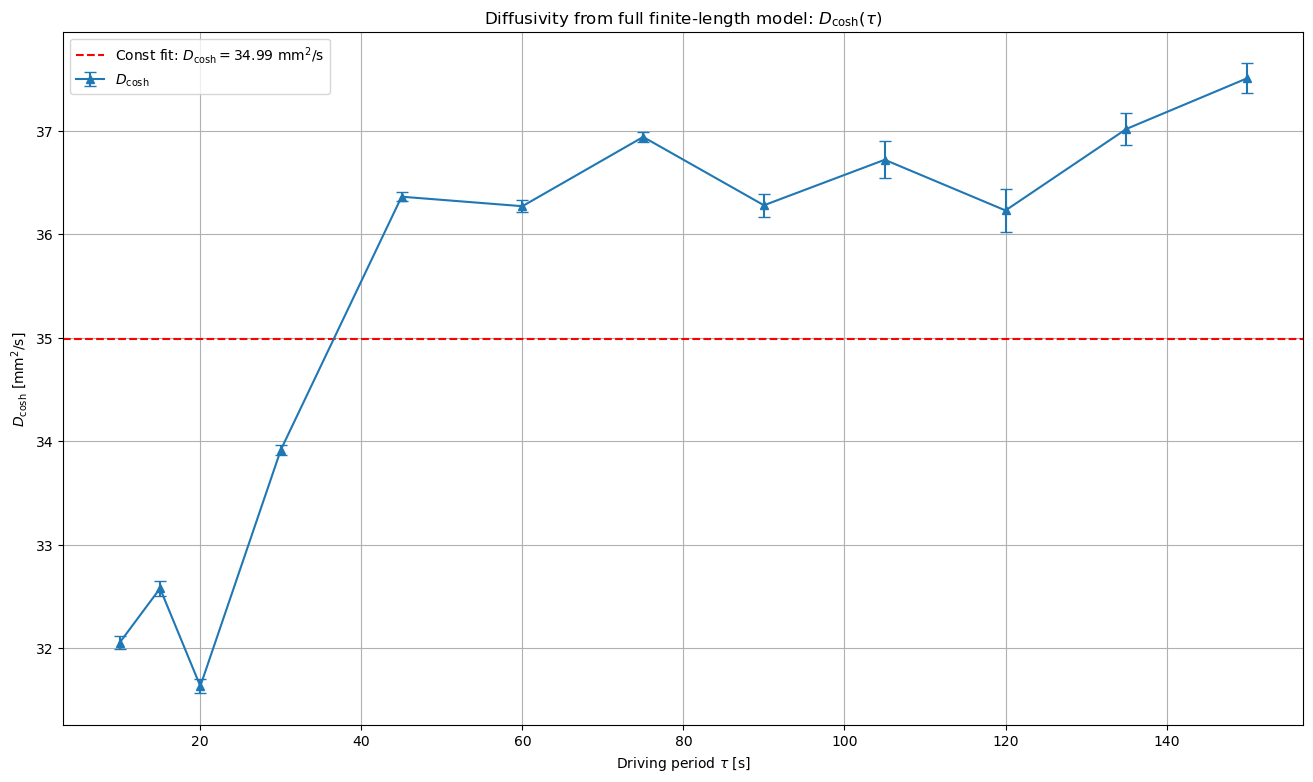

In [221]:
# --- Extract arrays for plotting from diffusivity_cosh_results ---
taus_cosh = np.array(sorted(diffusivity_cosh_results.keys()))
Dc        = np.array([diffusivity_cosh_results[t]["D_cosh"]      for t in taus_cosh])
Dc_unc    = np.array([diffusivity_cosh_results[t]["unc_D_cosh"]  for t in taus_cosh])

def constant_model(t, C):
    return C * np.ones_like(t)

# --- Constant fit for D_cosh ---
popt_c, pcov_c = curve_fit(
    constant_model, taus_cosh, Dc,
    sigma=Dc_unc, absolute_sigma=True, maxfev=10000
)
Dc_const = popt_c[0]
Dc_resid = Dc - Dc_const

# ============================
# Figure: D_cosh vs tau + residuals
# ============================
fig, ax = plt.subplots(figsize=(16,9))

# Top: D_cosh vs tau
ax.errorbar(
    taus_cosh, Dc, yerr=Dc_unc,
    fmt='^-', capsize=4, label=r'$D_{\mathrm{cosh}}$'
)
ax.axhline(
    Dc_const, color='r', linestyle='--',
    label=rf'Const fit: $D_{{\mathrm{{cosh}}}} = {Dc_const:.2f}$ mm$^2$/s'
)
ax.set_xlabel(r"Driving period $\tau$ [s]")
ax.set_ylabel(r"$D_{\mathrm{cosh}}$ [mm$^2$/s]")
ax.set_title(r"Diffusivity from full finite-length model: $D_{\mathrm{cosh}}(\tau)$")
ax.grid(True)
ax.legend()



